In [ ]:
!pip install datasets

In [ ]:
%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install transformers
%pip install spacy tqdm
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  1.11.0+cu113
torchtext Version:  0.12.0
Using CPU.


In [ ]:
from datasets import load_metric, load_dataset
# Load dataset
datasets = load_dataset("surrey-nlp/PLOD-CW")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# training set - 1072
# val set out - 153
# test set out - 126
train_dataset = datasets["train"]
val_dataset = datasets["validation"]
test_dataset = datasets["test"]
print(f"train_dataset : {train_dataset}") # this is a dict with keys tokens, pos_tags, ner_tags
print(f"val_dataset : {val_dataset}")
print(f"test_dataset : {test_dataset}")

train_dataset : Dataset({
    features: ['tokens', 'pos_tags', 'ner_tags'],
    num_rows: 1072
})
val_dataset : Dataset({
    features: ['tokens', 'pos_tags', 'ner_tags'],
    num_rows: 126
})
test_dataset : Dataset({
    features: ['tokens', 'pos_tags', 'ner_tags'],
    num_rows: 153
})


In [ ]:
print(train_dataset[:3])

{'tokens': [['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.'], ['The', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'gs', ',', 'mol', 'H2O', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'E', ',', 'mmol', 'H2O', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'PN', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'CO2', 'concentration', 'CO2', '(', 'Ci', ',', 'μmol', 'm-2', 's-1', ')', '.'], ['Minor', 'H', 'antigen', 'alloimmune', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'HLA)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'SCT', ')', '[', '3,4', ']', '.']], 'pos_tags': [['ADP', 'DET', 'NOUN', 'DET', 'PROPN', 'PROPN', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'AUX', 'VERB', 'PUNCT'], ['DET', 'ADJ', 'ADJ', 'NOU

In [ ]:
import random
import pandas as pd
from IPython.display import display, HTML
from datasets import ClassLabel, Sequence

def display_training_data(dataset, no_of_training_elems=5):
  assert no_of_training_elems <= len(dataset), "Number should be less than dataset."
  df = pd.DataFrame(dataset[:no_of_training_elems])
  print(dataset.features.items())

  for column, typ in dataset.features.items():
        print(typ)
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
  display(HTML(df.to_html()))

In [ ]:
display_training_data(train_dataset, 3)

dict_items([('tokens', Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)), ('pos_tags', Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)), ('ner_tags', Sequence(feature=Value(dtype='string', id=None), length=-1, id=None))])
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, Persons, Empowerment, Scale, (, GYPES, ), was, developed, .]","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PROPN, PROPN, PUNCT, PROPN, PUNCT, AUX, VERB, PUNCT]","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O]"
1,"[The, following, physiological, traits, were, measured, :, stomatal, conductance, (, gs, ,, mol, H2O, m-2, s-1, ), ,, transpiration, rate, (, E, ,, mmol, H2O, m-2, s-1, ), ,, net, photosynthetic, rate, (, PN, ,, μmol, m-2, s-1, ), and, intercellular, CO2, concentration, CO2, (, Ci, ,, μmol, m-2, s-1, ), .]","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, NOUN, PUNCT, PROPN, PUNCT, NOUN, NOUN, NOUN, NOUN, PUNCT, PUNCT, NOUN, NOUN, PUNCT, PROPN, PUNCT, NOUN, NOUN, NOUN, NOUN, PUNCT, PUNCT, ADJ, ADJ, NOUN, PUNCT, PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT, CCONJ, ADJ, NOUN, NOUN, PROPN, PUNCT, PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT, PUNCT]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-AC, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O]"
2,"[Minor, H, antigen, alloimmune, responses, readily, occur, in, the, setting, of, human, leukocyte, antigen, (, HLA)–matched, allogeneic, solid, organ, and, stem, cell, transplantation, (, SCT, ), [, 3,4, ], .]","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, DET, NOUN, ADP, ADJ, NOUN, NOUN, PUNCT, PROPN, ADJ, ADJ, NOUN, CCONJ, NOUN, NOUN, NOUN, PUNCT, PROPN, PUNCT, PUNCT, NUM, PUNCT, PUNCT]","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O]"


In [ ]:
metric = load_metric("seqeval")

<ipython-input-5-e20ba34f8cc7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


# Experiment 1: Comparing vectorization methods

System 1: No preprocessing, TF-IDF, SVM vs.

System 2: No preprocessing, Bag of Words, SVM vs.

System3: No preprocessing, Hash Vectorization, SVM

# *TF-IDF with SVM*

In [ ]:
label_map = {'B-O':0,'B-LF':1, 'I-LF':2, 'B-AC':3}
# map ner tags to numbers from label_map
train_ner_label_enc = []
for ner_tag in train_dataset['ner_tags']:
    train_ner_label_enc.append([label_map[ner] for ner in ner_tag])

val_ner_label_enc = []
for ner_tag in val_dataset['ner_tags']:
    val_ner_label_enc.append([label_map[ner] for ner in ner_tag])

test_ner_label_enc = []
for ner_tag in test_dataset['ner_tags']:
    test_ner_label_enc.append([label_map[ner] for ner in ner_tag])

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Label encoding
Encoder = LabelEncoder()
Train_Y_1 = Encoder.fit_transform([tag for sublist in train_ner_label_enc for tag in sublist])
Val_Y_1 = Encoder.fit_transform([tag for sublist in val_ner_label_enc for tag in sublist])
Test_Y_1 = Encoder.fit_transform([tag for sublist in test_ner_label_enc for tag in sublist])

In [ ]:
print(type(Train_Y_1), type(Val_Y_1), type(Test_Y_1))
print(Train_Y_1.size, Val_Y_1.size, Test_Y_1.size)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
40000 5000 5000


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit([tag for sublist in train_dataset['tokens'] for tag in sublist])
# Flatten and transform
Train_X_Tfidf_1 = Tfidf_vect.transform([tag for sublist in train_dataset['tokens'] for tag in sublist])
Val_X_Tfidf_1 = Tfidf_vect.transform([tag for sublist in val_dataset['tokens'] for tag in sublist])
Test_X_Tfidf_1 = Tfidf_vect.transform([tag for sublist in test_dataset['tokens'] for tag in sublist])

In [ ]:
print(type(Train_X_Tfidf_1), Train_X_Tfidf_1.shape)
print(type(Val_X_Tfidf_1), Val_X_Tfidf_1.shape)

<class 'scipy.sparse._csr.csr_matrix'> (40000, 5000)
<class 'scipy.sparse._csr.csr_matrix'> (5000, 5000)


In [ ]:
# Train SVM classifier
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(Train_X_Tfidf_1, Train_Y_1)

SVC(kernel='linear')

In [ ]:
# Predict on validation set
val_pred = svm_classifier.predict(Val_X_Tfidf_1)

In [ ]:
# Calculate F1 score for validation set
from sklearn.metrics import f1_score
#f1_val = f1_score(Val_Y_1, val_pred, average='micro')  # Micro-average F1 score
#print("F1 Score on Validation Set:", f1_val)

F1 Score on Validation Set: 0.8708


In [ ]:
tolabel_map = {0:'B-O',1:'B-LF', 2:'I-LF', 3:'B-AC'}
val_pred_list = [[tolabel_map[int(num)] for num in val_pred]]
Val_Y_1_list = [[tolabel_map[int(num)] for num in Val_Y_1]]

In [ ]:
tfidf_results = metric.compute(predictions=val_pred_list, references=Val_Y_1_list)
print("Validation scores")
tfidf_results

Validation scores


{'AC': {'precision': 0.8279569892473119,
  'recall': 0.29277566539923955,
  'f1': 0.4325842696629213,
  'number': 263},
 'LF': {'precision': 0.0658682634730539,
  'recall': 0.07236842105263158,
  'f1': 0.06896551724137931,
  'number': 152},
 'O': {'precision': 0.8858660998937301,
  'recall': 0.9781741375264023,
  'f1': 0.9297345527548517,
  'number': 4261},
 'overall_precision': 0.8572004028197382,
 'overall_recall': 0.9101796407185628,
 'overall_f1': 0.8828959651488434,
 'overall_accuracy': 0.8708}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score
precision, recall, f1_s, _ = precision_recall_fscore_support(Val_Y_1, val_pred, average='micro')

print("Precision on Validation Set:", precision)
print("Recall on Validation Set:", recall)
print("F1 Score on Validation Set:", f1_s)

Precision on Validation Set: 0.8708
Recall on Validation Set: 0.8708
F1 Score on Validation Set: 0.8708


In [ ]:
# Predict on test set
test_pred = svm_classifier.predict(Test_X_Tfidf_1)

In [ ]:
# Calculate precision, recall, and F1 score
precision, recall, f1_s, _ = precision_recall_fscore_support(Test_Y_1, test_pred, average='micro')

print("Precision on Test Set:", precision)
print("Recall on Test Set:", recall)
print("F1 Score on Test Set:", f1_s)

Precision on Test Set: 0.8656
Recall on Test Set: 0.8656
F1 Score on Test Set: 0.8656


In [ ]:
test_pred_list = [[tolabel_map[int(num)] for num in test_pred]]
Test_Y_1_list = [[tolabel_map[int(num)] for num in Test_Y_1]]

In [ ]:
test_results = metric.compute(predictions=test_pred_list, references=Test_Y_1_list)
test_results

{'AC': {'precision': 0.7906976744186046,
  'recall': 0.2518518518518518,
  'f1': 0.3820224719101123,
  'number': 270},
 'LF': {'precision': 0.04216867469879518,
  'recall': 0.046052631578947366,
  'f1': 0.0440251572327044,
  'number': 152},
 'O': {'precision': 0.886277001270648,
  'recall': 0.9750698974836906,
  'f1': 0.9285555802085644,
  'number': 4292},
 'overall_precision': 0.856453558504222,
 'overall_recall': 0.903691132795927,
 'overall_f1': 0.8794384805945501,
 'overall_accuracy': 0.8656}

In [ ]:
from sklearn.metrics import classification_report

test_report = classification_report(Test_Y_1, test_pred, target_names=['B-O', 'B-LF', 'I-LF', 'B-AC'])

print(test_report)

              precision    recall  f1-score   support

         B-O       0.89      0.98      0.93      4292
        B-LF       0.33      0.12      0.18       150
        I-LF       0.42      0.20      0.27       288
        B-AC       0.79      0.25      0.38       270

    accuracy                           0.87      5000
   macro avg       0.61      0.39      0.44      5000
weighted avg       0.84      0.87      0.84      5000



[[4185   24   66   17]
 [ 123   18    9    0]
 [ 217   13   57    1]
 [ 197    0    5   68]]


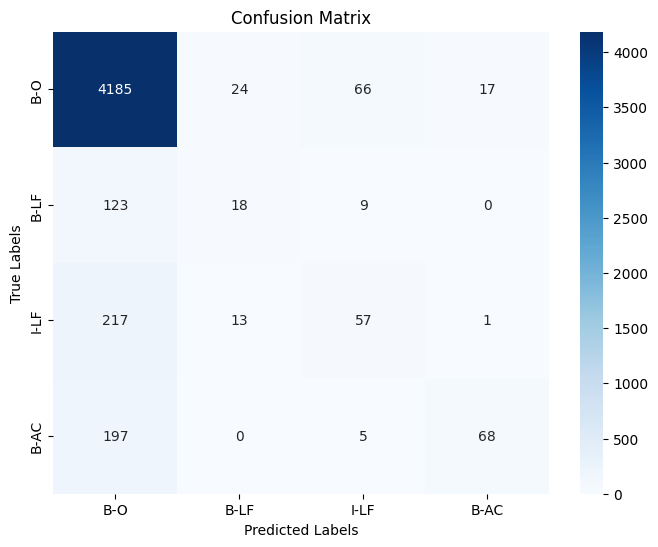

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, test_pred)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# *Bag of Words with SVM*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Bag of Words encoding
vectorizer = CountVectorizer(max_features=5000)
vectorizer.fit([tag for sublist in train_dataset['tokens'] for tag in sublist])
# Flatten and transform
Train_X_bow = vectorizer.transform([tag for sublist in train_dataset['tokens'] for tag in sublist])
Val_X_bow = vectorizer.transform([tag for sublist in val_dataset['tokens'] for tag in sublist])
Test_X_bow = vectorizer.transform([tag for sublist in test_dataset['tokens'] for tag in sublist])

In [ ]:
print(type(Train_X_bow), Train_X_bow.shape)
print(type(Val_X_bow), Val_X_bow.shape)

<class 'scipy.sparse._csr.csr_matrix'> (40000, 5000)
<class 'scipy.sparse._csr.csr_matrix'> (5000, 5000)


In [ ]:
from sklearn.svm import SVC
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(Train_X_bow, Train_Y_1)

SVC(kernel='linear')

In [ ]:
# Predict on validation set
val_pred_bow = svm_classifier.predict(Val_X_bow)

In [ ]:
# Calculate F1 score for validation set
from sklearn.metrics import f1_score
#f1_val_bow = f1_score(Val_Y_1, val_pred_bow, average='micro')  # Micro-average F1 score
#print("F1 Score on Validation Set:", f1_val_bow)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# Calculate precision, recall, and F1 score
precision, recall, f1_s, _ = precision_recall_fscore_support(Val_Y_1, val_pred_bow, average='micro')

print("Precision on Validation Set:", precision)
print("Recall on Validation Set:", recall)
print("F1 Score on Validation Set:", f1_s)

Precision on Validation Set: 0.8706
Recall on Validation Set: 0.8706
F1 Score on Validation Set: 0.8706


In [ ]:
tolabel_map = {0:'B-O',1:'B-LF', 2:'I-LF', 3:'B-AC'}
val_pred_list_bow = [[tolabel_map[int(num)] for num in val_pred_bow]]
Val_Y_1_list_bow = [[tolabel_map[int(num)] for num in Val_Y_1]]

In [ ]:
val_results_bow = metric.compute(predictions=val_pred_list_bow, references=Val_Y_1_list_bow)
val_results_bow

{'AC': {'precision': 0.8125,
  'recall': 0.2965779467680608,
  'f1': 0.4345403899721448,
  'number': 263},
 'LF': {'precision': 0.0658682634730539,
  'recall': 0.07236842105263158,
  'f1': 0.06896551724137931,
  'number': 152},
 'O': {'precision': 0.8860059549128031,
  'recall': 0.9777047641398733,
  'f1': 0.9295994644650228,
  'number': 4261},
 'overall_precision': 0.8569989929506546,
 'overall_recall': 0.9099657827202737,
 'overall_f1': 0.8826885177886112,
 'overall_accuracy': 0.8706}

In [ ]:
# Predict on test set
test_pred_bow = svm_classifier.predict(Test_X_bow)

In [ ]:
# Calculate precision, recall, and F1 score
precision, recall, f1_s, _ = precision_recall_fscore_support(Test_Y_1, test_pred_bow, average='micro')

print("Precision on Test Set:", precision)
print("Recall on Test Set:", recall)
print("F1 Score on Test Set:", f1_s)

Precision on Test Set: 0.8654
Recall on Test Set: 0.8654
F1 Score on Test Set: 0.8653999999999998


In [ ]:
test_pred_list_bow = [[tolabel_map[int(num)] for num in test_pred_bow]]
Test_Y_1_list_bow = [[tolabel_map[int(num)] for num in Test_Y_1]]

In [ ]:
test_results_bow = metric.compute(predictions=test_pred_list_bow, references=Test_Y_1_list_bow)
test_results_bow

{'AC': {'precision': 0.7816091954022989,
  'recall': 0.2518518518518518,
  'f1': 0.3809523809523809,
  'number': 270},
 'LF': {'precision': 0.04216867469879518,
  'recall': 0.046052631578947366,
  'f1': 0.0440251572327044,
  'number': 152},
 'O': {'precision': 0.8862529125185342,
  'recall': 0.9748369058713886,
  'f1': 0.9284367025407745,
  'number': 4292},
 'overall_precision': 0.8562525130679534,
 'overall_recall': 0.9034789987271956,
 'overall_f1': 0.879232039636664,
 'overall_accuracy': 0.8654}

In [ ]:
from sklearn.metrics import classification_report

test_report_bow = classification_report(Test_Y_1, test_pred_bow, target_names=['B-O', 'B-LF', 'I-LF', 'B-AC'])

print(test_report_bow)

              precision    recall  f1-score   support

         B-O       0.89      0.97      0.93      4292
        B-LF       0.33      0.12      0.18       150
        I-LF       0.42      0.20      0.27       288
        B-AC       0.78      0.25      0.38       270

    accuracy                           0.87      5000
   macro avg       0.60      0.39      0.44      5000
weighted avg       0.84      0.87      0.84      5000



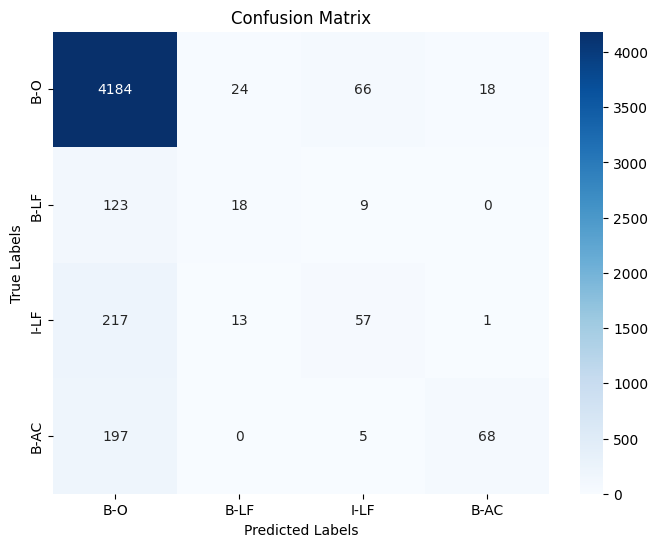

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, test_pred_bow)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'])#label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# *HashingVectoration with SVM*

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
hash_vectorizer = HashingVectorizer(n_features=5000)
hash_vectorizer.fit([tag for sublist in train_dataset['tokens'] for tag in sublist])
Train_X_hash = hash_vectorizer.transform([tag for sublist in train_dataset['tokens'] for tag in sublist])
Val_X_hash = hash_vectorizer.transform([tag for sublist in val_dataset['tokens'] for tag in sublist])
Test_X_hash = hash_vectorizer.transform([tag for sublist in test_dataset['tokens'] for tag in sublist])

In [ ]:
print(type(Train_X_hash), Train_X_hash.shape)
print(type(Val_X_hash), Val_X_hash.shape)

<class 'scipy.sparse._csr.csr_matrix'> (40000, 5000)
<class 'scipy.sparse._csr.csr_matrix'> (5000, 5000)


In [ ]:
from sklearn.svm import SVC
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(Train_X_hash, Train_Y_1)

SVC(kernel='linear')

In [ ]:
# Predict on validation set
val_pred_hash = svm_classifier.predict(Val_X_hash)

In [ ]:
# Calculate F1 score for validation set
from sklearn.metrics import f1_score
#f1_val_hash = f1_score(Val_Y_1, val_pred_hash, average='micro')  # Micro-average F1 score
#print("F1 Score on Validation Set:", f1_val_hash)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
# Calculate precision, recall, and F1 score
precision, recall, f1_s, _ = precision_recall_fscore_support(Val_Y_1, val_pred_hash, average='micro')

print("Precision on Validation Set:", precision)
print("Recall on Validation Set:", recall)
print("F1 Score on Validation Set:", f1_s)

Precision on Validation Set: 0.8498
Recall on Validation Set: 0.8498
F1 Score on Validation Set: 0.8498


In [ ]:
tolabel_map = {0:'B-O',1:'B-LF', 2:'I-LF', 3:'B-AC'}
val_pred_list_hash = [[tolabel_map[int(num)] for num in val_pred_hash]]
Val_Y_1_list_hash = [[tolabel_map[int(num)] for num in Val_Y_1]]

In [ ]:
val_results_hash = metric.compute(predictions=val_pred_list_hash, references=Val_Y_1_list_hash)
val_results_hash

{'AC': {'precision': 0.4883720930232558,
  'recall': 0.23954372623574144,
  'f1': 0.32142857142857145,
  'number': 263},
 'LF': {'precision': 0.04736842105263158,
  'recall': 0.05921052631578947,
  'f1': 0.052631578947368425,
  'number': 152},
 'O': {'precision': 0.879965643117887,
  'recall': 0.9617460689978878,
  'f1': 0.9190401435299395,
  'number': 4261},
 'overall_precision': 0.8380225080385852,
 'overall_recall': 0.8917878528656972,
 'overall_f1': 0.8640696228760878,
 'overall_accuracy': 0.8498}

In [ ]:
# Predict on test set
test_pred_hash = svm_classifier.predict(Test_X_hash)

In [ ]:
test_pred_list_hash = [[tolabel_map[int(num)] for num in test_pred_hash]]
Test_Y_1_list_hash = [[tolabel_map[int(num)] for num in Test_Y_1]]

In [ ]:
test_results_hash = metric.compute(predictions=test_pred_list_hash, references=Test_Y_1_list_hash)
test_results_hash

{'AC': {'precision': 0.6050420168067226,
  'recall': 0.26666666666666666,
  'f1': 0.3701799485861182,
  'number': 270},
 'LF': {'precision': 0.015,
  'recall': 0.019736842105263157,
  'f1': 0.017045454545454544,
  'number': 152},
 'O': {'precision': 0.8868167202572347,
  'recall': 0.9638863000931966,
  'f1': 0.9237467902199397,
  'number': 4292},
 'overall_precision': 0.8451043338683788,
 'overall_recall': 0.8935086974968179,
 'overall_f1': 0.868632707774799,
 'overall_accuracy': 0.8528}

In [ ]:
# Calculate precision, recall, and F1 score
precision, recall, f1_s, _ = precision_recall_fscore_support(Test_Y_1, test_pred_hash, average='micro')

print("Precision on Test Set:", precision)
print("Recall on Test Set:", recall)
print("F1 Score on Test Set:", f1_s)

Precision on Test Set: 0.8528
Recall on Test Set: 0.8528
F1 Score on Test Set: 0.8528


In [ ]:
from sklearn.metrics import classification_report

test_report_hash = classification_report(Test_Y_1, test_pred_hash, target_names=['B-O', 'B-LF', 'I-LF', 'B-AC'])

print(test_report_hash)

              precision    recall  f1-score   support

         B-O       0.89      0.96      0.92      4292
        B-LF       0.16      0.07      0.10       150
        I-LF       0.30      0.15      0.20       288
        B-AC       0.61      0.27      0.37       270

    accuracy                           0.85      5000
   macro avg       0.49      0.36      0.40      5000
weighted avg       0.82      0.85      0.83      5000



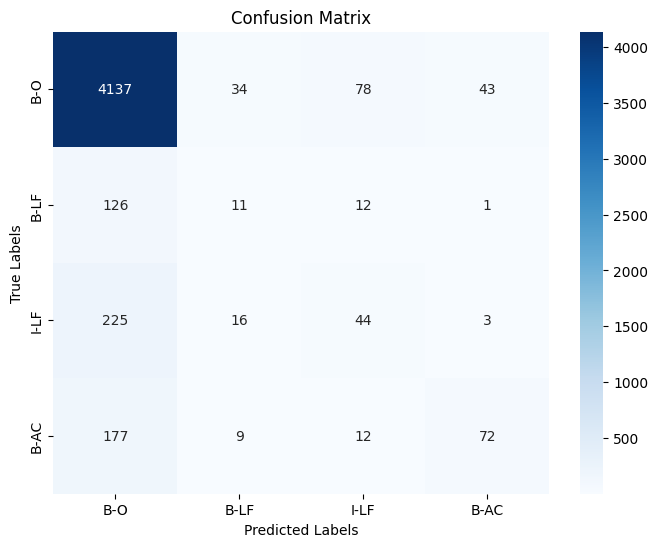

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, test_pred_hash)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'])#label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Experiment 2 : Comparing algorithms SVM and FFNN


# *SVM and FFNN with TF-IDF vectorization*

In [ ]:
import tensorflow as tf

# Define model parameters
num_classes = len(Encoder.classes_)
input_dim = Train_X_Tfidf_1.shape[1]  # Number of TF-IDF features

print(type(Train_X_Tfidf_1), Train_X_Tfidf_1.shape)
# Build the FFNN model
ffnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=input_dim),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

<class 'scipy.sparse._csr.csr_matrix'> (40000, 5000)


In [ ]:
# convert from sparse matrix to array
Train_X_Tfidf_array = Train_X_Tfidf_1.toarray()
Val_X_Tfidf_array = Val_X_Tfidf_1.toarray()
Test_X_Tfidf_array = Test_X_Tfidf_1.toarray()

In [ ]:
# Compile the model
ffnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ffnn_model.fit(Train_X_Tfidf_array, Train_Y_1, epochs=10, batch_size=32, validation_data=(Val_X_Tfidf_array, Val_Y_1))

Epoch 1/10
1250/1250 [==============================] - 7s 3ms/step - loss: 0.6094 - accuracy: 0.8256 - val_loss: 0.4875 - val_accuracy: 0.8536
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4801 - accuracy: 0.8498 - val_loss: 0.4560 - val_accuracy: 0.8672
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4205 - accuracy: 0.8678 - val_loss: 0.4554 - val_accuracy: 0.8642
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3960 - accuracy: 0.8736 - val_loss: 0.4532 - val_accuracy: 0.8668
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3815 - accuracy: 0.8759 - val_loss: 0.4519 - val_accuracy: 0.8688
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3721 - accuracy: 0.8771 - val_loss: 0.4599 - val_accuracy: 0.8674
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3669 - accuracy: 0.8781 - val_loss: 0.4692 - val_accuracy:

In [ ]:
tolabel_map = {0:'B-O',1:'B-LF', 2:'I-LF', 3:'B-AC'}
# Flatten true labels to get metrics
Val_Y_1_list = [[tolabel_map[int(num)] for num in Val_Y_1]]
Test_Y_1_list = [[tolabel_map[int(num)] for num in Test_Y_1]]
print(Val_Y_1_list)

[['B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-AC', 'B-O', 'B-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 

In [ ]:
ffnn_test_pred = ffnn_model.predict(Test_X_Tfidf_array)

157/157 [==============================] - 0s 2ms/step


In [ ]:
import numpy as np
ffnn_test_pred_indices = np.argmax(ffnn_test_pred, axis=1)

In [ ]:
# Flatten predicted labels to get metrics
ffnn_test_pred_labels = [[tolabel_map[int(num)] for num in ffnn_test_pred_indices]]
print(ffnn_test_pred_labels)

[['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B

In [ ]:
test_results = metric.compute(predictions=ffnn_test_pred_labels, references=Test_Y_1_list)
test_results

{'AC': {'precision': 0.7529411764705882,
  'recall': 0.23703703703703705,
  'f1': 0.36056338028169016,
  'number': 270},
 'LF': {'precision': 0.036458333333333336,
  'recall': 0.046052631578947366,
  'f1': 0.040697674418604654,
  'number': 152},
 'O': {'precision': 0.8871620183095593,
  'recall': 0.9708760484622554,
  'f1': 0.9271331627544777,
  'number': 4292},
 'overall_precision': 0.8520305589063129,
 'overall_recall': 0.8990241832838354,
 'overall_f1': 0.8748967795210569,
 'overall_accuracy': 0.864}

In [ ]:
from sklearn.metrics import classification_report

test_report = classification_report(Test_Y_1, ffnn_test_pred_indices, target_names=['B-O', 'B-LF', 'I-LF', 'B-AC'])

print(test_report)

              precision    recall  f1-score   support

         B-O       0.89      0.97      0.93      4292
        B-LF       0.30      0.13      0.18       150
        I-LF       0.45      0.24      0.32       288
        B-AC       0.75      0.24      0.36       270

    accuracy                           0.86      5000
   macro avg       0.60      0.39      0.45      5000
weighted avg       0.84      0.86      0.84      5000



[[4167   31   73   21]
 [ 124   19    7    0]
 [ 204   14   70    0]
 [ 202    0    4   64]]


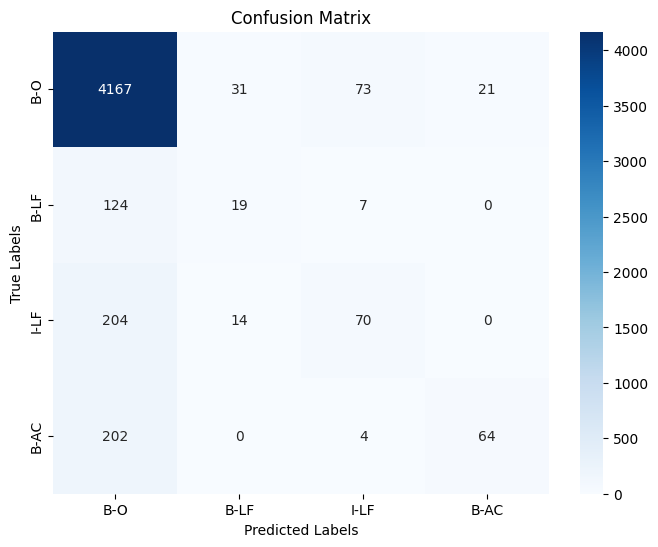

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, ffnn_test_pred_indices)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Experiment 3 and 4: FFNN best performance with different optimizers, LRs, batch size and epochs modification.

# *lr = 0.001, epoch = 50, batch size = 64, optimizer = adam*

In [ ]:
ffnn_model.fit(Train_X_Tfidf_array, Train_Y_1, epochs=50, batch_size=64, validation_data=(Val_X_Tfidf_array, Val_Y_1))

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 0.6313 - accuracy: 0.8238 - val_loss: 0.4991 - val_accuracy: 0.8550
Epoch 2/50
625/625 [==============================] - 2s 3ms/step - loss: 0.5062 - accuracy: 0.8424 - val_loss: 0.4681 - val_accuracy: 0.8630
Epoch 3/50
625/625 [==============================] - 2s 3ms/step - loss: 0.4399 - accuracy: 0.8626 - val_loss: 0.4524 - val_accuracy: 0.8690
Epoch 4/50
625/625 [==============================] - 2s 3ms/step - loss: 0.4033 - accuracy: 0.8733 - val_loss: 0.4562 - val_accuracy: 0.8668
Epoch 5/50
625/625 [==============================] - 2s 3ms/step - loss: 0.3856 - accuracy: 0.8742 - val_loss: 0.4553 - val_accuracy: 0.8688
Epoch 6/50
625/625 [==============================] - 2s 3ms/step - loss: 0.3760 - accuracy: 0.8775 - val_loss: 0.4628 - val_accuracy: 0.8674
Epoch 7/50
625/625 [==============================] - 2s 3ms/step - loss: 0.3683 - accuracy: 0.8765 - val_loss: 0.4638 - val_accuracy: 0.8680
Epoch 

In [ ]:
ffnn_test_pred2 = ffnn_model.predict(Test_X_Tfidf_array)

157/157 [==============================] - 0s 2ms/step


In [ ]:
ffnn_test_pred_indices2 = np.argmax(ffnn_test_pred2, axis=1)
ffnn_test_pred_labels2 = [[tolabel_map[int(num)] for num in ffnn_test_pred_indices2]]
print(ffnn_test_pred_labels2)

In [ ]:
ffnn_test_pred_labels2 = [[tolabel_map[int(num)] for num in ffnn_test_pred_indices2]]
print(ffnn_test_pred_labels2)

[['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B

In [ ]:
test_results2 = metric.compute(predictions=ffnn_test_pred_labels2, references=Test_Y_1_list)
test_results2

{'AC': {'precision': 0.7415730337078652,
  'recall': 0.24444444444444444,
  'f1': 0.3676880222841225,
  'number': 270},
 'LF': {'precision': 0.032467532467532464,
  'recall': 0.03289473684210526,
  'f1': 0.0326797385620915,
  'number': 152},
 'O': {'precision': 0.8829854522454142,
  'recall': 0.9757688723205965,
  'f1': 0.9270614277808522,
  'number': 4292},
 'overall_precision': 0.854191736863217,
 'overall_recall': 0.9034789987271956,
 'overall_f1': 0.8781443298969072,
 'overall_accuracy': 0.863}

[[4188   36   46   22]
 [ 119   25    5    1]
 [ 236   16   36    0]
 [ 200    0    4   66]]


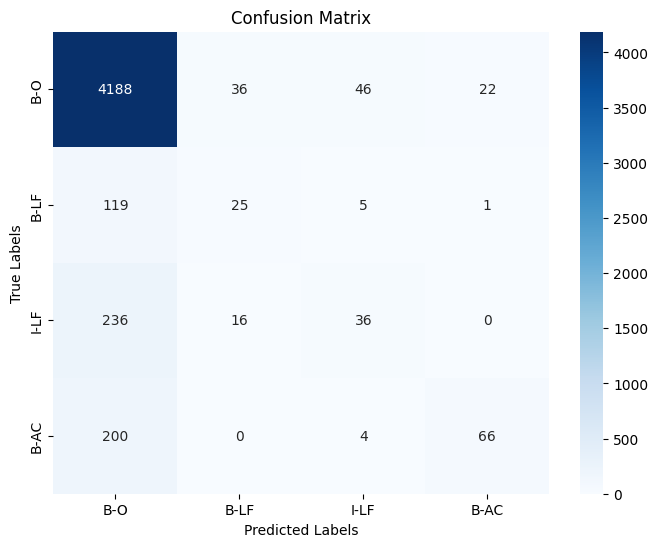

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, ffnn_test_pred_indices2)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# *lr = 0.0001, epoch = 15, batch size = 32, optimizer = adam*

In [ ]:
from tensorflow.keras.optimizers import Adam
custom_lr = 0.0001
optimizer1 = Adam(learning_rate=custom_lr)
ffnn_model.compile(optimizer=optimizer1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ffnn_model.fit(Train_X_Tfidf_array, Train_Y_1, epochs=15, batch_size=32, validation_data=(Val_X_Tfidf_array, Val_Y_1))

Epoch 1/15
1250/1250 [==============================] - 12s 9ms/step - loss: 0.3957 - accuracy: 0.8765 - val_loss: 0.4586 - val_accuracy: 0.8674
Epoch 2/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.3921 - accuracy: 0.8780 - val_loss: 0.4584 - val_accuracy: 0.8668
Epoch 3/15
1250/1250 [==============================] - 10s 8ms/step - loss: 0.3888 - accuracy: 0.8783 - val_loss: 0.4571 - val_accuracy: 0.8670
Epoch 4/15
1250/1250 [==============================] - 11s 8ms/step - loss: 0.3851 - accuracy: 0.8799 - val_loss: 0.4575 - val_accuracy: 0.8656
Epoch 5/15
1250/1250 [==============================] - 11s 9ms/step - loss: 0.3799 - accuracy: 0.8808 - val_loss: 0.4577 - val_accuracy: 0.8668
Epoch 6/15
1250/1250 [==============================] - 11s 9ms/step - loss: 0.3792 - accuracy: 0.8814 - val_loss: 0.4574 - val_accuracy: 0.8660
Epoch 7/15
1250/1250 [==============================] - 11s 9ms/step - loss: 0.3767 - accuracy: 0.8799 - val_loss: 0.4564 - val_ac

In [ ]:
ffnn_test_pred3 = ffnn_model.predict(Test_X_Tfidf_array)

157/157 [==============================] - 0s 3ms/step


In [ ]:
import numpy as np
ffnn_test_pred_indices3 = np.argmax(ffnn_test_pred3, axis=1)
ffnn_test_pred_labels3 = [[tolabel_map[int(num)] for num in ffnn_test_pred_indices3]]
print(ffnn_test_pred_labels3)

[['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O',

In [ ]:
test_results3 = metric.compute(predictions=ffnn_test_pred_labels3, references=Test_Y_1_list)
test_results3

{'AC': {'precision': 0.735632183908046,
  'recall': 0.23703703703703705,
  'f1': 0.3585434173669468,
  'number': 270},
 'LF': {'precision': 0.05660377358490566,
  'recall': 0.07894736842105263,
  'f1': 0.06593406593406592,
  'number': 152},
 'O': {'precision': 0.8886743886743886,
  'recall': 0.9652842497670084,
  'f1': 0.9253964708510164,
  'number': 4292},
 'overall_precision': 0.8504333803668616,
 'overall_recall': 0.894993635977938,
 'overall_f1': 0.8721447028423772,
 'overall_accuracy': 0.8602}

[[4143   36   91   22]
 [ 112   27   11    0]
 [ 205   15   67    1]
 [ 202    0    4   64]]


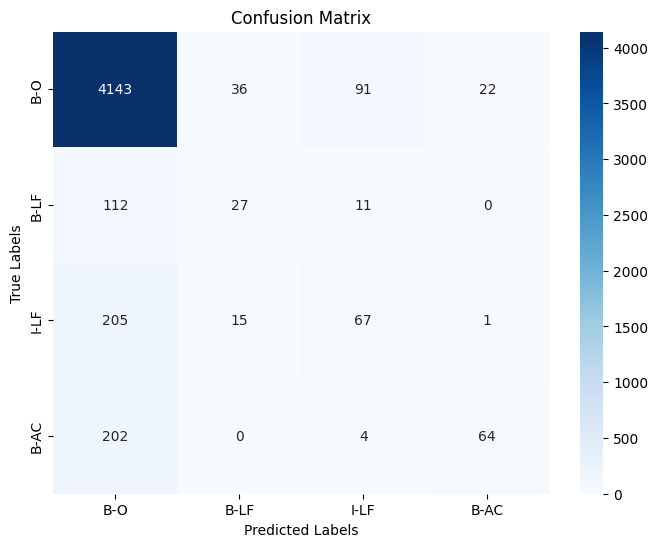

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, ffnn_test_pred_indices3)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# *lr = 2e-5, epoch = 15, batch size = 32, optimizer = adam*


In [ ]:
from tensorflow.keras.optimizers import Adam
custom_lr = 2e-5
optimizer2 = Adam(learning_rate=custom_lr)
ffnn_model.compile(optimizer=optimizer2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ffnn_model.fit(Train_X_Tfidf_array, Train_Y_1, epochs=15, batch_size=32, validation_data=(Val_X_Tfidf_array, Val_Y_1))

Epoch 1/15
1250/1250 [==============================] - 5s 3ms/step - loss: 0.3539 - accuracy: 0.8842 - val_loss: 0.4614 - val_accuracy: 0.8674
Epoch 2/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3543 - accuracy: 0.8842 - val_loss: 0.4613 - val_accuracy: 0.8670
Epoch 3/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3536 - accuracy: 0.8838 - val_loss: 0.4617 - val_accuracy: 0.8670
Epoch 4/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3535 - accuracy: 0.8837 - val_loss: 0.4619 - val_accuracy: 0.8668
Epoch 5/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3537 - accuracy: 0.8841 - val_loss: 0.4618 - val_accuracy: 0.8672
Epoch 6/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3522 - accuracy: 0.8850 - val_loss: 0.4619 - val_accuracy: 0.8668
Epoch 7/15
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3533 - accuracy: 0.8847 - val_loss: 0.4620 - val_accuracy:

In [ ]:
ffnn_test_pred4 = ffnn_model.predict(Test_X_Tfidf_array)

157/157 [==============================] - 0s 2ms/step


In [ ]:
import numpy as np
ffnn_test_pred_indices4 = np.argmax(ffnn_test_pred4, axis=1)
ffnn_test_pred_labels4 = [[tolabel_map[int(num)] for num in ffnn_test_pred_indices4]]
print(ffnn_test_pred_labels4)

[['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', '

In [ ]:
test_results4 = metric.compute(predictions=ffnn_test_pred_labels4, references=Test_Y_1_list)
test_results4

{'AC': {'precision': 0.7472527472527473,
  'recall': 0.2518518518518518,
  'f1': 0.3767313019390582,
  'number': 270},
 'LF': {'precision': 0.035897435897435895,
  'recall': 0.046052631578947366,
  'f1': 0.040345821325648415,
  'number': 152},
 'O': {'precision': 0.8879641485275288,
  'recall': 0.9694780987884436,
  'f1': 0.9269325016707507,
  'number': 4292},
 'overall_precision': 0.8519710378117458,
 'overall_recall': 0.8985999151463725,
 'overall_f1': 0.874664464175098,
 'overall_accuracy': 0.8626}

[[4161   34   75   22]
 [ 116   25    8    1]
 [ 212   17   59    0]
 [ 197    1    4   68]]


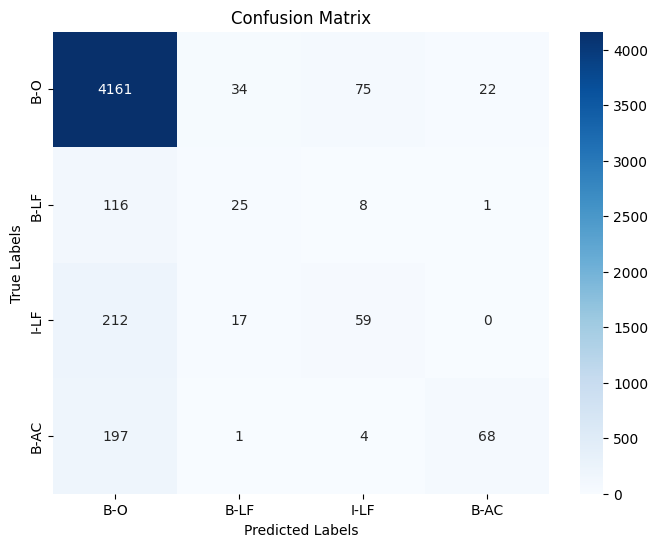

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, ffnn_test_pred_indices4)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# *lr = 0.01(default), epoch = 15, batch size = 32, optimizer = sgd*

In [ ]:
from tensorflow.keras.optimizers import SGD
optimizer3 = SGD()
ffnn_model.compile(optimizer=optimizer3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ffnn_model.fit(Train_X_Tfidf_array, Train_Y_1, epochs=15, batch_size=32, validation_data=(Val_X_Tfidf_array, Val_Y_1))

Epoch 1/15
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4203 - accuracy: 0.8701 - val_loss: 0.4595 - val_accuracy: 0.8704
Epoch 2/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4168 - accuracy: 0.8710 - val_loss: 0.4592 - val_accuracy: 0.8682
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4157 - accuracy: 0.8722 - val_loss: 0.4647 - val_accuracy: 0.8694
Epoch 4/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4129 - accuracy: 0.8728 - val_loss: 0.4636 - val_accuracy: 0.8686
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4117 - accuracy: 0.8727 - val_loss: 0.4592 - val_accuracy: 0.8688
Epoch 6/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4102 - accuracy: 0.8744 - val_loss: 0.4603 - val_accuracy: 0.8696
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4073 - accuracy: 0.8741 - val_loss: 0.4582 - val_accuracy:

In [ ]:
ffnn_test_pred5 = ffnn_model.predict(Test_X_Tfidf_array)

157/157 [==============================] - 0s 3ms/step


In [ ]:
import numpy as np
tolabel_map = {0:'B-O',1:'B-LF', 2:'I-LF', 3:'B-AC'}
ffnn_test_pred_indices5 = np.argmax(ffnn_test_pred5, axis=1)
ffnn_test_pred_labels5 = [[tolabel_map[int(num)] for num in ffnn_test_pred_indices5]]
print(ffnn_test_pred_labels5)

[['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', '

In [ ]:
test_results5 = metric.compute(predictions=ffnn_test_pred_labels5, references=Test_Y_1_list)
test_results5

{'AC': {'precision': 0.7303370786516854,
  'recall': 0.24074074074074073,
  'f1': 0.36211699164345407,
  'number': 270},
 'LF': {'precision': 0.04395604395604396,
  'recall': 0.05263157894736842,
  'f1': 0.04790419161676646,
  'number': 152},
 'O': {'precision': 0.8859817060199957,
  'recall': 0.9704100652376515,
  'f1': 0.9262759924385633,
  'number': 4292},
 'overall_precision': 0.8523732904263878,
 'overall_recall': 0.8990241832838354,
 'overall_f1': 0.8750774313442081,
 'overall_accuracy': 0.8618}

[[4165   24   81   22]
 [ 126   14    9    1]
 [ 209   13   65    1]
 [ 201    0    4   65]]


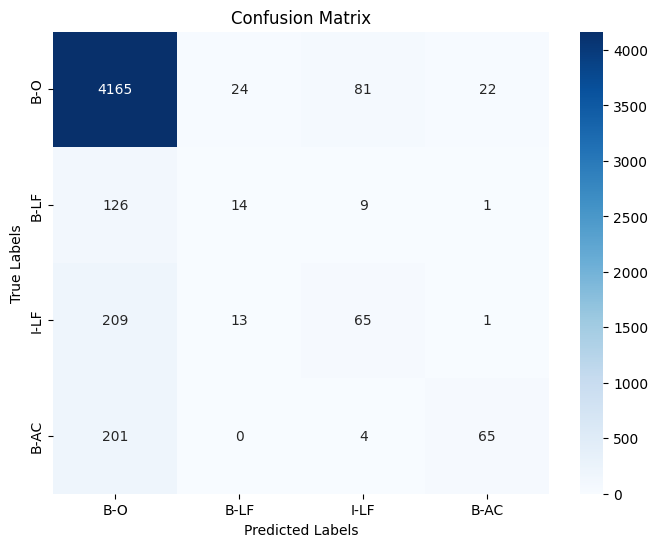

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, ffnn_test_pred_indices5)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# *lr = 2e-5, epoch = 15, batch size = 32, optimizer = sgd*

In [ ]:
from tensorflow.keras.optimizers import SGD
custom_lr = 2e-5
optimizer4 = SGD(learning_rate=custom_lr)
ffnn_model.compile(optimizer=optimizer4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ffnn_model.fit(Train_X_Tfidf_array, Train_Y_1, epochs=15, batch_size=32, validation_data=(Val_X_Tfidf_array, Val_Y_1))

Epoch 1/15
1250/1250 [==============================] - 12s 9ms/step - loss: 0.3951 - accuracy: 0.8768 - val_loss: 0.4553 - val_accuracy: 0.8678
Epoch 2/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.3953 - accuracy: 0.8756 - val_loss: 0.4556 - val_accuracy: 0.8672
Epoch 3/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.3963 - accuracy: 0.8765 - val_loss: 0.4559 - val_accuracy: 0.8674
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3961 - accuracy: 0.8767 - val_loss: 0.4561 - val_accuracy: 0.8674
Epoch 5/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.3946 - accuracy: 0.8760 - val_loss: 0.4564 - val_accuracy: 0.8674
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 0.3946 - accuracy: 0.8767 - val_loss: 0.4566 - val_accuracy: 0.8678
Epoch 7/15
1250/1250 [==============================] - 12s 10ms/step - loss: 0.3951 - accuracy: 0.8770 - val_loss: 0.4567 - val_accura

In [ ]:
ffnn_test_pred6 = ffnn_model.predict(Test_X_Tfidf_array)

157/157 [==============================] - 1s 5ms/step


In [ ]:
import numpy as np
tolabel_map = {0:'B-O',1:'B-LF', 2:'I-LF', 3:'B-AC'}
ffnn_test_pred_indices6 = np.argmax(ffnn_test_pred6, axis=1)
ffnn_test_pred_labels6 = [[tolabel_map[int(num)] for num in ffnn_test_pred_indices6]]
print(ffnn_test_pred_labels6)

[['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'I-LF', 'B-O', 'B-O', 'B-O', '

In [ ]:
test_results6 = metric.compute(predictions=ffnn_test_pred_labels6, references=Test_Y_1_list)
test_results6

{'AC': {'precision': 0.7441860465116279,
  'recall': 0.23703703703703705,
  'f1': 0.3595505617977528,
  'number': 270},
 'LF': {'precision': 0.04081632653061224,
  'recall': 0.05263157894736842,
  'f1': 0.04597701149425287,
  'number': 152},
 'O': {'precision': 0.8869936034115139,
  'recall': 0.9692451071761417,
  'f1': 0.9262970385214874,
  'number': 4292},
 'overall_precision': 0.8511665325824618,
 'overall_recall': 0.8977513788714467,
 'overall_f1': 0.8738385298368779,
 'overall_accuracy': 0.8616}

[[4160   28   83   21]
 [ 123   16   10    1]
 [ 205   15   68    0]
 [ 202    0    4   64]]


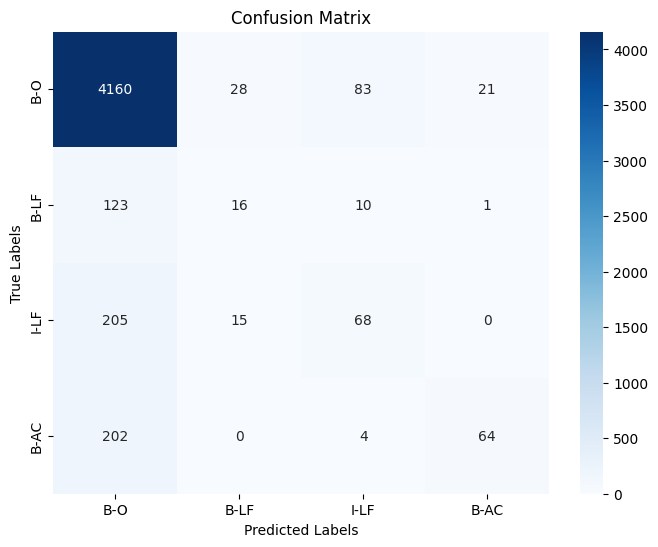

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(Test_Y_1, ffnn_test_pred_indices6)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC'], yticklabels=['B-O', 'B-LF', 'I-LF', 'B-AC']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Experimet 3: With Transformer based model DistilBert

# *Transformer based model DistilBert*

In [ ]:
from datasets import ClassLabel, Sequence
label_names = sorted(set(label for labels in datasets["train"]["ner_tags"] for label in labels))
# Cast to ClassLabel
raw_datasets = datasets.cast_column("ner_tags", Sequence(ClassLabel(names=label_names)))

Casting the dataset:   0%|          | 0/1072 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/126 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
ner_seq = raw_datasets["train"].features[f"ner_tags"]
print(ner_seq)
label_list = raw_datasets["train"].features[f"ner_tags"].feature.names
print(label_list)

Sequence(feature=ClassLabel(names=['B-AC', 'B-LF', 'B-O', 'I-LF'], id=None), length=-1, id=None)
['B-AC', 'B-LF', 'B-O', 'I-LF']


In [ ]:
task = "ner"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [ ]:
from transformers import AutoTokenizer

# dbert_tokenizer has a vocab attribute which contains the actual vocabulary.
dbert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import transformers
assert isinstance(dbert_tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
tokenized_input = dbert_tokenizer(datasets["train"]["tokens"], is_split_into_words=True)
# sample for 5 sentances
cnt = 0
for token in tokenized_input["input_ids"]:
  print(dbert_tokenizer.convert_ids_to_tokens(token))
  cnt+=1
  if cnt == 5:
    break

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


['[CLS]', 'for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'persons', 'empowerment', 'scale', '(', 'g', '##ype', '##s', ')', 'was', 'developed', '.', '[SEP]']
['[CLS]', 'the', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'st', '##oma', '##tal', 'conduct', '##ance', '(', 'gs', ',', 'mo', '##l', 'h', '##2', '##o', 'm', '-', '2', 's', '-', '1', ')', ',', 'trans', '##piration', 'rate', '(', 'e', ',', 'mm', '##ol', 'h', '##2', '##o', 'm', '-', '2', 's', '-', '1', ')', ',', 'net', 'photos', '##yn', '##the', '##tic', 'rate', '(', 'p', '##n', ',', 'μ', '##mo', '##l', 'm', '-', '2', 's', '-', '1', ')', 'and', 'inter', '##cellular', 'co', '##2', 'concentration', 'co', '##2', '(', 'ci', ',', 'μ', '##mo', '##l', 'm', '-', '2', 's', '-', '1', ')', '.', '[SEP]']
['[CLS]', 'minor', 'h', 'antigen', 'all', '##oi', '##mm', '##une', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'le', '##uk', '##oc', '##yte', 'antigen', '(', 'h', '##la', ')', '–', 'matc

In [ ]:
print(tokenized_input["input_ids"])
print(tokenized_input.word_ids())

[[101, 2005, 2023, 3800, 1996, 22836, 2402, 5381, 23011, 4094, 1006, 1043, 18863, 2015, 1007, 2001, 2764, 1012, 102], [101, 1996, 2206, 19389, 12955, 2020, 7594, 1024, 2358, 9626, 9080, 6204, 6651, 1006, 28177, 1010, 9587, 2140, 1044, 2475, 2080, 1049, 1011, 1016, 1055, 1011, 1015, 1007, 1010, 9099, 16781, 3446, 1006, 1041, 1010, 3461, 4747, 1044, 2475, 2080, 1049, 1011, 1016, 1055, 1011, 1015, 1007, 1010, 5658, 7760, 6038, 10760, 4588, 3446, 1006, 1052, 2078, 1010, 1166, 5302, 2140, 1049, 1011, 1016, 1055, 1011, 1015, 1007, 1998, 6970, 16882, 2522, 2475, 6693, 2522, 2475, 1006, 25022, 1010, 1166, 5302, 2140, 1049, 1011, 1016, 1055, 1011, 1015, 1007, 1012, 102], [101, 3576, 1044, 28873, 2035, 10448, 7382, 9816, 10960, 12192, 5258, 1999, 1996, 4292, 1997, 2529, 3393, 6968, 10085, 17250, 28873, 1006, 1044, 2721, 1007, 1516, 10349, 2035, 23924, 7416, 2278, 5024, 5812, 1998, 7872, 3526, 22291, 3370, 1006, 8040, 2102, 1007, 1031, 1017, 1010, 1018, 1033, 1012, 102], [101, 4958, 2072, 1027, 9

In [ ]:
example = datasets["train"][0]
print(example["tokens"])

['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']


In [ ]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(aligned_labels)
print(len(aligned_labels), len(tokenized_input["input_ids"]))

[-100, 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-AC', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', -100]
19 1072


In [ ]:
label_all_tokens = True

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = dbert_tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
print(datasets)
print(raw_datasets)
tokenized_datasets["train"]["labels"][0]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})
DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})


[-100, 2, 2, 2, 2, 1, 3, 3, 3, 3, 2, 0, 0, 0, 2, 2, 2, 2, -100]

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# Initialize DistilBERT model dbert_model for token classification from pre-trained checkpoint.
dbert_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dbertmodel_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{dbertmodel_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
#print(args)

In [ ]:
from transformers import DataCollatorForTokenClassification

dbertdata_collator = DataCollatorForTokenClassification(dbert_tokenizer)

In [ ]:
metric = load_metric("seqeval")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Check how seqeval metric works
dbert_labels = [label_list[i] for i in raw_datasets["train"][f"{task}_tags"][15]]
metric.compute(predictions=[dbert_labels], references=[dbert_labels])

{'AC': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'LF': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 13},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

dbert_trainer = Trainer(
    dbert_model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.304809,0.882733,0.901369,0.891954,0.879066
2,No log,0.247055,0.914427,0.914729,0.914578,0.909910
3,No log,0.231724,0.927527,0.920336,0.923918,0.919072
4,No log,0.232997,0.927687,0.926769,0.927228,0.923194
5,No log,0.233536,0.930772,0.926934,0.928849,0.924569
6,No log,0.246211,0.930093,0.921656,0.925855,0.920599
7,No log,0.254747,0.930186,0.929573,0.929880,0.924874
8,0.243500,0.259190,0.931332,0.926109,0.928713,0.923500
9,0.243500,0.266333,0.929871,0.927264,0.928566,0.922889
10,0.243500,0.270071,0.930818,0.927594,0.929203,0.923347


TrainOutput(global_step=670, training_loss=0.2043181035056043, metrics={'train_runtime': 51.2556, 'train_samples_per_second': 209.148, 'train_steps_per_second': 13.072, 'total_flos': 342993122244096.0, 'train_loss': 0.2043181035056043, 'epoch': 10.0})

In [ ]:
dbert_trainer.evaluate()

{'eval_loss': 0.27007073163986206,
 'eval_precision': 0.9308176100628931,
 'eval_recall': 0.9275936005277915,
 'eval_f1': 0.929202808756712,
 'eval_accuracy': 0.9233470758894488,
 'eval_runtime': 0.3515,
 'eval_samples_per_second': 358.514,
 'eval_steps_per_second': 22.763,
 'epoch': 10.0}

In [ ]:
predictions, labels, _ = dbert_trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("\nValidation data")
results

true_predictions 126

true labels 126

Validation data


{'AC': {'precision': 0.8234265734265734,
  'recall': 0.8365896980461812,
  'f1': 0.829955947136564,
  'number': 563},
 'LF': {'precision': 0.6234939759036144,
  'recall': 0.708904109589041,
  'f1': 0.6634615384615383,
  'number': 292},
 'O': {'precision': 0.9626313740755158,
  'recall': 0.9496927803379416,
  'f1': 0.9561183065919194,
  'number': 5208},
 'overall_precision': 0.9308176100628931,
 'overall_recall': 0.9275936005277915,
 'overall_f1': 0.929202808756712,
 'overall_accuracy': 0.9233470758894488}

In [ ]:
predictions, labels, _ = dbert_trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("Test data")
results

Test data


{'AC': {'precision': 0.7815442561205274,
  'recall': 0.7586837294332724,
  'f1': 0.7699443413729129,
  'number': 547},
 'LF': {'precision': 0.6901840490797546,
  'recall': 0.7450331125827815,
  'f1': 0.7165605095541402,
  'number': 302},
 'O': {'precision': 0.9601261127596439,
  'recall': 0.959236612933111,
  'f1': 0.9596811567337103,
  'number': 5397},
 'overall_precision': 0.9308689390302448,
 'overall_recall': 0.9313160422670509,
 'overall_f1': 0.9310924369747899,
 'overall_accuracy': 0.9273793414524132}

In [ ]:
# Flatten the lists of predictions and labels
flat_true_predictions = [p for sublist in true_predictions for p in sublist]
flat_true_labels = [l for sublist in true_labels for l in sublist]

[[ 415    2  125    5]
 [   1  236   45   18]
 [ 110   57 5177   53]
 [   5   17   45  340]]


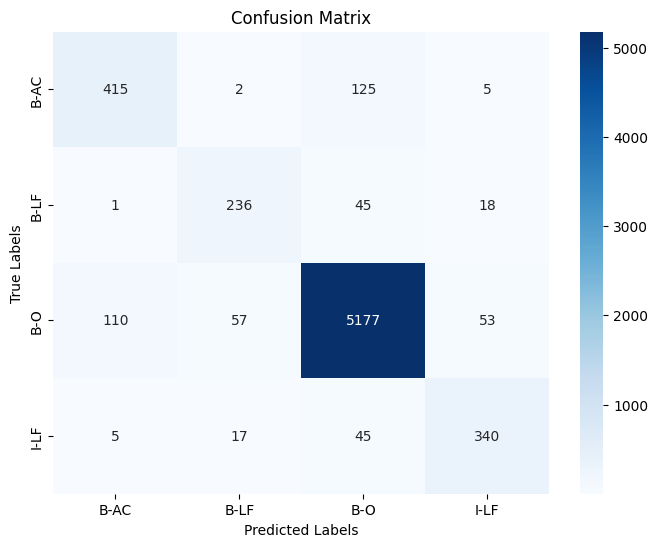

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_true_predictions)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Experiment 3 : Different optimizers on DistilBert

# Optimizer 1: SGD with lr=0.01 and lr=2e-5

In [ ]:
from torch.optim import SGD
sgd_optimizer= SGD(dbert_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

dbert_trainer_1 = Trainer(
    dbert_model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(sgd_optimizer, None), # Passing custom optimizer, None means using default scheduler setup
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer_1.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.283745,0.898745,0.897411,0.898077,0.892961
2,No log,0.238467,0.914083,0.914234,0.914158,0.910368
3,No log,0.222469,0.918189,0.920007,0.919097,0.916476
4,No log,0.226259,0.931097,0.924955,0.928016,0.923500
5,No log,0.222925,0.934649,0.929408,0.932021,0.927317
6,No log,0.237693,0.934014,0.919842,0.926874,0.921973
7,No log,0.238704,0.933455,0.927759,0.930598,0.926554
8,0.253700,0.242375,0.933234,0.929078,0.931151,0.927012
9,0.253700,0.243656,0.934350,0.929573,0.931955,0.927470
10,0.253700,0.247240,0.934173,0.929243,0.931702,0.927623


TrainOutput(global_step=670, training_loss=0.21758841044867216, metrics={'train_runtime': 137.1886, 'train_samples_per_second': 78.141, 'train_steps_per_second': 4.884, 'total_flos': 342993122244096.0, 'train_loss': 0.21758841044867216, 'epoch': 10.0})

In [ ]:
dbert_trainer_1.evaluate()

{'eval_loss': 0.2472403645515442,
 'eval_precision': 0.9341734372409219,
 'eval_recall': 0.9292429490351312,
 'eval_f1': 0.9317016702497106,
 'eval_accuracy': 0.9276225377920293,
 'eval_runtime': 1.6508,
 'eval_samples_per_second': 76.327,
 'eval_steps_per_second': 4.846,
 'epoch': 10.0}

In [ ]:
predictions, labels, _ = dbert_trainer_1.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

#print("true_predictions", len(true_predictions))
#print("\ntrue labels", len(true_labels))

results = metric.compute(predictions=true_predictions, references=true_labels)
print("\nValidation data")
results


Validation data


{'AC': {'precision': 0.8249097472924187,
  'recall': 0.8117229129662522,
  'f1': 0.8182632050134289,
  'number': 563},
 'LF': {'precision': 0.6512345679012346,
  'recall': 0.7226027397260274,
  'f1': 0.685064935064935,
  'number': 292},
 'O': {'precision': 0.9637104599262566,
  'recall': 0.9535330261136713,
  'f1': 0.958594730238394,
  'number': 5208},
 'overall_precision': 0.9341734372409219,
 'overall_recall': 0.9292429490351312,
 'overall_f1': 0.9317016702497106,
 'overall_accuracy': 0.9276225377920293}

In [ ]:
predictions1, labels1, _ = dbert_trainer_1.predict(tokenized_datasets["test"])
predictions1 = np.argmax(predictions1, axis=2)

# Remove ignored index (special tokens)
true_predictions1 = [
    [label_list[p] for (p, l) in zip(prediction1, label1) if l != -100]
    for prediction1, label1 in zip(predictions1, labels1)
]

true_labels1 = [
    [label_list[l] for (p, l) in zip(prediction1, label1) if l != -100]
    for prediction1, label1 in zip(predictions1, labels1)
]

results1 = metric.compute(predictions=true_predictions1, references=true_labels1)
print("Test data")
results1

Test data


{'AC': {'precision': 0.738819320214669,
  'recall': 0.7550274223034735,
  'f1': 0.7468354430379747,
  'number': 547},
 'LF': {'precision': 0.6826347305389222,
  'recall': 0.7549668874172185,
  'f1': 0.7169811320754716,
  'number': 302},
 'O': {'precision': 0.9622571001494769,
  'recall': 0.9542338336112656,
  'f1': 0.958228672434645,
  'number': 5397},
 'overall_precision': 0.9273018414731785,
 'overall_recall': 0.9271533781620237,
 'overall_f1': 0.9272276038747899,
 'overall_accuracy': 0.9239212148549091}

In [ ]:
# Flatten the lists of predictions and labels
flat_true_predictions1 = [p for sublist in true_predictions1 for p in sublist]
flat_true_labels1 = [l for sublist in true_labels1 for l in sublist]

[[ 413    1  128    5]
 [   0  241   39   20]
 [ 139   52 5150   56]
 [   7   24   35  341]]


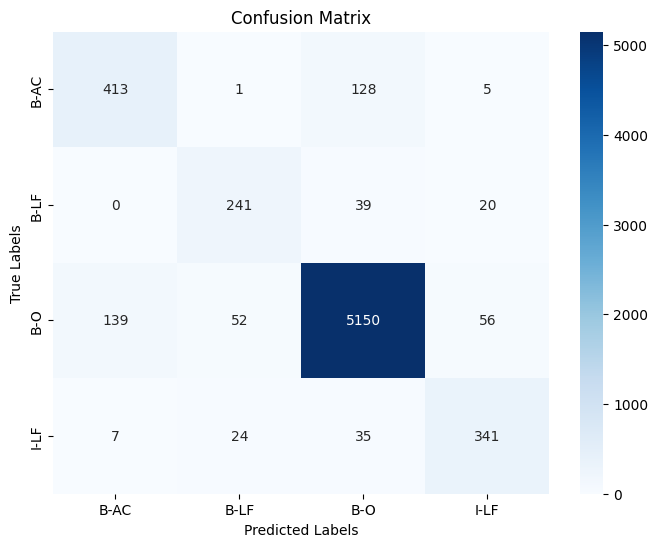

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels1, flat_true_predictions1)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Optimizer 1 - sgd with LR - 2e-5

In [ ]:
sgd_optimizer1= SGD(dbert_model.parameters(), lr=2e-5)

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

dbert_trainer_11 = Trainer(
    dbert_model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(sgd_optimizer1, None), # Passing custom optimizer, None means using default scheduler setup
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer_11.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.366375,0.936508,0.934191,0.935348,0.931440
2,No log,0.366426,0.936508,0.934191,0.935348,0.931440
3,No log,0.366428,0.936508,0.934191,0.935348,0.931440
4,No log,0.366454,0.936508,0.934191,0.935348,0.931440
5,No log,0.366480,0.936508,0.934191,0.935348,0.931593
6,No log,0.366485,0.936508,0.934191,0.935348,0.931593
7,No log,0.366495,0.936508,0.934191,0.935348,0.931593
8,0.010200,0.366512,0.936508,0.934191,0.935348,0.931593
9,0.010200,0.366514,0.936508,0.934191,0.935348,0.931593
10,0.010200,0.366515,0.936508,0.934191,0.935348,0.931593


Checkpoint destination directory distilbert-base-uncased-finetuned-ner/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=670, training_loss=0.011035383993120335, metrics={'train_runtime': 132.7804, 'train_samples_per_second': 80.735, 'train_steps_per_second': 5.046, 'total_flos': 342993122244096.0, 'train_loss': 0.011035383993120335, 'epoch': 10.0})

In [ ]:
dbert_trainer_11.evaluate()

{'eval_loss': 0.36651498079299927,
 'eval_precision': 0.9365079365079365,
 'eval_recall': 0.9341909945571499,
 'eval_f1': 0.9353480307158781,
 'eval_accuracy': 0.9315926095587113,
 'eval_runtime': 1.127,
 'eval_samples_per_second': 111.797,
 'eval_steps_per_second': 7.098,
 'epoch': 10.0}

In [ ]:
predictions11, labels11, _ = dbert_trainer_11.predict(tokenized_datasets["test"])
predictions11 = np.argmax(predictions11, axis=2)

# Remove ignored index (special tokens)
true_predictions11 = [
    [label_list[p] for (p, l) in zip(prediction11, label11) if l != -100]
    for prediction11, label11 in zip(predictions11, labels11)
]

true_labels11 = [
    [label_list[l] for (p, l) in zip(prediction11, label11) if l != -100]
    for prediction11, label11 in zip(predictions11, labels11)
]

results11 = metric.compute(predictions=true_predictions11, references=true_labels11)
print("Test data")
results11

Test data


{'AC': {'precision': 0.7401433691756273,
  'recall': 0.7550274223034735,
  'f1': 0.7475113122171947,
  'number': 547},
 'LF': {'precision': 0.6805970149253732,
  'recall': 0.7549668874172185,
  'f1': 0.7158555729984302,
  'number': 302},
 'O': {'precision': 0.9624369276770697,
  'recall': 0.9542338336112656,
  'f1': 0.9583178265723855,
  'number': 5397},
 'overall_precision': 0.9274503523382447,
 'overall_recall': 0.9271533781620237,
 'overall_f1': 0.9273018414731786,
 'overall_accuracy': 0.9242219215155616}

In [ ]:
# Flatten the lists of predictions and labels
flat_true_predictions11 = [p for sublist in true_predictions11 for p in sublist]
flat_true_labels11 = [l for sublist in true_labels11 for l in sublist]

[[ 413    1  128    5]
 [   0  241   39   20]
 [ 139   52 5150   56]
 [   6   24   34  343]]


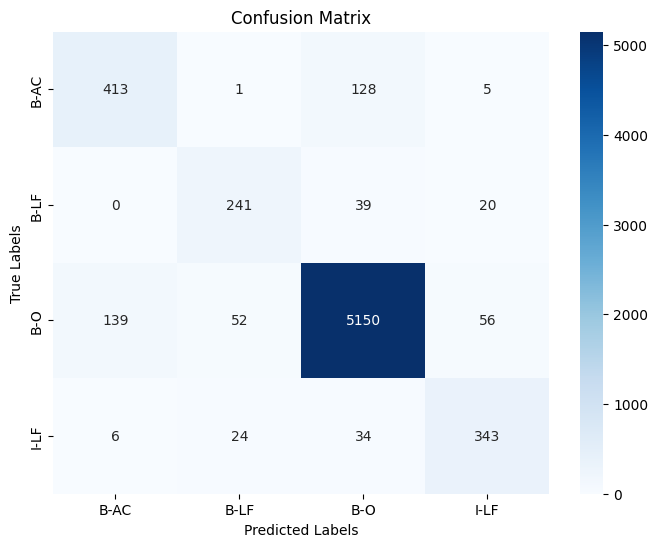

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels11, flat_true_predictions11)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optimerz 2: RMSProp

In [ ]:
from torch.optim import RMSprop
rmsprop_optimizer = RMSprop(dbert_model.parameters(), lr=2e-5, alpha=0.99)

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

dbert_trainer_2 = Trainer(
    dbert_model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(rmsprop_optimizer, None), # Passing custom optimizer, None means using default scheduler setup
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer_2.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.351030,0.925000,0.921491,0.923242,0.918155
2,No log,0.337281,0.927874,0.925120,0.926495,0.921057
3,No log,0.388302,0.929967,0.926439,0.928200,0.922736
4,No log,0.408529,0.930086,0.925944,0.928011,0.921515
5,No log,0.419537,0.927023,0.923965,0.925491,0.919988
6,No log,0.430486,0.926239,0.921656,0.923942,0.918003
7,No log,0.441575,0.927601,0.923470,0.925531,0.919377
8,0.037300,0.460671,0.927920,0.923635,0.925773,0.919835
9,0.037300,0.446839,0.927897,0.923305,0.925595,0.919682
10,0.037300,0.452643,0.927980,0.924460,0.926217,0.920140


Checkpoint destination directory distilbert-base-uncased-finetuned-ner/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=670, training_loss=0.030354729161333683, metrics={'train_runtime': 142.2942, 'train_samples_per_second': 75.337, 'train_steps_per_second': 4.709, 'total_flos': 342993122244096.0, 'train_loss': 0.030354729161333683, 'epoch': 10.0})

In [ ]:
dbert_trainer_2.evaluate()

{'eval_loss': 0.45264264941215515,
 'eval_precision': 0.9279801324503312,
 'eval_recall': 0.9244598383638463,
 'eval_f1': 0.9262166405023549,
 'eval_accuracy': 0.9201404794625133,
 'eval_runtime': 0.9794,
 'eval_samples_per_second': 128.652,
 'eval_steps_per_second': 8.168,
 'epoch': 10.0}

In [ ]:
predictions2, labels2, _ = dbert_trainer_2.predict(tokenized_datasets["test"])
predictions2 = np.argmax(predictions2, axis=2)

# Remove ignored index (special tokens)
true_predictions2 = [
    [label_list[p] for (p, l) in zip(prediction2, label2) if l != -100]
    for prediction2, label2 in zip(predictions2, labels2)
]

true_labels2 = [
    [label_list[l] for (p, l) in zip(prediction2, label2) if l != -100]
    for prediction2, label2 in zip(predictions2, labels2)
]

results2 = metric.compute(predictions=true_predictions2, references=true_labels2)
print("Test data")
results2

Test data


{'AC': {'precision': 0.7142857142857143,
  'recall': 0.7586837294332724,
  'f1': 0.7358156028368794,
  'number': 547},
 'LF': {'precision': 0.658753709198813,
  'recall': 0.7350993377483444,
  'f1': 0.6948356807511737,
  'number': 302},
 'O': {'precision': 0.9595788682083098,
  'recall': 0.9457105799518251,
  'f1': 0.9525942515864128,
  'number': 5397},
 'overall_precision': 0.9204745871412539,
 'overall_recall': 0.9191482548831252,
 'overall_f1': 0.91981094288232,
 'overall_accuracy': 0.9161028416779432}

In [ ]:
flat_true_predictions2 = [p for sublist in true_predictions2 for p in sublist]
flat_true_labels2 = [l for sublist in true_labels2 for l in sublist]

[[ 415    1  129    2]
 [   1  232   46   21]
 [ 159   71 5104   63]
 [   6   19   40  342]]


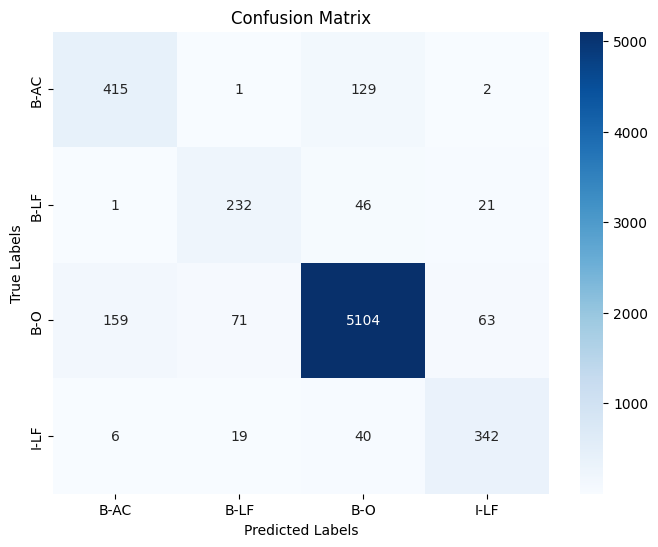

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels2, flat_true_predictions2)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# optimizer 3: AdaDelta


In [ ]:
from torch.optim import Adadelta
adadelta_optimizer = Adadelta(dbert_model.parameters(), lr=1.0, rho=0.9)

In [ ]:
dbert_trainer_3 = Trainer(
    dbert_model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(adadelta_optimizer, None), # Passing custom optimizer, None means using default scheduler setup
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer_3.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.268751,0.926716,0.917698,0.922184,0.916781
2,No log,0.604512,0.794103,0.795151,0.794627,0.798443
3,No log,0.300653,0.927321,0.917533,0.922401,0.916628
4,No log,0.318281,0.925575,0.935346,0.930435,0.924416
5,No log,0.377283,0.928464,0.920501,0.924466,0.919224
6,No log,0.355896,0.929952,0.928418,0.929185,0.924263
7,No log,0.398193,0.932419,0.930727,0.931572,0.925943
8,0.116700,0.416168,0.935804,0.932872,0.934336,0.929608
9,0.116700,0.427710,0.934556,0.932707,0.933631,0.928539
10,0.116700,0.436946,0.934955,0.931717,0.933333,0.927775


Checkpoint destination directory distilbert-base-uncased-finetuned-ner/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=670, training_loss=0.08833176902870633, metrics={'train_runtime': 157.2623, 'train_samples_per_second': 68.166, 'train_steps_per_second': 4.26, 'total_flos': 342993122244096.0, 'train_loss': 0.08833176902870633, 'epoch': 10.0})

In [ ]:
dbert_trainer_3.evaluate()

{'eval_loss': 0.43694642186164856,
 'eval_precision': 0.9349553128103277,
 'eval_recall': 0.9317169717961405,
 'eval_f1': 0.9333333333333333,
 'eval_accuracy': 0.9277752328599786,
 'eval_runtime': 0.7716,
 'eval_samples_per_second': 163.301,
 'eval_steps_per_second': 10.368,
 'epoch': 10.0}

In [ ]:
predictions3, labels3, _ = dbert_trainer_3.predict(tokenized_datasets["test"])
predictions3 = np.argmax(predictions3, axis=2)

# Remove ignored index (special tokens)
true_predictions3 = [
    [label_list[p] for (p, l) in zip(prediction3, label3) if l != -100]
    for prediction3, label3 in zip(predictions3, labels3)
]

true_labels3 = [
    [label_list[l] for (p, l) in zip(prediction3, label3) if l != -100]
    for prediction3, label3 in zip(predictions3, labels3)
]

results3 = metric.compute(predictions=true_predictions3, references=true_labels3)
print("Test data")
results3

Test data


{'AC': {'precision': 0.7417218543046358,
  'recall': 0.8190127970749543,
  'f1': 0.7784535186794093,
  'number': 547},
 'LF': {'precision': 0.6605504587155964,
  'recall': 0.7152317880794702,
  'f1': 0.6868044515103338,
  'number': 302},
 'O': {'precision': 0.9648393194706995,
  'recall': 0.9457105799518251,
  'f1': 0.9551791896696922,
  'number': 5397},
 'overall_precision': 0.9271821250602797,
 'overall_recall': 0.9234710214537304,
 'overall_f1': 0.9253228523301517,
 'overall_accuracy': 0.92106450157871}

In [ ]:
flat_true_predictions3 = [p for sublist in true_predictions3 for p in sublist]
flat_true_labels3 = [l for sublist in true_labels3 for l in sublist]

[[ 448    1   96    2]
 [   0  225   50   25]
 [ 151   66 5104   76]
 [   5   13   40  349]]


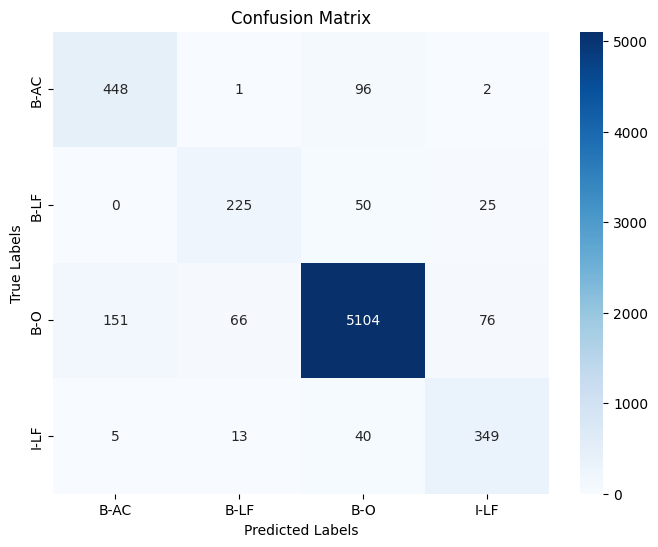

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels3, flat_true_predictions3)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Experiment 4 : LRs, Batch size, epoch on DistilBert

# LR - 3e-5, epoch - 15, batch size - 16

In [ ]:
# LR to 3e-5, epochs to 15
args_1 = TrainingArguments(
    f"{dbertmodel_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
dbert_trainer_m1 = Trainer(
    dbert_model,
    args_1,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer_m1.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.614359,0.931563,0.931717,0.931640,0.925027
2,No log,0.594159,0.932049,0.925285,0.928654,0.923347
3,No log,0.526449,0.931694,0.931387,0.931541,0.924721
4,No log,0.552975,0.933598,0.929903,0.931747,0.926554
5,No log,0.571345,0.929738,0.929738,0.929738,0.923194
6,No log,0.575226,0.930306,0.929078,0.929691,0.923500
7,No log,0.591169,0.932363,0.929903,0.931131,0.925332
8,0.001300,0.608455,0.930390,0.928088,0.929238,0.923652
9,0.001300,0.618252,0.931434,0.927594,0.929510,0.924111
10,0.001300,0.613952,0.931897,0.927594,0.929740,0.924263


Checkpoint destination directory distilbert-base-uncased-finetuned-ner/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1005, training_loss=0.00092558237651319, metrics={'train_runtime': 240.8083, 'train_samples_per_second': 66.775, 'train_steps_per_second': 4.173, 'total_flos': 514150789633152.0, 'train_loss': 0.00092558237651319, 'epoch': 15.0})

In [ ]:
dbert_trainer_m1.evaluate()

{'eval_loss': 0.5959590077400208,
 'eval_precision': 0.9306129192136131,
 'eval_recall': 0.9290780141843972,
 'eval_f1': 0.9298448332783097,
 'eval_accuracy': 0.923957856161246,
 'eval_runtime': 1.5143,
 'eval_samples_per_second': 83.208,
 'eval_steps_per_second': 5.283}

In [ ]:
predictions, labels, _ = dbert_trainer_m1.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

#print("true_predictions", len(true_predictions))
#print("\ntrue labels", len(true_labels))

results = metric.compute(predictions=true_predictions, references=true_labels)
print("\nValidation data")
results


Validation data


{'AC': {'precision': 0.7870216306156406,
  'recall': 0.8401420959147424,
  'f1': 0.8127147766323025,
  'number': 563},
 'LF': {'precision': 0.6984126984126984,
  'recall': 0.7534246575342466,
  'f1': 0.7248764415156507,
  'number': 292},
 'O': {'precision': 0.9616507689312829,
  'recall': 0.9485407066052227,
  'f1': 0.9550507491541809,
  'number': 5208},
 'overall_precision': 0.9306129192136131,
 'overall_recall': 0.9290780141843972,
 'overall_f1': 0.9298448332783097,
 'overall_accuracy': 0.923957856161246}

In [ ]:
predictions, labels, _ = dbert_trainer_m1.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("Test data")
results

Test data


{'AC': {'precision': 0.758147512864494,
  'recall': 0.8080438756855576,
  'f1': 0.7823008849557521,
  'number': 547},
 'LF': {'precision': 0.6686046511627907,
  'recall': 0.7615894039735099,
  'f1': 0.7120743034055727,
  'number': 302},
 'O': {'precision': 0.9629001883239171,
  'recall': 0.9473781730591069,
  'f1': 0.9550761184271972,
  'number': 5397},
 'overall_precision': 0.9275292608625942,
 'overall_recall': 0.9261927633685558,
 'overall_f1': 0.9268605303212369,
 'overall_accuracy': 0.921665914900015}

In [ ]:
flat_true_predictions = [p for sublist in true_predictions for p in sublist]
flat_true_labels = [l for sublist in true_labels for l in sublist]

[[ 442    2  101    2]
 [   0  237   46   17]
 [ 138   68 5113   78]
 [   3   16   50  338]]


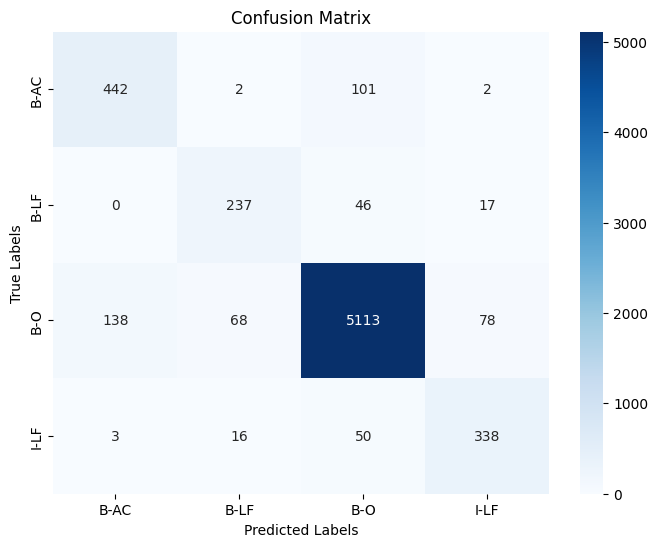

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_true_predictions)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# LR - 2.5e-5, epoch - 13, batch size - 16

In [ ]:
args_2 = TrainingArguments(
    f"{dbertmodel_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2.5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=13,
    weight_decay=0.01,
    push_to_hub=True,
    #early_stopping_patience=3  # Adding early stopping
)

In [ ]:
dbert_trainer_m2 = Trainer(
    dbert_model,
    args_2,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer_m2.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.283371,0.893399,0.904008,0.898672,0.890060
2,No log,0.236757,0.919595,0.914894,0.917239,0.911895
3,No log,0.227866,0.932401,0.923635,0.927997,0.922584
4,No log,0.241408,0.930397,0.930397,0.930397,0.925790
5,No log,0.249612,0.928903,0.924460,0.926676,0.921362
6,No log,0.271204,0.926903,0.916048,0.921443,0.916781
7,No log,0.285177,0.929151,0.925779,0.927462,0.923652
8,0.209600,0.292504,0.930306,0.929078,0.929691,0.925943
9,0.209600,0.312192,0.931421,0.931882,0.931651,0.926096
10,0.209600,0.322735,0.927450,0.925614,0.926531,0.922584


TrainOutput(global_step=871, training_loss=0.13808534011227666, metrics={'train_runtime': 63.8008, 'train_samples_per_second': 218.43, 'train_steps_per_second': 13.652, 'total_flos': 445616677485312.0, 'train_loss': 0.13808534011227666, 'epoch': 13.0})

In [ ]:
dbert_trainer_m2.evaluate()

{'eval_loss': 0.3376466631889343,
 'eval_precision': 0.931694439861409,
 'eval_recall': 0.9313871020946726,
 'eval_f1': 0.9315407456285054,
 'eval_accuracy': 0.9268590624522828,
 'eval_runtime': 0.3414,
 'eval_samples_per_second': 369.075,
 'eval_steps_per_second': 23.433,
 'epoch': 13.0}

In [ ]:
predictions, labels, _ = dbert_trainer_m2.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

#print("true_predictions", len(true_predictions))
#print("\ntrue labels", len(true_labels))

results = metric.compute(predictions=true_predictions, references=true_labels)
print("\nValidation data")
results


Validation data


{'AC': {'precision': 0.8266199649737302,
  'recall': 0.8383658969804618,
  'f1': 0.8324514991181657,
  'number': 563},
 'LF': {'precision': 0.6342182890855457,
  'recall': 0.7363013698630136,
  'f1': 0.6814580031695721,
  'number': 292},
 'O': {'precision': 0.9629198213939041,
  'recall': 0.9523809523809523,
  'f1': 0.9576213920262573,
  'number': 5208},
 'overall_precision': 0.931694439861409,
 'overall_recall': 0.9313871020946726,
 'overall_f1': 0.9315407456285054,
 'overall_accuracy': 0.9268590624522828}

In [ ]:
predictions, labels, _ = dbert_trainer_m2.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("Test data")
results

Test data


{'AC': {'precision': 0.7391304347826086,
  'recall': 0.7769652650822669,
  'f1': 0.7575757575757577,
  'number': 547},
 'LF': {'precision': 0.6911764705882353,
  'recall': 0.7781456953642384,
  'f1': 0.7320872274143302,
  'number': 302},
 'O': {'precision': 0.9647610121836926,
  'recall': 0.9536779692421716,
  'f1': 0.9591874767051808,
  'number': 5397},
 'overall_precision': 0.92912,
 'overall_recall': 0.9297150176112712,
 'overall_f1': 0.9294174135723431,
 'overall_accuracy': 0.9257254548188243}

In [ ]:
flat_true_predictions = [p for sublist in true_predictions for p in sublist]
flat_true_labels = [l for sublist in true_labels for l in sublist]

[[ 425    1  115    6]
 [   2  246   35   17]
 [ 142   55 5147   53]
 [   6   24   38  339]]


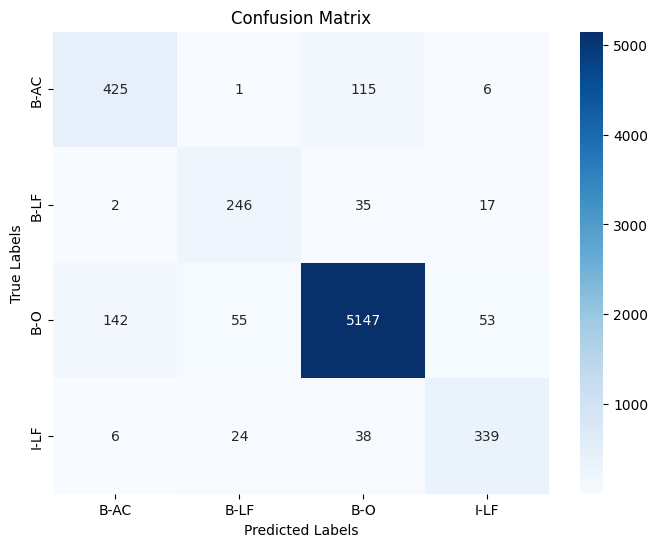

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_true_predictions)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# LR - 1e-5, epoch - 15, batch size - 16

In [ ]:
args_3 = TrainingArguments(
    f"{dbertmodel_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    weight_decay=0.01,
    push_to_hub=True,
    #early_stopping_patience=3  # Adding early stopping
)

In [ ]:
dbert_trainer_m3 = Trainer(
    dbert_model,
    args_3,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
dbert_trainer_m3.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.361254,0.927926,0.932212,0.930064,0.924721
2,No log,0.372230,0.931466,0.932542,0.932004,0.927623
3,No log,0.386907,0.931518,0.931057,0.931288,0.926096
4,No log,0.401735,0.929466,0.930233,0.929849,0.924721
5,No log,0.413586,0.930590,0.928748,0.929668,0.925179
6,No log,0.407905,0.928524,0.929903,0.929213,0.924263
7,No log,0.427723,0.929431,0.929738,0.929584,0.924721
8,0.019000,0.436509,0.928607,0.926769,0.927687,0.922736
9,0.019000,0.436855,0.929371,0.931057,0.930213,0.925332
10,0.019000,0.442520,0.929573,0.929573,0.929573,0.924874


Checkpoint destination directory distilbert-base-uncased-finetuned-ner/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1005, training_loss=0.013994880691541369, metrics={'train_runtime': 77.0349, 'train_samples_per_second': 208.737, 'train_steps_per_second': 13.046, 'total_flos': 514150789633152.0, 'train_loss': 0.013994880691541369, 'epoch': 15.0})

In [ ]:
dbert_trainer_m3.evaluate()

{'eval_loss': 0.4544292092323303,
 'eval_precision': 0.9292429490351312,
 'eval_recall': 0.9292429490351312,
 'eval_f1': 0.9292429490351312,
 'eval_accuracy': 0.9241105512291953,
 'eval_runtime': 0.344,
 'eval_samples_per_second': 366.273,
 'eval_steps_per_second': 23.255,
 'epoch': 15.0}

In [ ]:
predictions, labels, _ = dbert_trainer_m3.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("\nValidation data")
results


Validation data


{'AC': {'precision': 0.8116438356164384,
  'recall': 0.8419182948490231,
  'f1': 0.8265039232781168,
  'number': 563},
 'LF': {'precision': 0.6329479768786127,
  'recall': 0.75,
  'f1': 0.6865203761755485,
  'number': 292},
 'O': {'precision': 0.9625949736995909,
  'recall': 0.9487327188940092,
  'f1': 0.9556135770234987,
  'number': 5208},
 'overall_precision': 0.9292429490351312,
 'overall_recall': 0.9292429490351312,
 'overall_f1': 0.9292429490351312,
 'overall_accuracy': 0.9241105512291953}

In [ ]:
predictions, labels, _ = dbert_trainer_m3.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("Test data")
results

Test data


{'AC': {'precision': 0.730185497470489,
  'recall': 0.7915904936014625,
  'f1': 0.7596491228070175,
  'number': 547},
 'LF': {'precision': 0.6831395348837209,
  'recall': 0.7781456953642384,
  'f1': 0.7275541795665635,
  'number': 302},
 'O': {'precision': 0.9681071900358558,
  'recall': 0.9505280711506392,
  'f1': 0.9592370979805535,
  'number': 5397},
 'overall_precision': 0.9297626683771648,
 'overall_recall': 0.9282740954210695,
 'overall_f1': 0.9290177856112803,
 'overall_accuracy': 0.925575101488498}

In [ ]:
flat_true_predictions = [p for sublist in true_predictions for p in sublist]
flat_true_labels = [l for sublist in true_labels for l in sublist]

[[ 433    1  107    6]
 [   2  245   33   20]
 [ 152   56 5130   59]
 [   6   24   29  348]]


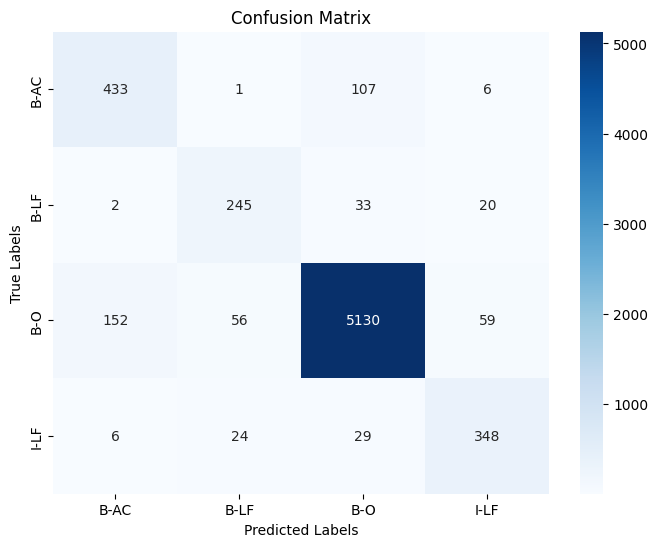

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_true_predictions)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# LR - 1e-5, epoch - 15 batch size - 32

In [ ]:
new_batch_size = 32

In [ ]:
args_4 = TrainingArguments(
    f"{dbertmodel_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=new_batch_size,
    per_device_eval_batch_size=new_batch_size,
    num_train_epochs=15,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
dbert_trainer_m4 = Trainer(
    dbert_model,
    args_4,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
#dbert_trainer_m4.train()

'''RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 14.75 GiB total capacity; 9.19 GiB already allocated;
 31.06 MiB free; 9.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb
  to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF'''

'RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 14.75 GiB total capacity; 9.19 GiB already allocated;\n 31.06 MiB free; 9.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb\n  to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF'

In [ ]:
dbert_trainer_m4.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.451590,0.928067,0.932047,0.930053,0.924874
2,No log,0.456798,0.928748,0.928748,0.928748,0.923042
3,No log,0.454170,0.926318,0.924790,0.925553,0.921515
4,No log,0.457004,0.928489,0.927264,0.927876,0.923958
5,No log,0.449207,0.931080,0.931387,0.931234,0.926859
6,No log,0.468044,0.929340,0.926274,0.927804,0.922736
7,No log,0.466998,0.929206,0.930892,0.930049,0.925332
8,No log,0.473613,0.928819,0.927594,0.928206,0.923805
9,No log,0.472530,0.929995,0.931222,0.930608,0.925179
10,No log,0.478049,0.927840,0.926769,0.927304,0.922278


Checkpoint destination directory distilbert-base-uncased-finetuned-ner/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=510, training_loss=0.007132860112423991, metrics={'train_runtime': 76.4051, 'train_samples_per_second': 210.457, 'train_steps_per_second': 6.675, 'total_flos': 622653946988928.0, 'train_loss': 0.007132860112423991, 'epoch': 15.0})

In [ ]:
dbert_trainer_m4.evaluate()

{'eval_loss': 0.4748474955558777,
 'eval_precision': 0.9291014014839242,
 'eval_recall': 0.929407883885865,
 'eval_f1': 0.929254617414248,
 'eval_accuracy': 0.9242632462971446,
 'eval_runtime': 0.3941,
 'eval_samples_per_second': 319.718,
 'eval_steps_per_second': 10.15,
 'epoch': 15.0}

In [ ]:
predictions, labels, _ = dbert_trainer_m4.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("\nValidation data")
results


Validation data


{'AC': {'precision': 0.8088737201365188,
  'recall': 0.8419182948490231,
  'f1': 0.825065274151436,
  'number': 563},
 'LF': {'precision': 0.6308139534883721,
  'recall': 0.7431506849315068,
  'f1': 0.6823899371069183,
  'number': 292},
 'O': {'precision': 0.9628042843232717,
  'recall': 0.9493087557603687,
  'f1': 0.9560088949047665,
  'number': 5208},
 'overall_precision': 0.9291014014839242,
 'overall_recall': 0.929407883885865,
 'overall_f1': 0.929254617414248,
 'overall_accuracy': 0.9242632462971446}

In [ ]:
predictions, labels, _ = dbert_trainer_m4.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
print("Test data")
results

Test data


{'AC': {'precision': 0.7303754266211604,
  'recall': 0.7824497257769653,
  'f1': 0.7555163283318624,
  'number': 547},
 'LF': {'precision': 0.6834319526627219,
  'recall': 0.7649006622516556,
  'f1': 0.721875,
  'number': 302},
 'O': {'precision': 0.9668174962292609,
  'recall': 0.9501574949045766,
  'f1': 0.9584151013923933,
  'number': 5397},
 'overall_precision': 0.9291907514450867,
 'overall_recall': 0.9265129682997119,
 'overall_f1': 0.9278499278499279,
 'overall_accuracy': 0.9239212148549091}

[[ 433    1  107    6]
 [   2  245   33   20]
 [ 152   56 5130   59]
 [   6   24   29  348]]


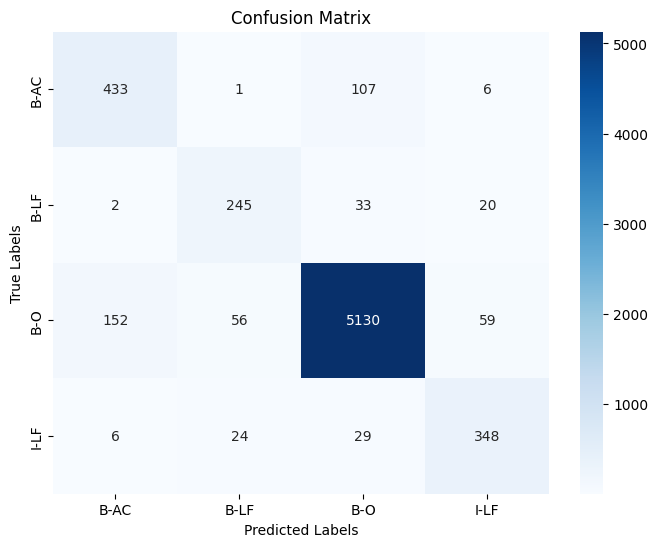

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_true_predictions)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF'], yticklabels=['B-AC', 'B-LF', 'B-O', 'I-LF']) #label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# LR - 3e-5, epoch - 15 batch size - 32

In [ ]:
new_batch_size = 32

In [ ]:
args_4 = TrainingArguments(
    f"{dbertmodel_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=new_batch_size,
    per_device_eval_batch_size=new_batch_size,
    num_train_epochs=30,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
dbert_trainer_m4 = Trainer(
    dbert_model,
    args_4,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=dbertdata_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
#dbert_trainer_m4.train()

'''RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 14.75 GiB total capacity; 9.19 GiB already allocated;
 31.06 MiB free; 9.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb
  to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF'''

'RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 14.75 GiB total capacity; 9.19 GiB already allocated;\n 31.06 MiB free; 9.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb\n  to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF'

# Experiment 5: RNN and LSTM with spacy and Glove

# converting the datasets into strings with spacy tokenizer for RNN and LSTM

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  1.11.0+cu113
torchtext Version:  0.12.0
Using GPU.


In [ ]:
cw_train = []
for data in train_dataset:
  #cw_train_data.append((data['ner_tags'], data['tokens']))
  cw_train.append((" ".join(data['ner_tags']), " ".join(data['tokens'])))
  #cw_train.append((data['ner_tags'], " ".join(data['tokens'])))
print(cw_train[:2])

cw_valid = []
for data in val_dataset:
  #cw_valid_data.append((data['ner_tags'], data['tokens']))
  cw_valid.append((" ".join(data['ner_tags']), " ".join(data['tokens'])))
print(cw_valid[:2])

cw_test = []
for data in test_dataset:
  #cw_test_data.append((data['ner_tags'], data['tokens']))
  cw_test.append((" ".join(data['ner_tags']), " ".join(data['tokens'])))
print(cw_test[:2])

[('B-O B-O B-O B-O B-LF I-LF I-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O', 'For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .'), ('B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-AC B-O B-AC B-O B-O B-O B-O B-O B-O', 'The following physiological traits were measured : stomatal conductance ( gs , mol H2O m-2 s-1 ) , transpiration rate ( E , mmol H2O m-2 s-1 ) , net photosynthetic rate ( PN , μmol m-2 s-1 ) and intercellular CO2 concentration CO2 ( Ci , μmol m-2 s-1 ) .')]
[('B-O B-LF I-LF I-LF I-LF B-O B-AC B-O B-LF I-LF I-LF I-LF I-LF I-LF I-LF I-LF B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O', '= Manual Ability Classification System ; QUEST = Quest - Quality of upper extremity skills test ; Cont = control ; M = male , 

In [ ]:
import torch
import torchtext
from torchtext.data.utils import get_tokenizer

class SpacyTokenizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    def forward(self, input):
        if isinstance(input, list):
            tokens = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif isinstance(input, str):
            return self.tokenizer(input)
        raise ValueError(f"Type {type(input)} is not supported.")

In [ ]:
from torchtext.vocab import build_vocab_from_iterator, vocab
from torchtext.data.utils import get_tokenizer
from collections import OrderedDict

tokenizer = SpacyTokenizer()
MAX_VOCAB_SIZE = 1_000

def _process_texts_for_vocab(data):
    for line in data:
        yield tokenizer(line[1])

def _get_labels_for_vocab(data):
    for line in data:
        yield [line[0]]

# tokenizing
text_vocab = build_vocab_from_iterator(_process_texts_for_vocab(cw_train), specials=('<unk>', '<pad>'), max_tokens=MAX_VOCAB_SIZE)
label_vocab = vocab(OrderedDict([("B-O", 1), ("B-LF", 1), ("I-LF", 1), ("B-AC", 1)]))

text_vocab.set_default_index(text_vocab["<unk>"])

In [ ]:
print(len(text_vocab))

1000


In [ ]:
text_vocab.get_itos()[:10]

['<unk>', '<pad>', ',', '(', ')', 'the', '.', 'of', '-', 'and']

In [ ]:
label_vocab.get_stoi()

{'B-AC': 3, 'I-LF': 2, 'B-LF': 1, 'B-O': 0}

In [ ]:
import torch
import torchtext
from torchtext.data.utils import get_tokenizer

import torchtext.transforms as T
import torch.nn.functional as F

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

In [ ]:
import torchtext.transforms as T

class LabelTransform(torch.nn.Module):
    def forward(self, input):
        input = input[0]

        label_tokens = input.split()
        label_indices = [label_vocab[token] for token in label_tokens]
        return label_indices

label_transform = T.Sequential(
    LabelTransform(),
    T.ToTensor(padding_value=0),
)

In [ ]:
for i in range(3):
  t = text_transform([cw_train[i][1]])
  l = label_transform([cw_train[i][0]])
  print(f"text: {t} size: {t.size()}")
  print(f"label: {l} size: {l.size()}" )

text: tensor([[254,  60,   0,   5,   0,   0,   0,   0,   0,   3,   0,   4,  19, 312,
           6]]) size: torch.Size([1, 15])
label: tensor([0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 3, 0, 0, 0, 0]) size: torch.Size([15])
text: tensor([[ 26, 235,   0,   0,  18, 184,  20,   0,   0,   3,   0,   2,   0,   0,
           0,   0,   4,   2,   0,  76,   3, 196,   2,   0,   0,   0,   0,   4,
           2,   0,   0,  76,   3,   0,   2,   0,   0,   0,   4,   9,   0,   0,
         310,   0,   3,   0,   2,   0,   0,   0,   4,   6]]) size: torch.Size([1, 52])
label: tensor([0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0,
        0, 0, 0, 0, 0, 1, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 0, 3, 0, 0,
        0, 0, 0, 0]) size: torch.Size([52])
text: tensor([[  0, 498, 382,   0, 838,   0,   0,  11,   5,   0,   7, 106,   0, 382,
           3,   0,   0,   0,   0,   9, 331,  42, 862,   3,   0,   4,  14,   0,
          13,   6]]) size: torch.Size([1, 30])
label: tensor([0, 3, 0, 0, 0, 0, 0, 0

In [ ]:
import torchtext.transforms as T

class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[0], list):
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
for i in range(3):
  print(cw_train[i][1])
  l = lengths_transform([cw_train[i][1]])
  print(f"length {l} size  {l.size()}")


For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .
length tensor([15]) size  torch.Size([1])
The following physiological traits were measured : stomatal conductance ( gs , mol H2O m-2 s-1 ) , transpiration rate ( E , mmol H2O m-2 s-1 ) , net photosynthetic rate ( PN , μmol m-2 s-1 ) and intercellular CO2 concentration CO2 ( Ci , μmol m-2 s-1 ) .
length tensor([52]) size  torch.Size([1])
Minor H antigen alloimmune responses readily occur in the setting of human leukocyte antigen ( HLA)–matched allogeneic solid organ and stem cell transplantation ( SCT ) [ 3,4 ] .
length tensor([30]) size  torch.Size([1])


In [ ]:
sample_label, sample_text = cw_train[0]

print(f"Text before any processing: {sample_text}")
print(f"Label before any processing: {sample_label}\n")

# Text Processing Pipeline
tokenizer = SpacyTokenizer()
sample_text = tokenizer(sample_text)
print(f"Text after Tokenizer: {sample_text}\n")

vocab_transform = T.VocabTransform(text_vocab)
sample_text = vocab_transform(sample_text)
print(f"Text after Vocab Transform: {sample_text}\n")

tensor_transform = T.ToTensor(padding_value=text_vocab["<pad>"])
sample_text = tensor_transform(sample_text)
print(f"Text after Tensor Transform: {sample_text}\n")

# Label Processing Pipeline
print(f"Label after label transform: {label_transform([sample_label])}\n")

# Length Processing Pipeline
print(f"Text after length transform: {lengths_transform([cw_train[0][1]])}")

Text before any processing: For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .
Label before any processing: B-O B-O B-O B-O B-LF I-LF I-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O

Text after Tokenizer: ['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']

Text after Vocab Transform: [254, 60, 0, 5, 0, 0, 0, 0, 0, 3, 0, 4, 19, 312, 6]

Text after Tensor Transform: tensor([254,  60,   0,   5,   0,   0,   0,   0,   0,   3,   0,   4,  19, 312,
          6])

Label after label transform: tensor([0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 3, 0, 0, 0, 0])

Text after length transform: tensor([15])


In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

BATCH_SIZE = 64

def collate_batch(batch):
    labels, texts = zip(*batch)

    lengths = lengths_transform(list(texts))
    texts = text_transform(list(texts))
    labels = label_transform(list(labels))

    labels = F.pad(labels, (0, 64 - labels.size(0)), value=0)

    return labels.float().to(DEVICE), texts.to(DEVICE), lengths.cpu()


def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

train_dataloader = _get_dataloader(cw_train)
valid_dataloader = _get_dataloader(cw_valid)
test_dataloader = _get_dataloader(cw_test)

In [ ]:
print(train_dataloader.dataset[:2])
print(train_dataloader.batch_size)
print(train_dataloader.batch_sampler)
print(train_dataloader.sampler)

[('B-O B-O B-O B-O B-LF I-LF I-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O', 'For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .'), ('B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-AC B-O B-AC B-O B-O B-O B-O B-O B-O', 'The following physiological traits were measured : stomatal conductance ( gs , mol H2O m-2 s-1 ) , transpiration rate ( E , mmol H2O m-2 s-1 ) , net photosynthetic rate ( PN , μmol m-2 s-1 ) and intercellular CO2 concentration CO2 ( Ci , μmol m-2 s-1 ) .')]
64
153


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


In [ ]:
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 191,905 trainable parameters


In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for batch in tqdm(iterator, desc="\tTraining"):
        optimizer.zero_grad()
        labels, texts, lengths = batch  # to match the order in collate_batch
        print(labels.size(), texts.size(), lengths.size())
        if lengths.size() != torch.Size([64]):
          continue
        elif labels.size() != torch.Size([64]):
          continue
        elif texts.size()[0] != 64:
          continue
        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
from tqdm import tqdm

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch  # to match the order in collate_batch
            print(labels.size(), texts.size(), lengths.size())
            if lengths.size() != torch.Size([64]):
              continue
            elif labels.size() != torch.Size([64]):
              continue
            elif texts.size()[0] != 64:
              continue
            predictions = model(texts, lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            all_preds.extend(predictions.int().tolist())
            all_labels.extend(labels.int().tolist())

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_preds, all_labels

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
N_EPOCHS = 200

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-model-spacy.pt')

Using GPU for training.
Epoch: 01


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.56it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 56.47it/s]


torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.424 | Train Acc: 86.86%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.32it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.216 |  Val. Acc: 46.09%
Epoch: 02


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.14it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.96it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.17it/s]


torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.486 | Train Acc: 85.11%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.34it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.324 |  Val. Acc: 42.97%
Epoch: 03


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.58it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.58it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.41it/s]


torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 81]) torch.Size([48])
	Train Loss: 0.460 | Train Acc: 85.57%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.92it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.148 |  Val. Acc: 48.44%
Epoch: 04


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.56it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.94it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.18it/s]


torch.Size([64]) torch.Size([64, 58]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.526 | Train Acc: 83.55%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.64it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.261 |  Val. Acc: 44.53%
Epoch: 05


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 64]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 57.65it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.55it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s]


torch.Size([64]) torch.Size([48, 100]) torch.Size([48])
	Train Loss: 0.388 | Train Acc: 88.51%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.28it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.144 |  Val. Acc: 48.44%


Epoch: 06


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 55.23it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.19it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.22it/s]


torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([48, 69]) torch.Size([48])
	Train Loss: 0.480 | Train Acc: 85.20%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.39it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.205 |  Val. Acc: 46.09%
Epoch: 07


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.93it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.60it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.47it/s]


torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([48, 73]) torch.Size([48])
	Train Loss: 0.386 | Train Acc: 87.96%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.64it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.358 |  Val. Acc: 43.75%
Epoch: 08


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.68it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.28it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.55it/s]

torch.Size([64]) torch.Size([48, 130]) torch.Size([48])


	Train Loss: 0.474 | Train Acc: 85.48%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.72it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.266 |  Val. Acc: 44.53%
Epoch: 09


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.75it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 73]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.44it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.58it/s]


torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.504 | Train Acc: 84.28%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.86it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 88]) torch.Size([62])
	 Val. Loss: 0.195 |  Val. Acc: 46.88%
Epoch: 10


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 55.67it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.96it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 55.08it/s]


torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([48, 98]) torch.Size([48])
	Train Loss: 0.509 | Train Acc: 84.28%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.90it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.221 |  Val. Acc: 46.88%
Epoch: 11


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 55.88it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.95it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.92it/s]


torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.552 | Train Acc: 83.09%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.94it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.112 |  Val. Acc: 50.00%
Epoch: 12


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 73]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.35it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.71it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.508 | Train Acc: 84.28%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.29it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.194 |  Val. Acc: 46.88%
Epoch: 13


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.67it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 52.92it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.19it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 106]) torch.Size([48])
	Train Loss: 0.483 | Train Acc: 85.20%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.03it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.114 |  Val. Acc: 50.00%
Epoch: 14


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.10it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 66]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.61it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.62it/s]


torch.Size([64]) torch.Size([48, 65]) torch.Size([48])
	Train Loss: 0.372 | Train Acc: 88.79%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 75.12it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.344 |  Val. Acc: 42.19%
Epoch: 15


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.92it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.58it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.83it/s]


torch.Size([64]) torch.Size([48, 88]) torch.Size([48])
	Train Loss: 0.565 | Train Acc: 81.99%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.58it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.200 |  Val. Acc: 46.88%
Epoch: 16


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.97it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.86it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.557 | Train Acc: 82.17%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 81.61it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.157 |  Val. Acc: 48.44%
Epoch: 17


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.50it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.16it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.42it/s]


torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.592 | Train Acc: 80.70%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]


	 Val. Loss: 0.283 |  Val. Acc: 43.75%
Epoch: 18


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.29it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 47.52it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.22it/s]


torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.611 | Train Acc: 79.50%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.63it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.245 |  Val. Acc: 46.09%
Epoch: 19


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.49it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.78it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.27it/s]


torch.Size([64]) torch.Size([48, 74]) torch.Size([48])
	Train Loss: 0.473 | Train Acc: 85.20%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.08it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.497 |  Val. Acc: 35.16%
Epoch: 20


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.09it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.66it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.01it/s]


torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([48, 91]) torch.Size([48])
	Train Loss: 0.412 | Train Acc: 87.59%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.78it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.149 |  Val. Acc: 49.22%
Epoch: 21


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.96it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.94it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.74it/s]


torch.Size([64]) torch.Size([48, 218]) torch.Size([48])
	Train Loss: 0.385 | Train Acc: 88.42%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.67it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.240 |  Val. Acc: 45.31%
Epoch: 22


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.71it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.82it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.80it/s]


torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.483 | Train Acc: 85.02%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 75.23it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.213 |  Val. Acc: 46.88%
Epoch: 23


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.88it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 54.49it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.61it/s]


torch.Size([64]) torch.Size([48, 86]) torch.Size([48])
	Train Loss: 0.394 | Train Acc: 88.24%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.70it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.153 |  Val. Acc: 48.44%
Epoch: 24


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.09it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.79it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.93it/s]


torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([48, 81]) torch.Size([48])
	Train Loss: 0.444 | Train Acc: 86.31%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.40it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.199 |  Val. Acc: 46.88%
Epoch: 25


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.47it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.66it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.39it/s]


torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([48, 76]) torch.Size([48])
	Train Loss: 0.424 | Train Acc: 87.41%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.74it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	 Val. Loss: 0.417 |  Val. Acc: 39.06%
Epoch: 26


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.34it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.80it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.62it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.385 | Train Acc: 87.96%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 76.70it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.301 |  Val. Acc: 44.53%
Epoch: 27


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.48it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 54.56it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 55.88it/s]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.496 | Train Acc: 84.93%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 79]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.12it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.206 |  Val. Acc: 46.88%
Epoch: 28


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.12it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.71it/s]

torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.46it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.500 | Train Acc: 84.28%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.32it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.194 |  Val. Acc: 46.88%
Epoch: 29


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.99it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.98it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.60it/s]


torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 76]) torch.Size([48])
	Train Loss: 0.479 | Train Acc: 85.20%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.16it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.174 |  Val. Acc: 47.66%
Epoch: 30


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.96it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.59it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.42it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.509 | Train Acc: 84.28%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 81.37it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.200 |  Val. Acc: 46.88%
Epoch: 31


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.25it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.44it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.50it/s]


torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.535 | Train Acc: 83.09%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.42it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.114 |  Val. Acc: 50.00%
Epoch: 32


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.74it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.05it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.91it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.564 | Train Acc: 81.80%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.52it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.218 |  Val. Acc: 46.09%
Epoch: 33


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 49.74it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.71it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.04it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.545 | Train Acc: 82.54%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.48it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.182 |  Val. Acc: 48.44%
Epoch: 34


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 55.26it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 54.36it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 55.05it/s]


torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([48, 98]) torch.Size([48])
	Train Loss: 0.474 | Train Acc: 85.20%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.92it/s]


torch.Size([64]) torch.Size([62, 88]) torch.Size([62])
	 Val. Loss: 0.184 |  Val. Acc: 47.66%
Epoch: 35


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.47it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.90it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([48, 67]) torch.Size([48])

	Training: 100%|██████████| 17/17 [00:00<00:00, 52.82it/s]



	Train Loss: 0.540 | Train Acc: 82.63%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 78.39it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.283 |  Val. Acc: 43.75%
Epoch: 36


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 54.35it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.82it/s]

torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.54it/s]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.515 | Train Acc: 83.73%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.04it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.168 |  Val. Acc: 48.44%
Epoch: 37


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 54.10it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.71it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.91it/s]


torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([48, 83]) torch.Size([48])
	Train Loss: 0.664 | Train Acc: 77.30%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.12it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.194 |  Val. Acc: 47.66%
Epoch: 38


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.83it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.32it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.89it/s]


torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.578 | Train Acc: 81.07%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.56it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.263 |  Val. Acc: 44.53%
Epoch: 39


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 54.20it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.52it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.76it/s]


torch.Size([64]) torch.Size([48, 82]) torch.Size([48])
	Train Loss: 0.454 | Train Acc: 86.31%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.17it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.259 |  Val. Acc: 44.53%
Epoch: 40


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.90it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101])

	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.51it/s]

 torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 66]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.13it/s]


torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([48, 87]) torch.Size([48])
	Train Loss: 0.446 | Train Acc: 86.40%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 75.19it/s]


torch.Size([64]) torch.Size([62, 94]) torch.Size([62])
	 Val. Loss: 0.188 |  Val. Acc: 47.66%
Epoch: 41


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.75it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.47it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.10it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([48, 64]) torch.Size([48])


	Train Loss: 0.480 | Train Acc: 85.02%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.08it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.207 |  Val. Acc: 46.88%
Epoch: 42


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.59it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101])

	Training:  71%|███████   | 12/17 [00:00<00:00, 50.40it/s]

 torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.88it/s]


torch.Size([64]) torch.Size([48, 106]) torch.Size([48])
	Train Loss: 0.514 | Train Acc: 83.73%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.02it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.215 |  Val. Acc: 46.88%
Epoch: 43


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.27it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.42it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.84it/s]


torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.470 | Train Acc: 85.57%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.31it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.184 |  Val. Acc: 47.66%
Epoch: 44


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.70it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.43it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.92it/s]


torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([48, 106]) torch.Size([48])
	Train Loss: 0.482 | Train Acc: 85.02%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.124 |  Val. Acc: 50.00%
Epoch: 45


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.36it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.95it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.83it/s]


torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 67]) torch.Size([48])
	Train Loss: 0.470 | Train Acc: 85.75%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.61it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.183 |  Val. Acc: 47.66%
Epoch: 46


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.33it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 55.32it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 56.50it/s]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.585 | Train Acc: 80.61%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.49it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.186 |  Val. Acc: 47.66%
Epoch: 47


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.89it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 55.31it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.96it/s]


torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.511 | Train Acc: 83.73%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.92it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.489 |  Val. Acc: 35.16%
Epoch: 48


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.37it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.83it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.26it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.497 | Train Acc: 84.28%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.52it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.223 |  Val. Acc: 46.09%
Epoch: 49


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.61it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.97it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.28it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([48, 103]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.85it/s]


	Train Loss: 0.531 | Train Acc: 82.63%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.59it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.168 |  Val. Acc: 48.44%
Epoch: 50


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.12it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.82it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.32it/s]


torch.Size([64]) torch.Size([48, 78]) torch.Size([48])
	Train Loss: 0.534 | Train Acc: 83.18%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.13it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.340 |  Val. Acc: 41.41%
Epoch: 51


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 42.79it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 43.05it/s]

torch.Size([64]) torch.Size([64, 64]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 44.57it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 45.61it/s]


	Train Loss: 0.436 | Train Acc: 86.86%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 59.52it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.156 |  Val. Acc: 49.22%
Epoch: 52


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.07it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.19it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.69it/s]


torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.420 | Train Acc: 87.41%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.93it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.152 |  Val. Acc: 49.22%
Epoch: 53


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 55.86it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 55.03it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 55.71it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.442 | Train Acc: 86.21%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.42it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.377 |  Val. Acc: 39.84%
Epoch: 54


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.67it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 55.40it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 56.11it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.466 | Train Acc: 85.85%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 78.19it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.361 |  Val. Acc: 42.19%
Epoch: 55


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 54.49it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.14it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([48, 165]) 

	Training: 100%|██████████| 17/17 [00:00<00:00, 56.04it/s]


torch.Size([48])
	Train Loss: 0.619 | Train Acc: 79.60%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.22it/s]


torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.312 |  Val. Acc: 42.97%
Epoch: 56


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.52it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 54.01it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.66it/s]


torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.563 | Train Acc: 81.43%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.16it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	 Val. Loss: 0.186 |  Val. Acc: 47.66%
Epoch: 57


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 55.09it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.84it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 56.25it/s]

torch.Size([64]) torch.Size([48, 106]) torch.Size([48])


	Train Loss: 0.381 | Train Acc: 88.88%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.37it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.285 |  Val. Acc: 43.75%
Epoch: 58


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.52it/s]

torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.55it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.81it/s]


torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([48, 102]) torch.Size([48])
	Train Loss: 0.484 | Train Acc: 84.74%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.54it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.201 |  Val. Acc: 46.88%
Epoch: 59


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.30it/s]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.46it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.81it/s]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.486 | Train Acc: 85.02%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.83it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.179 |  Val. Acc: 47.66%
Epoch: 60


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.73it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 66]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 52.50it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.81it/s]


torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.520 | Train Acc: 83.18%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.91it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.122 |  Val. Acc: 50.00%
Epoch: 61


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.18it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.04it/s]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.42it/s]


torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.555 | Train Acc: 82.35%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.206 |  Val. Acc: 46.88%
Epoch: 62


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.25it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.30it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])

	Training: 100%|██████████| 17/17 [00:00<00:00, 53.01it/s]



torch.Size([64]) torch.Size([48, 218]) torch.Size([48])
	Train Loss: 0.537 | Train Acc: 82.54%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.05it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.238 |  Val. Acc: 45.31%
Epoch: 63


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.12it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.51it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.78it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([48, 139]) torch.Size([48])


	Train Loss: 0.460 | Train Acc: 85.66%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.23it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.215 |  Val. Acc: 46.88%
Epoch: 64


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 64]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 54.30it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 54.91it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.93it/s]


torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.492 | Train Acc: 85.20%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.37it/s]


	 Val. Loss: 0.241 |  Val. Acc: 45.31%
Epoch: 65


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 54.59it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.72it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.65it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.404 | Train Acc: 87.87%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.33it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.179 |  Val. Acc: 47.66%
Epoch: 66


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 49.88it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.13it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.75it/s]


torch.Size([64]) torch.Size([48, 88]) torch.Size([48])
	Train Loss: 0.433 | Train Acc: 87.13%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.43it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.241 |  Val. Acc: 46.88%
Epoch: 67


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.49it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.55it/s]

torch.Size([64]) torch.Size([64, 64]) torch.Size([64])
torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.61it/s]


torch.Size([64]) torch.Size([48, 218]) torch.Size([48])
	Train Loss: 0.449 | Train Acc: 86.12%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.52it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.238 |  Val. Acc: 45.31%
Epoch: 68


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.39it/s]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.58it/s]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.71it/s]


torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([48, 71]) torch.Size([48])
	Train Loss: 0.534 | Train Acc: 82.90%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 75.42it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.407 |  Val. Acc: 39.06%
Epoch: 69


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.42it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.38it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([48, 102]) 

	Training: 100%|██████████| 17/17 [00:00<00:00, 51.66it/s]


torch.Size([48])
	Train Loss: 0.560 | Train Acc: 81.71%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.13it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.212 |  Val. Acc: 47.66%
Epoch: 70


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.28it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.55it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.48it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.423 | Train Acc: 86.95%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.98it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.310 |  Val. Acc: 42.97%
Epoch: 71


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 41.78it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 43.59it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 47.50it/s]

torch.Size([64]) torch.Size([64, 73]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 47.11it/s]


torch.Size([64]) torch.Size([48, 139]) torch.Size([48])
	Train Loss: 0.490 | Train Acc: 84.56%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.81it/s]


	 Val. Loss: 0.379 |  Val. Acc: 39.84%
Epoch: 72


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 73]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.26it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.24it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.17it/s]


torch.Size([64]) torch.Size([48, 81]) torch.Size([48])
	Train Loss: 0.470 | Train Acc: 85.39%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 75.38it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.280 |  Val. Acc: 43.75%
Epoch: 73


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.15it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.13it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.72it/s]


torch.Size([64]) torch.Size([48, 102]) torch.Size([48])
	Train Loss: 0.491 | Train Acc: 84.38%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 76.23it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.339 |  Val. Acc: 43.75%
Epoch: 74


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.24it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.25it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.42it/s]


torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([48, 75]) torch.Size([48])
	Train Loss: 0.490 | Train Acc: 84.56%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.49it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.116 |  Val. Acc: 50.00%
Epoch: 75


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.34it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.53it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.99it/s]


torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.468 | Train Acc: 86.12%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64])

	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.15it/s]


 torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.159 |  Val. Acc: 48.44%
Epoch: 76


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.78it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.12it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.92it/s]


torch.Size([64]) torch.Size([48, 82]) torch.Size([48])
	Train Loss: 0.478 | Train Acc: 85.11%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104])

	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.94it/s]


 torch.Size([62])
	 Val. Loss: 0.199 |  Val. Acc: 46.88%
Epoch: 77


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.06it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 49.32it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 51.73it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.41it/s]


torch.Size([64]) torch.Size([48, 102]) torch.Size([48])
	Train Loss: 0.572 | Train Acc: 81.71%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) 

	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.40it/s]


torch.Size([62])
	 Val. Loss: 0.122 |  Val. Acc: 50.00%
Epoch: 78


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.52it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 52.05it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.74it/s]


torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.511 | Train Acc: 83.82%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.97it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.183 |  Val. Acc: 48.44%
Epoch: 79


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.76it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 52.21it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([48, 139]) torch.Size([48])

	Training: 100%|██████████| 17/17 [00:00<00:00, 53.12it/s]



	Train Loss: 0.531 | Train Acc: 82.90%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.323 |  Val. Acc: 42.97%
Epoch: 80


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.91it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 43.36it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 44.99it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102])

	Training: 100%|██████████| 17/17 [00:00<00:00, 46.29it/s]


 torch.Size([64])
torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.526 | Train Acc: 83.18%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.38it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.408 |  Val. Acc: 39.84%
Epoch: 81


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 39.66it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:00<00:00, 42.72it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:00<00:00, 43.62it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 45.92it/s]


torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.495 | Train Acc: 84.19%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.48it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.183 |  Val. Acc: 47.66%
Epoch: 82


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 73]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.00it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.50it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.33it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.36it/s]


torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.445 | Train Acc: 86.21%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.47it/s]


	 Val. Loss: 0.184 |  Val. Acc: 47.66%
Epoch: 83


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 41.01it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 42.36it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 46.64it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.65it/s]


torch.Size([64]) torch.Size([48, 60]) torch.Size([48])
	Train Loss: 0.665 | Train Acc: 78.03%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.33it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.206 |  Val. Acc: 46.88%
Epoch: 84


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.00it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.10it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.22it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([48, 81]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.35it/s]


	Train Loss: 0.441 | Train Acc: 86.67%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.78it/s]


	 Val. Loss: 0.396 |  Val. Acc: 39.06%
Epoch: 85


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.41it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.81it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.86it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.484 | Train Acc: 84.93%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 79.57it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.205 |  Val. Acc: 46.88%
Epoch: 86


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.29it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 53.12it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.33it/s]


torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.581 | Train Acc: 80.79%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 78.30it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.323 |  Val. Acc: 43.75%
Epoch: 87


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.79it/s]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.23it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.42it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([48, 218]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.72it/s]


	Train Loss: 0.471 | Train Acc: 85.75%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.95it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.380 |  Val. Acc: 39.84%
Epoch: 88


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.23it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.14it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 66]) 

	Training: 100%|██████████| 17/17 [00:00<00:00, 50.80it/s]


torch.Size([48])
	Train Loss: 0.480 | Train Acc: 84.74%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.21it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.286 |  Val. Acc: 43.75%
Epoch: 89


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.09it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.13it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.08it/s]


torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.491 | Train Acc: 84.47%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.64it/s]


	 Val. Loss: 0.156 |  Val. Acc: 49.22%
Epoch: 90


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.32it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.58it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.27it/s]


torch.Size([64]) torch.Size([48, 81]) torch.Size([48])
	Train Loss: 0.476 | Train Acc: 84.93%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.24it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.309 |  Val. Acc: 42.97%
Epoch: 91


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.48it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.65it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.58it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.495 | Train Acc: 84.47%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.40it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.216 |  Val. Acc: 46.88%
Epoch: 92


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.74it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.29it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 51.49it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.70it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.458 | Train Acc: 85.75%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.242 |  Val. Acc: 45.31%
Epoch: 93


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.12it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.87it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.41it/s]


torch.Size([64]) torch.Size([48, 74]) torch.Size([48])
	Train Loss: 0.438 | Train Acc: 86.58%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.10it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.315 |  Val. Acc: 42.97%
Epoch: 94


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.21it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.28it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.39it/s]


torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.440 | Train Acc: 86.21%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.259 |  Val. Acc: 45.31%
Epoch: 95


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.32it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.32it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.95it/s]


torch.Size([64]) torch.Size([48, 67]) torch.Size([48])
	Train Loss: 0.454 | Train Acc: 85.85%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.14it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.145 |  Val. Acc: 49.22%
Epoch: 96


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.58it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.55it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.40it/s]


torch.Size([64]) torch.Size([48, 218]) torch.Size([48])
	Train Loss: 0.508 | Train Acc: 83.82%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.46it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.231 |  Val. Acc: 46.09%
Epoch: 97


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.20it/s]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 52.16it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.40it/s]


torch.Size([64]) torch.Size([48, 63]) torch.Size([48])
	Train Loss: 0.394 | Train Acc: 88.24%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.77it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.422 |  Val. Acc: 39.06%
Epoch: 98


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.15it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.51it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.48it/s]


torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.478 | Train Acc: 85.29%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 78.24it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.110 |  Val. Acc: 50.00%
Epoch: 99


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.86it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.55it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.27it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.464 | Train Acc: 85.66%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.22it/s]


	 Val. Loss: 0.153 |  Val. Acc: 48.44%
Epoch: 100


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.09it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.71it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.59it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.705 | Train Acc: 76.65%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.76it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.166 |  Val. Acc: 48.44%
Epoch: 101


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.70it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.66it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.09it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([48, 100]) torch.Size([48])
	Train Loss: 0.420 | Train Acc: 87.41%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.12it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.148 |  Val. Acc: 49.22%
Epoch: 102


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.81it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.04it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.28it/s]


torch.Size([64]) torch.Size([48, 98]) torch.Size([48])
	Train Loss: 0.497 | Train Acc: 84.38%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.51it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.327 |  Val. Acc: 42.97%
Epoch: 103


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 56.34it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.27it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.12it/s]


torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.494 | Train Acc: 84.28%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.83it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.211 |  Val. Acc: 46.88%
Epoch: 104


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.77it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.20it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.94it/s]


torch.Size([64]) torch.Size([48, 75]) torch.Size([48])
	Train Loss: 0.377 | Train Acc: 88.79%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.25it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.241 |  Val. Acc: 46.09%
Epoch: 105


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.87it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.26it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.71it/s]


torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([48, 68]) torch.Size([48])
	Train Loss: 0.475 | Train Acc: 84.74%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 76.62it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.178 |  Val. Acc: 47.66%
Epoch: 106


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.03it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 52.75it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 55.12it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([48, 80]) torch.Size([48])
	Train Loss: 0.504 | Train Acc: 84.28%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.78it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.179 |  Val. Acc: 47.66%
Epoch: 107


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 54.96it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 53.00it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 54.48it/s]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.495 | Train Acc: 84.56%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.77it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.115 |  Val. Acc: 50.00%
Epoch: 108


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.80it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.92it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.89it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.543 | Train Acc: 82.35%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.54it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.398 |  Val. Acc: 41.41%
Epoch: 109


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.13it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.65it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([48, 165]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.85it/s]


	Train Loss: 0.400 | Train Acc: 88.24%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.49it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.238 |  Val. Acc: 45.31%
Epoch: 110


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])

	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.39it/s]


torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.07it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.89it/s]


torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.536 | Train Acc: 82.72%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.15it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.150 |  Val. Acc: 49.22%
Epoch: 111


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.21it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.90it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 44.39it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.15it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.492 | Train Acc: 84.65%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.45it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.161 |  Val. Acc: 48.44%
Epoch: 112


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.01it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.16it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.51it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([48, 147])

	Training: 100%|██████████| 17/17 [00:00<00:00, 48.95it/s]


 torch.Size([48])
	Train Loss: 0.458 | Train Acc: 85.66%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 59.80it/s]

torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.340 |  Val. Acc: 42.19%
Epoch: 113


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.85it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.18it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 46.53it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.98it/s]


torch.Size([64]) torch.Size([48, 94]) torch.Size([48])
	Train Loss: 0.505 | Train Acc: 84.19%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.27it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.180 |  Val. Acc: 48.44%
Epoch: 114


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.93it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.50it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.87it/s]


torch.Size([64]) torch.Size([48, 102]) torch.Size([48])
	Train Loss: 0.495 | Train Acc: 84.74%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.98it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.160 |  Val. Acc: 48.44%
Epoch: 115


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.64it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.22it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.08it/s]


torch.Size([64]) torch.Size([48, 81]) torch.Size([48])
	Train Loss: 0.467 | Train Acc: 85.48%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 60.15it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.182 |  Val. Acc: 47.66%
Epoch: 116


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 47.57it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.64it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.59it/s]


torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.483 | Train Acc: 84.93%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 58.60it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.201 |  Val. Acc: 46.88%
Epoch: 117


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.46it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.03it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.36it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.424 | Train Acc: 87.32%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.60it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.211 |  Val. Acc: 46.09%
Epoch: 118


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 64]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.01it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.10it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.44it/s]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.661 | Train Acc: 78.12%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.20it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.126 |  Val. Acc: 50.00%
Epoch: 119


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.23it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.88it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.12it/s]


torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.431 | Train Acc: 86.86%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.78it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.204 |  Val. Acc: 46.88%
Epoch: 120


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.57it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.74it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.18it/s]


torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.486 | Train Acc: 84.74%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.09it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.201 |  Val. Acc: 46.88%
Epoch: 121


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.41it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.30it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 70]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.76it/s]


torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.468 | Train Acc: 85.20%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 75.65it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.396 |  Val. Acc: 41.41%
Epoch: 122


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.55it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.83it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.33it/s]


torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.630 | Train Acc: 78.95%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.47it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.216 |  Val. Acc: 46.88%
Epoch: 123


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.35it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 46.65it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.45it/s]


torch.Size([64]) torch.Size([48, 82]) torch.Size([48])
	Train Loss: 0.609 | Train Acc: 79.50%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.41it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.209 |  Val. Acc: 46.88%
Epoch: 124


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 48.10it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.53it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.80it/s]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.567 | Train Acc: 81.25%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.83it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.266 |  Val. Acc: 45.31%
Epoch: 125


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.93it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.53it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.72it/s]


torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.524 | Train Acc: 83.46%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 57.99it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.217 |  Val. Acc: 47.66%
Epoch: 126


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.86it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.10it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.07it/s]


torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.651 | Train Acc: 77.39%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103])

	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 51.25it/s]


 torch.Size([62])
	 Val. Loss: 0.202 |  Val. Acc: 47.66%
Epoch: 127


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.24it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.49it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.84it/s]


torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.458 | Train Acc: 86.31%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.62it/s]

	 Val. Loss: 0.289 |  Val. Acc: 43.75%
Epoch: 128



	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.50it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 47.49it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.39it/s]


torch.Size([64]) torch.Size([48, 67]) torch.Size([48])
	Train Loss: 0.490 | Train Acc: 84.28%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.230 |  Val. Acc: 46.09%
Epoch: 129


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.14it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.32it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.51it/s]


torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([48, 74]) torch.Size([48])
	Train Loss: 0.502 | Train Acc: 84.38%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 57.46it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.245 |  Val. Acc: 45.31%
Epoch: 130


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 39.91it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 46.58it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.40it/s]


torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.457 | Train Acc: 86.31%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.03it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.217 |  Val. Acc: 46.88%
Epoch: 131


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.08it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.46it/s]

torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.23it/s]


torch.Size([64]) torch.Size([48, 86]) torch.Size([48])
	Train Loss: 0.535 | Train Acc: 83.09%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.06it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.341 |  Val. Acc: 42.19%
Epoch: 132


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 49.95it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 57]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 52.72it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.37it/s]


torch.Size([64]) torch.Size([48, 88]) torch.Size([48])
	Train Loss: 0.467 | Train Acc: 85.29%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 56.63it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.293 |  Val. Acc: 44.53%
Epoch: 133


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.19it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.18it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.42it/s]


torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.451 | Train Acc: 86.31%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.60it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.203 |  Val. Acc: 46.88%
Epoch: 134


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.64it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.27it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.45it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.416 | Train Acc: 87.41%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.78it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.210 |  Val. Acc: 46.09%
Epoch: 135


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.81it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.40it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 53.59it/s]


torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.495 | Train Acc: 84.74%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.22it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.348 |  Val. Acc: 42.19%
Epoch: 136


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.26it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.33it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.73it/s]


torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.402 | Train Acc: 87.68%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.88it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.114 |  Val. Acc: 50.00%
Epoch: 137


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.66it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 51.36it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s]

torch.Size([64]) torch.Size([48, 90]) torch.Size([48])


	Train Loss: 0.450 | Train Acc: 86.12%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 79.10it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.145 |  Val. Acc: 49.22%
Epoch: 138


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 49.75it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.97it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.95it/s]


torch.Size([64]) torch.Size([48, 86]) torch.Size([48])
	Train Loss: 0.544 | Train Acc: 82.81%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.210 |  Val. Acc: 47.66%
Epoch: 139


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.56it/s]

torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 56]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.26it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.58it/s]


torch.Size([64]) torch.Size([48, 82]) torch.Size([48])
	Train Loss: 0.501 | Train Acc: 84.01%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.24it/s]


	 Val. Loss: 0.178 |  Val. Acc: 48.44%
Epoch: 140


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.62it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.19it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.31it/s]


torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.494 | Train Acc: 84.56%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.09it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.119 |  Val. Acc: 50.00%
Epoch: 141


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.92it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.09it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.18it/s]


torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.482 | Train Acc: 84.65%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.15it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.149 |  Val. Acc: 49.22%
Epoch: 142


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.67it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.94it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.41it/s]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.445 | Train Acc: 86.40%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 51.66it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 104]) torch.Size([62])


	 Val. Loss: 0.265 |  Val. Acc: 44.53%
Epoch: 143


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.55it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.72it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 45.39it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.02it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.473 | Train Acc: 85.20%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.12it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.260 |  Val. Acc: 45.31%
Epoch: 144


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 40.56it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 42.54it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 44.93it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 44.83it/s]


torch.Size([64]) torch.Size([48, 81]) torch.Size([48])
	Train Loss: 0.579 | Train Acc: 81.16%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.49it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.122 |  Val. Acc: 50.00%
Epoch: 145


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.05it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.47it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 52.08it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.486 | Train Acc: 84.74%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.95it/s]


torch.Size([64]) torch.Size([62, 94]) torch.Size([62])
	 Val. Loss: 0.210 |  Val. Acc: 46.88%
Epoch: 146


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.89it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.05it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.37it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.385 | Train Acc: 88.60%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.94it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.234 |  Val. Acc: 46.09%
Epoch: 147


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 38.41it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.02it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 48.78it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.56it/s]


torch.Size([64]) torch.Size([48, 218]) torch.Size([48])
	Train Loss: 0.447 | Train Acc: 86.31%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.38it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.353 |  Val. Acc: 41.41%
Epoch: 148


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.23it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.21it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.21it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.56it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.507 | Train Acc: 83.82%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 59.74it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.263 |  Val. Acc: 44.53%
Epoch: 149


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.95it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.16it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.51it/s]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.515 | Train Acc: 83.73%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.66it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.316 |  Val. Acc: 42.97%
Epoch: 150


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.93it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.47it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.544 | Train Acc: 82.44%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.92it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.212 |  Val. Acc: 47.66%
Epoch: 151


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.79it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.87it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.08it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([48, 98]) torch.Size([48])


	Train Loss: 0.512 | Train Acc: 84.19%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.211 |  Val. Acc: 46.88%
Epoch: 152


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.36it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.44it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.79it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.448 | Train Acc: 86.21%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.79it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.179 |  Val. Acc: 47.66%
Epoch: 153


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.41it/s]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.76it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.09it/s]


torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.392 | Train Acc: 87.96%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.82it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.244 |  Val. Acc: 46.09%
Epoch: 154


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 49.37it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 49.40it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.82it/s]


torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.514 | Train Acc: 83.73%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.15it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.224 |  Val. Acc: 46.88%
Epoch: 155


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.80it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.97it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.49it/s]


torch.Size([64]) torch.Size([48, 106]) torch.Size([48])
	Train Loss: 0.423 | Train Acc: 86.76%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.87it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.177 |  Val. Acc: 48.44%
Epoch: 156


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 39.98it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.79it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.58it/s]


torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([48, 69]) torch.Size([48])
	Train Loss: 0.462 | Train Acc: 85.39%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.42it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.209 |  Val. Acc: 46.88%
Epoch: 157


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 51.47it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.71it/s]

torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.41it/s]


torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([48, 106]) torch.Size([48])
	Train Loss: 0.551 | Train Acc: 82.35%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.63it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.243 |  Val. Acc: 45.31%
Epoch: 158


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.02it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.68it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.04it/s]


torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.607 | Train Acc: 80.61%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 70.73it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.277 |  Val. Acc: 44.53%
Epoch: 159


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.40it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.42it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.99it/s]


torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.445 | Train Acc: 86.31%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.98it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.202 |  Val. Acc: 46.88%
Epoch: 160


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 49.92it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 46.77it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.37it/s]


torch.Size([64]) torch.Size([48, 82]) torch.Size([48])
	Train Loss: 0.597 | Train Acc: 80.33%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.08it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.187 |  Val. Acc: 47.66%
Epoch: 161


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.20it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.00it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 49.04it/s]

torch.Size([64]) torch.Size([48, 103]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.14it/s]


	Train Loss: 0.451 | Train Acc: 86.12%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) 

	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.43it/s]


torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.223 |  Val. Acc: 46.88%
Epoch: 162


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 49.46it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.05it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.35it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([48, 139]) torch.Size([48])
	Train Loss: 0.554 | Train Acc: 82.26%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.49it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.129 |  Val. Acc: 50.00%
Epoch: 163


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.04it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.91it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 48.11it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.73it/s]


torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.524 | Train Acc: 83.36%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.65it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.166 |  Val. Acc: 48.44%
Epoch: 164


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 49.01it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.68it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 64]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 47.89it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.94it/s]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.451 | Train Acc: 86.03%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.41it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.263 |  Val. Acc: 44.53%
Epoch: 165


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.84it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.88it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.28it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.00it/s]


torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.515 | Train Acc: 83.64%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.38it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.156 |  Val. Acc: 49.22%
Epoch: 166


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.23it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 47.06it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) 

	Training: 100%|██████████| 17/17 [00:00<00:00, 49.53it/s]

torch.Size([64])
torch.Size([64]) torch.Size([48, 75]) torch.Size([48])


	Train Loss: 0.456 | Train Acc: 85.75%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.63it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.334 |  Val. Acc: 42.19%
Epoch: 167


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.02it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.72it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 51.61it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([48, 218]) torch.Size([48])


	Train Loss: 0.562 | Train Acc: 81.99%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 56.24it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])


	 Val. Loss: 0.405 |  Val. Acc: 39.84%
Epoch: 168


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.28it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.40it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.99it/s]


torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.441 | Train Acc: 86.12%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.97it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.266 |  Val. Acc: 44.53%
Epoch: 169


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 42.65it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.04it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.65it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.487 | Train Acc: 84.38%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.67it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.206 |  Val. Acc: 46.88%
Epoch: 170


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.19it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) 

	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.42it/s]

torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 47.75it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.81it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.464 | Train Acc: 85.29%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 53.02it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.235 |  Val. Acc: 46.09%
Epoch: 171


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.84it/s]

torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])

	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.39it/s]


torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 45.89it/s]

torch.Size([64]) torch.Size([48, 95]) torch.Size([48])


	Train Loss: 0.420 | Train Acc: 87.04%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 47.73it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.265 |  Val. Acc: 44.53%
Epoch: 172


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.66it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.31it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.33it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 47.17it/s]


torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.517 | Train Acc: 83.55%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 60.41it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.210 |  Val. Acc: 46.88%
Epoch: 173


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.13it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.48it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 46.23it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.39it/s]


torch.Size([64]) torch.Size([48, 75]) torch.Size([48])
	Train Loss: 0.443 | Train Acc: 86.31%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 49.40it/s]


	 Val. Loss: 0.159 |  Val. Acc: 48.44%
Epoch: 174


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.61it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.49it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.57it/s]


torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.432 | Train Acc: 86.40%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.59it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.406 |  Val. Acc: 41.41%
Epoch: 175


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 41.01it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 46.19it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.01it/s]


torch.Size([64]) torch.Size([48, 72]) torch.Size([48])
	Train Loss: 0.478 | Train Acc: 84.93%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 74.23it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.228 |  Val. Acc: 46.09%
Epoch: 176


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.69it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.66it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.00it/s]

torch.Size([64]) torch.Size([48, 165]) torch.Size([48])


	Train Loss: 0.403 | Train Acc: 87.87%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.37it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.175 |  Val. Acc: 47.66%
Epoch: 177


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.90it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.86it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 48.40it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([48, 93]) 

	Training: 100%|██████████| 17/17 [00:00<00:00, 49.91it/s]


torch.Size([48])
	Train Loss: 0.430 | Train Acc: 86.31%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 53.70it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.421 |  Val. Acc: 39.06%
Epoch: 178


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.31it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 49.88it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.55it/s]


torch.Size([64]) torch.Size([48, 83]) torch.Size([48])
	Train Loss: 0.580 | Train Acc: 81.43%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.28it/s]


	 Val. Loss: 0.176 |  Val. Acc: 47.66%
Epoch: 179


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 53.86it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.92it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.07it/s]


torch.Size([64]) torch.Size([48, 79]) torch.Size([48])
	Train Loss: 0.489 | Train Acc: 84.38%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.73it/s]


	 Val. Loss: 0.114 |  Val. Acc: 50.00%
Epoch: 180


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.27it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.28it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.41it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.486 | Train Acc: 84.74%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.08it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.197 |  Val. Acc: 46.88%
Epoch: 181


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 73]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.32it/s]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.98it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.72it/s]


torch.Size([64]) torch.Size([48, 139]) torch.Size([48])
	Train Loss: 0.482 | Train Acc: 84.83%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.79it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.221 |  Val. Acc: 46.09%
Epoch: 182


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.42it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.93it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 49.63it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) 

	Training: 100%|██████████| 17/17 [00:00<00:00, 50.49it/s]


torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.443 | Train Acc: 86.12%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.11it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.145 |  Val. Acc: 49.22%
Epoch: 183


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 42.92it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.39it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 46.73it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([48, 83]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s]


	Train Loss: 0.472 | Train Acc: 85.02%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.89it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.154 |  Val. Acc: 48.44%
Epoch: 184


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 66]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.45it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.14it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 47.42it/s]


torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([48, 80]) torch.Size([48])
	Train Loss: 0.467 | Train Acc: 85.48%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.28it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.283 |  Val. Acc: 43.75%
Epoch: 185


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.38it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.40it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.98it/s]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.461 | Train Acc: 85.66%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.25it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.195 |  Val. Acc: 46.88%
Epoch: 186


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.30it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 66]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.08it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.70it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.03it/s]


torch.Size([64]) torch.Size([48, 100]) torch.Size([48])
	Train Loss: 0.470 | Train Acc: 85.29%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 75.07it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	 Val. Loss: 0.418 |  Val. Acc: 39.06%
Epoch: 187


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.29it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.21it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.76it/s]


torch.Size([64]) torch.Size([48, 98]) torch.Size([48])
	Train Loss: 0.496 | Train Acc: 84.65%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.176 |  Val. Acc: 47.66%
Epoch: 188


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.44it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.75it/s]

torch.Size([64]) torch.Size([64, 70]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.74it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.41it/s]


torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.465 | Train Acc: 85.39%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.68it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.208 |  Val. Acc: 46.09%
Epoch: 189


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 50.44it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 48.59it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.83it/s]


torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.434 | Train Acc: 86.40%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 77.12it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.276 |  Val. Acc: 45.31%
Epoch: 190


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.39it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.50it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.26it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.95it/s]


torch.Size([64]) torch.Size([48, 80]) torch.Size([48])
	Train Loss: 0.505 | Train Acc: 83.92%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.69it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.262 |  Val. Acc: 44.53%
Epoch: 191


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.56it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 69]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.42it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 48.58it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.35it/s]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.506 | Train Acc: 84.01%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.16it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.263 |  Val. Acc: 44.53%
Epoch: 192


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.87it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 48.86it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.83it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.476 | Train Acc: 85.11%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.69it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.143 |  Val. Acc: 49.22%
Epoch: 193


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.45it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.50it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 47.33it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.63it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 94]) torch.Size([48])
	Train Loss: 0.458 | Train Acc: 86.03%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 59.25it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.113 |  Val. Acc: 50.00%
Epoch: 194


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.90it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.72it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 49.24it/s]

torch.Size([64]) torch.Size([48, 323]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.64it/s]


	Train Loss: 0.444 | Train Acc: 86.03%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.89it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	 Val. Loss: 0.177 |  Val. Acc: 47.66%
Epoch: 195


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 38.49it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 73]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:00<00:00, 41.79it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 46.50it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s]


torch.Size([64]) torch.Size([48, 81]) torch.Size([48])
	Train Loss: 0.514 | Train Acc: 84.19%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.45it/s]


	 Val. Loss: 0.201 |  Val. Acc: 46.88%
Epoch: 196


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.36it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 51.22it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.45it/s]


torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([48, 100]) torch.Size([48])
	Train Loss: 0.487 | Train Acc: 84.56%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 55.68it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.179 |  Val. Acc: 47.66%
Epoch: 197


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.30it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 48.26it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 48.65it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.92it/s]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.547 | Train Acc: 82.35%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 78.17it/s]


torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.423 |  Val. Acc: 39.84%
Epoch: 198


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.02it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 49.22it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 50.66it/s]


torch.Size([64]) torch.Size([48, 75]) torch.Size([48])
	Train Loss: 0.485 | Train Acc: 84.65%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.91it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.264 |  Val. Acc: 44.53%
Epoch: 199


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 42.13it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 77]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.20it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 47.65it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([48, 86]) torch.Size([48])


	Train Loss: 0.400 | Train Acc: 87.87%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.74it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.178 |  Val. Acc: 47.66%
Epoch: 200


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.67it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 68]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.16it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.98it/s]


torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.490 | Train Acc: 84.38%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.23it/s]

torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.285 |  Val. Acc: 43.75%


In [ ]:
print(len(valid_dataloader))

2


In [ ]:
model.load_state_dict(torch.load('RNN-model-spacy.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Evaluation: 100%|██████████| 3/3 [00:00<00:00, 84.76it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([25, 80]) torch.Size([25])
Test Loss: 0.229 | Test Acc: 64.06%


In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'rnn-model-exp2.pt')

Using GPU for training.
Epoch: 01


	Training:   6%|▌         | 1/17 [00:00<00:01,  8.90it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:00<00:01, 13.42it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 15.31it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:00<00:00, 15.96it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 17.59it/s]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 20.46it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 18.45it/s]


torch.Size([64]) torch.Size([48, 87]) torch.Size([48])
	Train Loss: 0.695 | Train Acc: 20.96%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 21.78it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.375 |  Val. Acc: 14.06%
Epoch: 02


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.66it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.05it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.46it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([48, 78]) torch.Size([48])
	Train Loss: 0.692 | Train Acc: 19.76%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 73.89it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.368 |  Val. Acc: 15.62%
Epoch: 03


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.19it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 50.03it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.91it/s]


torch.Size([64]) torch.Size([48, 96]) torch.Size([48])
	Train Loss: 0.694 | Train Acc: 19.67%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 68.27it/s]


torch.Size([64]) torch.Size([64, 105]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.365 |  Val. Acc: 14.06%
Epoch: 04


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 44.65it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.38it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 47.51it/s]


torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([48, 98]) torch.Size([48])
	Train Loss: 0.701 | Train Acc: 20.40%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.65it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.386 |  Val. Acc: 7.03%
Epoch: 05


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.00it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.88it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.20it/s]


torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([48, 80]) torch.Size([48])
	Train Loss: 0.696 | Train Acc: 20.40%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.58it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 88]) torch.Size([62])
	 Val. Loss: 0.348 |  Val. Acc: 9.38%


Epoch: 06


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.24it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:00<00:00, 50.04it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.26it/s]


torch.Size([64]) torch.Size([48, 72]) torch.Size([48])
	Train Loss: 0.700 | Train Acc: 19.76%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.41it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.387 |  Val. Acc: 6.25%
Epoch: 07


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 48.24it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 47.17it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 46.47it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.32it/s]


torch.Size([64]) torch.Size([48, 106]) torch.Size([48])
	Train Loss: 0.674 | Train Acc: 20.50%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.57it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.371 |  Val. Acc: 14.84%
Epoch: 08


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 59]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 67]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.08it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 46.48it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 49.17it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.693 | Train Acc: 20.68%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 71.94it/s]


	 Val. Loss: 0.370 |  Val. Acc: 15.62%
Epoch: 09


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 42.37it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 41.08it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 43.62it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 44.70it/s]


torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.682 | Train Acc: 20.04%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.369 |  Val. Acc: 11.72%
Epoch: 10


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.58it/s]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 46.73it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 45.45it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.36it/s]


torch.Size([64]) torch.Size([48, 78]) torch.Size([48])
	Train Loss: 0.698 | Train Acc: 20.04%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 105]) torch.Size([62])


	 Val. Loss: 0.373 |  Val. Acc: 15.62%
Epoch: 11


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 46.46it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.04it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 46.97it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.695 | Train Acc: 19.76%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.00it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.367 |  Val. Acc: 17.19%
Epoch: 12


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.08it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.19it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 47.87it/s]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.699 | Train Acc: 20.68%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.51it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.368 |  Val. Acc: 14.84%
Epoch: 13


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101])

	Training:  29%|██▉       | 5/17 [00:00<00:00, 47.59it/s]

 torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 44.98it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 45.95it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 47.38it/s]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.681 | Train Acc: 19.58%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.49it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.358 |  Val. Acc: 9.38%
Epoch: 14


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 52.22it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 69]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 47.35it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([48, 323]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 48.32it/s]


	Train Loss: 0.704 | Train Acc: 20.86%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 67.32it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.360 |  Val. Acc: 10.16%
Epoch: 15


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.46it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 45.85it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 40.70it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 40.73it/s]


torch.Size([64]) torch.Size([48, 91]) torch.Size([48])
	Train Loss: 0.689 | Train Acc: 21.14%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 46.90it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 94]) torch.Size([62])
	 Val. Loss: 0.377 |  Val. Acc: 11.72%


Run with LSTM

In [ ]:
import torch.nn as nn

class LSTM1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)

        # Pack the sequence
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Forward pass through LSTM
        output, (hidden, _) = self.rnn(embedded)

        # Unpack the sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)

        # Take the output from the last timestep
        hidden = hidden[-1, :, :]

        return self.fc(hidden.squeeze(0))


In [ ]:
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

lstm_model = LSTM1(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
lstm_model = lstm_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(lstm_model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc, p, v = evaluate(lstm_model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-model-exp2.pt')

Using GPU for training.
Epoch: 01


	Training:  24%|██▎       | 4/17 [00:00<00:00, 35.16it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:00<00:00, 38.01it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 38.56it/s]

torch.Size([64]) torch.Size([48, 67]) torch.Size([48])


	Train Loss: 0.619 | Train Acc: 86.49%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 60.50it/s]


torch.Size([64]) torch.Size([64, 192]) torch.Size([64])
torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.327 |  Val. Acc: 46.88%
Epoch: 02


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.48it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:00<00:00, 39.07it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 79]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 40.39it/s]


torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.623 | Train Acc: 84.56%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 72.13it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.396 |  Val. Acc: 17.97%
Epoch: 03


	Training:  29%|██▉       | 5/17 [00:00<00:00, 45.51it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 78]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 42.62it/s]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 80]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 42.81it/s]


torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.614 | Train Acc: 88.05%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 61.47it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.325 |  Val. Acc: 46.88%
Epoch: 04


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 69]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.79it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])
torch.Size([64]) torch.Size([64, 76]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 42.88it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 41.01it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 42.69it/s]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.615 | Train Acc: 87.22%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 58.96it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.319 |  Val. Acc: 50.00%
Epoch: 05


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 41.66it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 41.16it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 40.30it/s]

torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 42.32it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.622 | Train Acc: 84.65%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 59.09it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.329 |  Val. Acc: 46.09%
Epoch: 06


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 35.63it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 73]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:00<00:00, 37.52it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:00<00:00, 40.67it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 40.92it/s]


torch.Size([64]) torch.Size([48, 62]) torch.Size([48])
	Train Loss: 0.616 | Train Acc: 87.04%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.47it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.326 |  Val. Acc: 47.66%
Epoch: 07


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.86it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 39.04it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 40.73it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 42.41it/s]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.618 | Train Acc: 86.49%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 62.36it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.324 |  Val. Acc: 47.66%
Epoch: 08


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])

	Training:  24%|██▎       | 4/17 [00:00<00:00, 37.89it/s]


torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:00<00:00, 41.52it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:00<00:00, 40.75it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 42.30it/s]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.620 | Train Acc: 85.85%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.326 |  Val. Acc: 47.66%
Epoch: 09


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 43.95it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 71]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:00<00:00, 40.46it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 39.01it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 41.46it/s]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.616 | Train Acc: 87.41%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 69.66it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.328 |  Val. Acc: 46.88%
Epoch: 10


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 37.87it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:00<00:00, 36.23it/s]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 33.78it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 33.91it/s]

torch.Size([64]) torch.Size([48, 98]) torch.Size([48])


	Train Loss: 0.618 | Train Acc: 86.12%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 46.00it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.324 |  Val. Acc: 48.44%
Epoch: 11


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 28.97it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64])

	Training:  47%|████▋     | 8/17 [00:00<00:00, 30.75it/s]

 torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 31.08it/s]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 87]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 32.96it/s]


torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([48, 98]) torch.Size([48])
	Train Loss: 0.615 | Train Acc: 87.96%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 44.25it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.324 |  Val. Acc: 47.66%
Epoch: 12


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 143]) 

	Training:  24%|██▎       | 4/17 [00:00<00:00, 30.67it/s]

torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:00<00:00, 31.83it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 74]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 31.38it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  94%|█████████▍| 16/17 [00:00<00:00, 30.36it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 30.93it/s]


torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.625 | Train Acc: 83.09%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 38.11it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.319 |  Val. Acc: 50.00%
Epoch: 13


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:00<00:00, 23.12it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:00<00:00, 24.61it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 83]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:00<00:00, 24.90it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:00<00:00, 25.41it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:00<00:00, 25.90it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 25.85it/s]


torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.617 | Train Acc: 86.67%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 34.95it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.325 |  Val. Acc: 46.88%
Epoch: 14


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64])

	Training:  12%|█▏        | 2/17 [00:00<00:00, 19.16it/s]

 torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:00<00:00, 23.31it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])
torch.Size([64]) torch.Size([64, 106]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:00<00:00, 30.47it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 102]) torch.Size([64])
torch.Size([64]) torch.Size([64, 96]) torch.Size([64])
torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:00<00:00, 33.84it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:00<00:00, 32.82it/s]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.629 | Train Acc: 81.89%


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 63.83it/s]


torch.Size([64]) torch.Size([64, 104]) torch.Size([64])
torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.342 |  Val. Acc: 39.84%
Epoch: 15


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])
torch.Size([64]) torch.Size([64, 165]) torch.Size([64])
torch.Size([64]) torch.Size([64, 111]) torch.Size([64])
torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:00<00:00, 37.44it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])
torch.Size([64]) torch.Size([64, 81]) torch.Size([64])
torch.Size([64]) torch.Size([64, 139]) torch.Size([64])
torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:00<00:00, 39.41it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])
torch.Size([64]) torch.Size([64, 100]) torch.Size([64])
torch.Size([64]) torch.Size([64, 130]) torch.Size([64])
torch.Size([64]) torch.Size([64, 90]) torch.Size([64])
torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:00<00:00, 39.22it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])
torch.Size([64]) torch.Size([64, 98]) torch.Size([64])
torch.Size([64]) torch.Size([64, 91]) torch.Size([64])
torch.Size([64]) torch.Size([48, 147]) torch.Size([48])


	Training: 100%|██████████| 17/17 [00:00<00:00, 40.57it/s]


	Train Loss: 0.615 | Train Acc: 87.87%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00, 54.39it/s]

torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.322 |  Val. Acc: 48.44%


In [ ]:
model.load_state_dict(torch.load('lstm-model-exp2.pt'))

test_loss1, test_acc1, preds, ls = evaluate(model, test_dataloader, criterion)

print(f'Test Loss: {test_loss1:.3f} | Test Acc: {test_acc1*100:.2f}%')

	Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  3.33it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Evaluation: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

torch.Size([64]) torch.Size([25, 65]) torch.Size([25])
Test Loss: 0.262 | Test Acc: 62.50%


# LSTM with Glove

In [ ]:
cw_train = []
for data in train_dataset:
  cw_train.append((" ".join(data['ner_tags']), " ".join(data['tokens'])))
print(cw_train[:2])

cw_valid = []
for data in val_dataset:
  cw_valid.append((" ".join(data['ner_tags']), " ".join(data['tokens'])))
print(cw_valid[:2])

cw_test = []
for data in test_dataset:
  cw_test.append((" ".join(data['ner_tags']), " ".join(data['tokens'])))
print(cw_test[:2])

[('B-O B-O B-O B-O B-LF I-LF I-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O', 'For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .'), ('B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-AC B-O B-AC B-O B-O B-O B-O B-O B-O', 'The following physiological traits were measured : stomatal conductance ( gs , mol H2O m-2 s-1 ) , transpiration rate ( E , mmol H2O m-2 s-1 ) , net photosynthetic rate ( PN , μmol m-2 s-1 ) and intercellular CO2 concentration CO2 ( Ci , μmol m-2 s-1 ) .')]
[('B-O B-LF I-LF I-LF I-LF B-O B-AC B-O B-LF I-LF I-LF I-LF I-LF I-LF I-LF I-LF B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O B-O', '= Manual Ability Classification System ; QUEST = Quest - Quality of upper extremity skills test ; Cont = control ; M = male , 

In [ ]:
cw_train1 = []
for data in train_dataset:
  cw_train1.append((data['ner_tags'], " ".join(data['tokens'])))
print(cw_train1[:2])

cw_valid1 = []
for data in val_dataset:
  cw_valid1.append((data['ner_tags'], " ".join(data['tokens'])))
print(cw_valid1[:2])

cw_test1 = []
for data in test_dataset:
  cw_test1.append((data['ner_tags'], " ".join(data['tokens'])))
print(cw_test1[:2])

[(['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O'], 'For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .'), (['B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'B-AC', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O'], 'The following physiological traits were measured : stomatal conductance ( gs , mol H2O m-2 s-1 ) , transpiration rate ( E , mmol H2O m-2 s-1 ) , net photosynthetic rate ( PN , μmol m-2 s-1 ) and intercellular CO2 concentration CO2 ( Ci , μmol m-2 s-1 ) .')]
[(['B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-O', 'B-O', '

In [ ]:
import torch
import torchtext
from torchtext.data.utils import get_tokenizer

class SpacyTokenizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    def forward(self, input):
        if isinstance(input, list):
            tokens = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif isinstance(input, str):
            return self.tokenizer(input)
        raise ValueError(f"Type {type(input)} is not supported.")

In [ ]:
import torchtext.transforms as T

class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[0], list):
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
from torchtext import vocab

MAX_VOCAB_SIZE1 = 1_000

glove_vectors = vocab.GloVe(
    name="6B",
    dim=100,
    max_vectors=MAX_VOCAB_SIZE1
)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.39MB/s]                           
100%|█████████▉| 999/1000 [00:00<00:00, 13131.44it/s]


In [ ]:
from torchtext.vocab import vocab

text_vocab1 = vocab(glove_vectors.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab1.set_default_index(text_vocab1["<unk>"])

pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, glove_vectors.dim).normal_(),  # unk token vector
    torch.zeros(1, glove_vectors.dim),  # padding token vector
    pretrained_embeddings
])

In [ ]:
print("Vocab size: ", len(text_vocab1))
print("Pretrained vectors shape: ", pretrained_embeddings.shape)
print("<unk> vector: ", pretrained_embeddings[text_vocab1["<unk>"]])
print("<pad> vector: ", pretrained_embeddings[text_vocab1["<pad>"]])


Vocab size:  1002
Pretrained vectors shape:  torch.Size([1002, 100])
<unk> vector:  tensor([-1.5784, -1.5419,  0.6042,  1.1790, -0.0350, -0.0704,  0.2006,  1.0411,
        -0.5535,  2.1565, -0.5230,  0.6899,  1.7281,  1.2854,  0.2527,  0.8574,
        -0.5186,  0.1090, -1.0020, -2.3530, -0.2314, -1.0839,  0.4590, -0.4905,
        -0.0614,  2.4600, -0.6974,  0.6662, -0.0104, -0.9490,  1.6469, -0.4221,
        -0.7134, -0.4311,  0.1654,  0.3333,  0.9886,  0.1220,  0.4336, -0.0205,
        -0.6941,  0.1538, -0.2017, -0.4048, -0.6852,  1.8981,  0.9865, -0.4109,
         0.2833, -0.6226, -0.8842,  0.2132,  1.2675,  0.0814, -0.4326, -0.3578,
         1.7666,  0.9473,  0.2785, -0.9313,  0.7104,  0.1139, -1.3189,  1.1112,
        -1.9246,  0.5326,  1.0820, -0.7023, -0.4293, -0.5498,  0.8994, -0.1724,
        -0.2693,  2.1206,  1.1415,  0.3921, -0.3966,  0.3875,  0.2305, -1.0650,
         0.4812,  0.2441, -1.4207,  1.4000,  1.8385, -0.0934, -0.0889,  0.0103,
         1.1539, -0.1140, -0.3261,  

In [ ]:
from collections import OrderedDict

label_vocab1 = vocab(OrderedDict([("B-O", 1), ("B-LF", 1), ("I-LF", 1), ("B-AC", 1)]))


In [ ]:
print(text_vocab1["<pad>"])
print(label_vocab1["B-O"])
print(label_vocab1.get_itos())
print(text_vocab1.get_itos())

1
0
['B-O', 'B-LF', 'I-LF', 'B-AC']
['<unk>', '<pad>', 'the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.', 'so', 'them', 'what', 'him', 'united', 'during', 'before', 'may', 'since', 'many', 'while', 'where', 'states', 'because', 'now', 'city', 'made', 'like', 'between', 'did', 'just', 'national', 'day', 'country', 'under',

In [ ]:
import torchtext.transforms as T

class LabelTransform(torch.nn.Module):
    def forward(self, input):
        input = input[0]
        label_tokens = input.split()
        label_indices = [label_vocab1[token] for token in label_tokens]

        return label_indices


'''label_transform = T.Sequential(
    LabelTransform(),
    T.ToTensor(padding_value=label_vocab1["<pad>"]),
)'''

'label_transform = T.Sequential(\n    LabelTransform(),\n    T.ToTensor(padding_value=label_vocab1["<pad>"]),\n)'

In [ ]:
import torchtext.transforms as T

text_transform1 = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab1),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab1["<pad>"]),  # Convert to tensor and pad
)


label_transform1 = T.Sequential(
    LabelTransform(),
    T.ToTensor(),
)

lengths_transform1 = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
print(type(text_transform1), len(text_transform1))
print(label_transform1.type)

<class 'torchtext.transforms.Sequential'> 3
<bound method Module.type of Sequential(
  (0): LabelTransform()
  (1): ToTensor()
)>


In [ ]:
sample_label, sample_text = cw_train[0]

print(f"Text before any processing: {sample_text}")
print(f"Label before any processing: {sample_label}\n")

# Text Processing Pipeline
tokenizer = SpacyTokenizer()
sample_text = tokenizer(sample_text)
print(f"Text after Tokenizer: {sample_text}\n")

sample_text = text_transform1(sample_text)
print(f"Text after Tensor Transform: {sample_text}\n")

# Label Processing Pipeline
print(f"Label after label transform: {label_transform1([sample_label])}\n")

# Length Processing Pipeline
print(f"Text after length transform: {lengths_transform1([cw_train[0][1]])}")

Text before any processing: For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .
Label before any processing: B-O B-O B-O B-O B-LF I-LF I-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O

Text after Tokenizer: ['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']

Text after Tensor Transform: tensor([[ 0],
        [39],
        [ 0],
        [ 2],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [25],
        [ 0],
        [26],
        [17],
        [ 0],
        [ 4]])

Label after label transform: tensor([0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 3, 0, 0, 0, 0])

Text after length transform: tensor([15])


In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

BATCH_SIZE = 64

def collate_batch(batch):
    labels1, texts1 = zip(*batch)

    lengths1 = lengths_transform1(list(texts1))
    texts1 = text_transform1(list(texts1))
    labels1 = label_transform1(list(labels1))

    labels1 = F.pad(labels1, (0, 64 - labels1.size(0)), value=0)

    return labels1.float().to(DEVICE), texts1.to(DEVICE), lengths1.cpu()

def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)


train_dataloader1 = _get_dataloader(cw_train)
valid_dataloader1 = _get_dataloader(cw_valid)
test_dataloader1 = _get_dataloader(cw_test)


In [ ]:
print(train_dataloader1.dataset)
print(valid_dataloader1)
print(test_dataloader1)

[('B-O B-O B-O B-O B-LF I-LF I-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O', 'For this purpose the Gothenburg Young Persons Empowerment Scale ( GYPES ) was developed .'), ('B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-AC B-O B-AC B-O B-O B-O B-O B-O B-O', 'The following physiological traits were measured : stomatal conductance ( gs , mol H2O m-2 s-1 ) , transpiration rate ( E , mmol H2O m-2 s-1 ) , net photosynthetic rate ( PN , μmol m-2 s-1 ) and intercellular CO2 concentration CO2 ( Ci , μmol m-2 s-1 ) .'), ('B-O B-AC B-O B-O B-O B-O B-O B-O B-O B-O B-O B-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O B-LF I-LF I-LF B-O B-AC B-O B-O B-O B-O B-O', 'Minor H antigen alloimmune responses readily occur in the setting of human leukocyte antigen ( HLA)–matched allogeneic solid organ and stem cell transplantation ( SCT ) [ 3,4 ] .'), ('B-AC B-O B-LF I-LF I-LF B-O', '

In [ ]:
import torch.nn as nn

class RNN1(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.LSTM(pretrained_embeddings.shape[1],
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))                   # VV note that lengths need to be on the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        if self.num_directions == 2:  # if bidirectional
            # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            # and apply dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = text_vocab1["<pad>"]

model1 = RNN1(
    pretrained_embeddings,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    BIDIRECTIONAL,
    DROPOUT,
    PAD_IDX
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model1):,} trainable parameters')

The model has 2,310,657 trainable parameters


In [ ]:
import torch.optim as optim

optimizer1 = optim.Adam(model1.parameters())

In [ ]:
criterion1 = nn.BCEWithLogitsLoss()

model1 = model1.to(DEVICE)
criterion1 = criterion1.to(DEVICE)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc


In [ ]:
from tqdm import tqdm

def train1(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model1.train()

    for batch in tqdm(iterator, desc="\tTraining"):
        optimizer.zero_grad()

        labels, texts, lengths = batch  # to match the order in collate_batch
        print(labels.size(), texts.size(), lengths.size())
        if lengths.size() != torch.Size([64]):
            continue
        elif labels.size() != torch.Size([64]):
            continue
        elif texts.size()[0] != 64:
            continue
        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
from tqdm import tqdm

def evaluate1(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_preds =[]
    all_labels = []

    model1.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch  # to match the order in collate_batch
            print(labels.size(), texts.size(), lengths.size())
            if lengths.size() != torch.Size([64]):
              continue
            elif labels.size() != torch.Size([64]):
              continue
            elif texts.size()[0] != 64:
              continue
            predictions = model(texts, lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            #all_preds.extend((predictions > 0.5).int().tolist())
            all_preds.extend(predictions.int().tolist())
            all_labels.extend(labels.int().tolist())

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_preds, all_labels


In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss1 = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss1, train_acc1 = train1(model1, train_dataloader1, optimizer1, criterion1)
    print(f'\tTrain Loss: {train_loss1:.3f} | Train Acc: {train_acc1*100:.2f}%')

    valid_loss1, valid_acc1, p, v = evaluate1(model1, valid_dataloader1, criterion1)
    print(f'\t Val. Loss: {valid_loss1:.3f} |  Val. Acc: {valid_acc1*100:.2f}%')

    end_time = time.time()

    epoch_mins1, epoch_secs1 = epoch_time(start_time, end_time)

    if valid_loss1 < best_valid_loss1:
        best_valid_loss1 = valid_loss1
        torch.save(model1.state_dict(), 'lstm-model-glove.pt')

Using CPU for training.
Epoch: 01


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:39,  2.48s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:43,  2.88s/it]

torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:07<00:36,  2.60s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:10<00:34,  2.64s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:20<01:03,  5.30s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:24<00:53,  4.83s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:27<00:40,  4.09s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:29<00:30,  3.42s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:32<00:27,  3.45s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:39<00:30,  4.39s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:41<00:23,  3.90s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:48<00:24,  4.85s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:53<00:19,  4.91s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:56<00:12,  4.30s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:00<00:08,  4.10s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:05<00:00,  3.85s/it]


torch.Size([64]) torch.Size([48, 75]) torch.Size([48])
	Train Loss: 0.513 | Train Acc: 85.39%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


torch.Size([64]) torch.Size([62, 94]) torch.Size([62])
	 Val. Loss: 0.246 |  Val. Acc: 46.88%
Epoch: 02


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:11,  4.50s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:08<00:59,  3.98s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:16<01:21,  5.85s/it]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:19<01:04,  4.95s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:28<01:13,  6.16s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:31<00:56,  5.11s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:35<00:48,  4.86s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:38<00:39,  4.40s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:44<00:38,  4.81s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [01:01<00:59,  8.47s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [01:06<00:45,  7.61s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  71%|███████   | 12/17 [01:10<00:31,  6.27s/it]

torch.Size([64]) torch.Size([64, 67]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [01:13<00:21,  5.28s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [01:21<00:18,  6.33s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:24<00:10,  5.25s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:26<00:00,  5.11s/it]


torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.449 | Train Acc: 86.76%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.157 |  Val. Acc: 48.44%
Epoch: 03


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:15,  4.74s/it]

torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:52,  3.47s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:12<00:58,  4.19s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:17<00:58,  4.54s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:20<00:46,  3.88s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:25<00:46,  4.24s/it]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:29<00:41,  4.15s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:33<00:38,  4.30s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:37<00:33,  4.15s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:51<00:51,  7.31s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:56<00:38,  6.43s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [01:00<00:28,  5.73s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [01:03<00:19,  4.97s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [01:11<00:17,  5.79s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:15<00:10,  5.27s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:19<00:00,  4.67s/it]


torch.Size([64]) torch.Size([48, 93]) torch.Size([48])
	Train Loss: 0.478 | Train Acc: 85.29%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.238 |  Val. Acc: 46.09%
Epoch: 04


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:40,  2.56s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:41,  2.75s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:38,  2.76s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:11<00:38,  2.99s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:20<01:00,  5.00s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:30<01:16,  6.96s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:41<01:22,  8.24s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:48<01:09,  7.69s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:52<00:52,  6.60s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:57<00:43,  6.25s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [01:15<00:57,  9.62s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  71%|███████   | 12/17 [01:23<00:46,  9.29s/it]

torch.Size([64]) torch.Size([64, 68]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [01:27<00:30,  7.53s/it]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [01:30<00:18,  6.28s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:35<00:11,  5.99s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:39<00:00,  5.87s/it]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.464 | Train Acc: 85.39%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.214 |  Val. Acc: 46.09%
Epoch: 05


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:56,  3.51s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:08<01:06,  4.43s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:20<01:51,  8.00s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:24<01:23,  6.43s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:27<01:01,  5.14s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:30<00:46,  4.21s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:36<00:50,  5.02s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:43<00:48,  5.44s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:45<00:36,  4.61s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:48<00:28,  4.07s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:51<00:22,  3.69s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:54<00:17,  3.49s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:58<00:14,  3.61s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [01:02<00:10,  3.65s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:05<00:06,  3.39s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:07<00:00,  3.97s/it]


torch.Size([64]) torch.Size([48, 74]) torch.Size([48])
	Train Loss: 0.443 | Train Acc: 86.76%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.164 |  Val. Acc: 48.44%


In [ ]:
N_EPOCHS = 30

best_valid_loss1 = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss1, train_acc1 = train1(model1, train_dataloader1, optimizer1, criterion1)
    print(f'\tTrain Loss: {train_loss1:.3f} | Train Acc: {train_acc1*100:.2f}%')

    valid_loss1, valid_acc1, p, v = evaluate1(model1, valid_dataloader1, criterion1)
    print(f'\t Val. Loss: {valid_loss1:.3f} |  Val. Acc: {valid_acc1*100:.2f}%')

    end_time = time.time()

    epoch_mins1, epoch_secs1 = epoch_time(start_time, end_time)

    if valid_loss1 < best_valid_loss1:
        best_valid_loss1 = valid_loss1
        torch.save(model1.state_dict(), 'rnn1-model1.pt')

Using CPU for training.
Epoch: 01


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:11,  4.44s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:52,  3.49s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:11<00:54,  3.89s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:18<01:06,  5.09s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:20<00:48,  4.08s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:23<00:40,  3.66s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:27<00:37,  3.77s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:30<00:29,  3.33s/it]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:32<00:23,  2.97s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:36<00:23,  3.40s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:39<00:19,  3.26s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:42<00:15,  3.10s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:55<00:24,  6.05s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:57<00:14,  4.99s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:00<00:08,  4.23s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:03<00:00,  3.73s/it]


torch.Size([64]) torch.Size([48, 100]) torch.Size([48])
	Train Loss: 0.465 | Train Acc: 84.47%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.318 |  Val. Acc: 43.75%
Epoch: 02


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:37,  2.37s/it]

torch.Size([64]) torch.Size([64, 73]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:04<00:33,  2.20s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:11<00:59,  4.27s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:48,  3.72s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:17<00:45,  3.79s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:20<00:38,  3.49s/it]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:23<00:32,  3.30s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:28<00:33,  3.68s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:30<00:26,  3.33s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:33<00:21,  3.11s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:37<00:19,  3.31s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:39<00:15,  3.04s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:42<00:12,  3.07s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:45<00:08,  2.97s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:50<00:07,  3.58s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.53s/it]


torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.518 | Train Acc: 83.73%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.246 |  Val. Acc: 46.88%
Epoch: 03


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:08,  4.26s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:51,  3.43s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:09<00:43,  3.14s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:19<01:14,  5.71s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:23<00:59,  4.96s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:26<00:46,  4.25s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:33<00:53,  5.35s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:38<00:46,  5.20s/it]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:41<00:35,  4.41s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:44<00:28,  4.02s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:47<00:21,  3.60s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:50<00:17,  3.51s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:53<00:13,  3.27s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:56<00:10,  3.34s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:59<00:06,  3.16s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:01<00:00,  3.62s/it]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.449 | Train Acc: 86.86%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.446 |  Val. Acc: 42.19%
Epoch: 04


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:55,  3.45s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:44,  2.96s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:15<01:22,  5.90s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:18<01:03,  4.92s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:22<00:53,  4.49s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:25<00:44,  4.03s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:29<00:40,  4.06s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:32<00:32,  3.62s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:36<00:30,  3.76s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:41<00:27,  3.97s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:44<00:22,  3.77s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:47<00:17,  3.43s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:49<00:12,  3.23s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:08,  2.93s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:55<00:06,  3.06s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:02<00:00,  3.66s/it]


torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.624 | Train Acc: 82.17%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.293 |  Val. Acc: 44.53%
Epoch: 05


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<01:00,  3.80s/it]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:51,  3.44s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:09<00:43,  3.07s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:12<00:36,  2.81s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:14<00:32,  2.72s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:17<00:29,  2.70s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:20<00:28,  2.84s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:23<00:26,  2.99s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:28<00:27,  3.47s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:31<00:24,  3.52s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:40<00:31,  5.22s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:45<00:24,  4.92s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:47<00:16,  4.14s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:13,  4.50s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:08,  4.13s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it]


torch.Size([64]) torch.Size([48, 111]) torch.Size([48])
	Train Loss: 0.423 | Train Acc: 87.96%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.105 |  Val. Acc: 49.22%
Epoch: 06


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:10,  4.43s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:08<01:06,  4.44s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:17<01:28,  6.35s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:20<01:03,  4.90s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:26<01:05,  5.46s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:29<00:49,  4.53s/it]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:31<00:38,  3.89s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:34<00:32,  3.56s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:37<00:27,  3.44s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:42<00:25,  3.70s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:45<00:22,  3.71s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:49<00:18,  3.61s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:52<00:13,  3.39s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:54<00:09,  3.14s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:58<00:06,  3.20s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:01<00:00,  3.61s/it]


torch.Size([64]) torch.Size([48, 70]) torch.Size([48])
	Train Loss: 0.398 | Train Acc: 87.78%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.188 |  Val. Acc: 46.88%
Epoch: 07


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:48,  3.01s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:58,  3.91s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:13<01:09,  4.96s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:16<00:52,  4.04s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:41,  3.42s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:34,  3.13s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:23<00:27,  2.80s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:32<00:42,  4.73s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:35<00:33,  4.14s/it]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:37<00:25,  3.71s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:41<00:22,  3.67s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:44<00:17,  3.47s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:47<00:12,  3.24s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:51<00:10,  3.53s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:53<00:06,  3.25s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]


torch.Size([64]) torch.Size([48, 139]) torch.Size([48])
	Train Loss: 0.662 | Train Acc: 77.48%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 79]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.253 |  Val. Acc: 46.88%
Epoch: 08


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:39,  2.47s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:38,  2.55s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:43,  3.09s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:11<00:37,  2.89s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:15<00:40,  3.34s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:19<00:37,  3.43s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:28<00:53,  5.33s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:31<00:40,  4.49s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:34<00:33,  4.23s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:38<00:29,  4.20s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:42<00:24,  4.08s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:53<00:31,  6.21s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:56<00:20,  5.12s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:59<00:13,  4.57s/it]

torch.Size([64]) torch.Size([64, 64]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:01<00:07,  3.72s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:05<00:00,  3.84s/it]


torch.Size([64]) torch.Size([48, 79]) torch.Size([48])
	Train Loss: 0.564 | Train Acc: 83.46%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.287 |  Val. Acc: 45.31%
Epoch: 09


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:47,  3.00s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:49,  3.27s/it]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:41,  2.94s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:11<00:35,  2.73s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:19<00:57,  4.81s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:23<00:48,  4.36s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:27<00:42,  4.21s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:30<00:35,  3.94s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:34<00:30,  3.75s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:36<00:24,  3.45s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:39<00:19,  3.21s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:43<00:17,  3.42s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:46<00:12,  3.24s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:48<00:09,  3.04s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:54<00:07,  3.92s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]


torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.486 | Train Acc: 85.85%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.184 |  Val. Acc: 47.66%
Epoch: 10


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:38,  2.41s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:39,  2.62s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:07<00:35,  2.52s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:10<00:37,  2.85s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:13<00:34,  2.91s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:16<00:31,  2.87s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:20<00:31,  3.12s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:23<00:28,  3.15s/it]

torch.Size([64]) torch.Size([64, 62]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:25<00:22,  2.81s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:29<00:22,  3.24s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:32<00:18,  3.01s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:41<00:24,  4.82s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:44<00:16,  4.19s/it]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:46<00:10,  3.61s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:11,  5.50s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.47s/it]


torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.626 | Train Acc: 82.54%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.230 |  Val. Acc: 46.09%
Epoch: 11


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:42,  2.63s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:50,  3.38s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:10<00:51,  3.64s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:49,  3.85s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:17<00:43,  3.66s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:40,  3.64s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:24<00:34,  3.43s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:31<00:41,  4.65s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:34<00:32,  4.11s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:37<00:26,  3.81s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:41<00:21,  3.64s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:44<00:17,  3.47s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:47<00:13,  3.42s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:50<00:09,  3.14s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:53<00:06,  3.10s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.462 | Train Acc: 86.03%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.218 |  Val. Acc: 46.88%
Epoch: 12


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:07,  4.21s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:57,  3.85s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:12<00:58,  4.20s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:15<00:47,  3.63s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:41,  3.42s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:36,  3.29s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:27<00:42,  4.26s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:36<00:50,  5.64s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:38<00:36,  4.60s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:41<00:28,  4.07s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:43<00:21,  3.60s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:46<00:16,  3.36s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:49<00:13,  3.33s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:09,  3.04s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:55<00:06,  3.04s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.41s/it]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.458 | Train Acc: 86.31%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.233 |  Val. Acc: 46.09%
Epoch: 13


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:51,  3.19s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:46,  3.09s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:40,  2.86s/it]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:10<00:33,  2.56s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:17<00:48,  4.05s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:20<00:41,  3.81s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:24<00:36,  3.65s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:27<00:30,  3.44s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:30<00:26,  3.30s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:33<00:22,  3.20s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:36<00:18,  3.10s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:40<00:16,  3.38s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:44<00:14,  3.74s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:15,  5.07s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:09,  4.53s/it]

torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.451 | Train Acc: 86.58%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.079 |  Val. Acc: 50.00%
Epoch: 14


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:42,  2.65s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:39,  2.62s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:42,  3.01s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:52,  4.05s/it]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:16<00:41,  3.48s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:20<00:37,  3.42s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:23<00:34,  3.46s/it]

torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:25<00:27,  3.02s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:28<00:24,  3.07s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:34<00:26,  3.83s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:37<00:21,  3.62s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:45<00:24,  4.92s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:48<00:17,  4.32s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:12,  4.21s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:08,  4.07s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.51s/it]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.474 | Train Acc: 84.74%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.099 |  Val. Acc: 50.00%
Epoch: 15


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:50,  3.17s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:58,  3.90s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:10<00:49,  3.54s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:15<00:50,  3.87s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:17<00:41,  3.49s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:38,  3.48s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:24<00:33,  3.33s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:27<00:29,  3.23s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:33<00:33,  4.17s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:38<00:31,  4.51s/it]

torch.Size([64]) torch.Size([64, 64]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:40<00:22,  3.70s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:44<00:18,  3.64s/it]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:46<00:12,  3.18s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:54<00:14,  4.81s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:57<00:08,  4.21s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:00<00:00,  3.58s/it]


torch.Size([64]) torch.Size([48, 83]) torch.Size([48])
	Train Loss: 0.461 | Train Acc: 86.40%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.387 |  Val. Acc: 39.84%
Epoch: 16


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:51,  3.24s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:46,  3.08s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:11<00:58,  4.16s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:15<00:54,  4.17s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:44,  3.69s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:22<00:42,  3.83s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:26<00:39,  3.95s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:30<00:34,  3.80s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:35<00:32,  4.11s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:38<00:26,  3.78s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:41<00:21,  3.51s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:44<00:16,  3.33s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:46<00:12,  3.04s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:55<00:14,  4.72s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:58<00:08,  4.27s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:00<00:00,  3.58s/it]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.521 | Train Acc: 83.27%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


torch.Size([64]) torch.Size([62, 94]) torch.Size([62])
	 Val. Loss: 0.127 |  Val. Acc: 50.00%
Epoch: 17


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:41,  2.62s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:43,  2.92s/it]

torch.Size([64]) torch.Size([64, 69]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:07<00:34,  2.43s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:10<00:33,  2.60s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:13<00:33,  2.81s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:18<00:37,  3.41s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:20<00:31,  3.17s/it]

torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:23<00:26,  2.89s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:31<00:37,  4.70s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:35<00:30,  4.40s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:38<00:23,  3.91s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:42<00:20,  4.01s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:45<00:15,  3.77s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:48<00:10,  3.33s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:52<00:07,  3.64s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]


torch.Size([64]) torch.Size([48, 109]) torch.Size([48])
	Train Loss: 0.524 | Train Acc: 83.55%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.263 |  Val. Acc: 44.53%
Epoch: 18


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:09,  4.34s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:53,  3.58s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:11<00:53,  3.83s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:13<00:42,  3.28s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:22<01:03,  5.31s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:25<00:47,  4.34s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:28<00:38,  3.82s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:33<00:39,  4.35s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:37<00:32,  4.08s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:40<00:27,  3.91s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:42<00:20,  3.43s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:46<00:17,  3.41s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:49<00:13,  3.46s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:09,  3.29s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:07,  3.51s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:02<00:00,  3.67s/it]


torch.Size([64]) torch.Size([48, 95]) torch.Size([48])
	Train Loss: 0.462 | Train Acc: 85.94%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.209 |  Val. Acc: 46.09%
Epoch: 19


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:38,  2.41s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:54,  3.62s/it]

torch.Size([64]) torch.Size([64, 77]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:09<00:42,  3.05s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:13<00:47,  3.63s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:16<00:40,  3.40s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:19<00:35,  3.23s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:21<00:29,  2.91s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:24<00:26,  2.93s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:29<00:27,  3.41s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:32<00:23,  3.31s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:35<00:18,  3.09s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:38<00:15,  3.11s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:41<00:12,  3.07s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:48<00:13,  4.38s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:55<00:10,  5.27s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]


torch.Size([64]) torch.Size([48, 86]) torch.Size([48])
	Train Loss: 0.519 | Train Acc: 83.36%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.209 |  Val. Acc: 46.88%
Epoch: 20


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:40,  2.56s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:10<01:26,  5.76s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:16<01:22,  5.91s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:20<01:06,  5.09s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:24<00:55,  4.64s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:27<00:44,  4.00s/it]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:30<00:37,  3.71s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:33<00:32,  3.58s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:37<00:30,  3.78s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:40<00:23,  3.34s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:43<00:20,  3.41s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:46<00:15,  3.19s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:50<00:13,  3.44s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:53<00:10,  3.42s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:57<00:07,  3.64s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:01<00:00,  3.59s/it]


torch.Size([64]) torch.Size([48, 103]) torch.Size([48])
	Train Loss: 0.486 | Train Acc: 84.74%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.245 |  Val. Acc: 46.88%
Epoch: 21


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:48,  3.05s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:11<01:37,  6.49s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:14<01:08,  4.89s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:17<00:54,  4.16s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:22<00:50,  4.20s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:24<00:40,  3.69s/it]

torch.Size([64]) torch.Size([64, 67]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:26<00:31,  3.11s/it]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:29<00:27,  3.02s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:34<00:29,  3.65s/it]

torch.Size([64]) torch.Size([64, 79]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:37<00:22,  3.25s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:39<00:18,  3.11s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:46<00:20,  4.10s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:49<00:15,  3.83s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:10,  3.50s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:55<00:06,  3.50s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.47s/it]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.563 | Train Acc: 81.62%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.206 |  Val. Acc: 48.44%
Epoch: 22


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:04,  4.03s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:08<01:02,  4.17s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:11<00:51,  3.70s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:44,  3.44s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:45,  3.77s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:37,  3.44s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:24<00:33,  3.39s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:27<00:29,  3.29s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:30<00:25,  3.13s/it]

torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:32<00:19,  2.84s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:39<00:24,  4.07s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:42<00:18,  3.66s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:44<00:12,  3.21s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:47<00:08,  2.94s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:09,  4.99s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]


torch.Size([64]) torch.Size([48, 143]) torch.Size([48])
	Train Loss: 0.454 | Train Acc: 86.12%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.124 |  Val. Acc: 50.00%
Epoch: 23


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:06<01:43,  6.50s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:14<01:51,  7.43s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:18<01:19,  5.67s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:20<00:55,  4.30s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:23<00:44,  3.74s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:25<00:37,  3.44s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:30<00:36,  3.65s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:33<00:32,  3.58s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:36<00:26,  3.33s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:39<00:22,  3.21s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:42<00:19,  3.22s/it]

torch.Size([64]) torch.Size([64, 73]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:44<00:15,  3.01s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:48<00:12,  3.17s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:53<00:10,  3.58s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:06,  3.48s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:01<00:00,  3.63s/it]


torch.Size([64]) torch.Size([48, 85]) torch.Size([48])
	Train Loss: 0.568 | Train Acc: 81.71%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.212 |  Val. Acc: 46.88%
Epoch: 24


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:53,  3.34s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:56,  3.78s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:13<01:07,  4.85s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:16<00:55,  4.26s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:20<00:46,  3.91s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:24<00:45,  4.10s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:27<00:38,  3.80s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:30<00:30,  3.40s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:34<00:28,  3.51s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:38<00:25,  3.64s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:42<00:22,  3.79s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:45<00:17,  3.56s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:47<00:13,  3.28s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:56<00:14,  4.88s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:59<00:08,  4.39s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:02<00:00,  3.67s/it]


torch.Size([64]) torch.Size([48, 102]) torch.Size([48])
	Train Loss: 0.553 | Train Acc: 82.81%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.247 |  Val. Acc: 46.88%
Epoch: 25


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:12,  4.54s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:08<01:05,  4.37s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:12<00:55,  3.94s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:15<00:46,  3.56s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:17<00:37,  3.14s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:24<00:47,  4.32s/it]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:26<00:37,  3.79s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:36<00:49,  5.50s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:40<00:40,  5.05s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:43<00:32,  4.59s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:46<00:24,  4.10s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:49<00:19,  3.80s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:52<00:13,  3.42s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:55<00:09,  3.30s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:57<00:06,  3.02s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:00<00:00,  3.57s/it]


torch.Size([64]) torch.Size([48, 71]) torch.Size([48])
	Train Loss: 0.488 | Train Acc: 85.29%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.341 |  Val. Acc: 41.41%
Epoch: 26


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:43,  2.70s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:40,  2.71s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:07<00:35,  2.56s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:11<00:36,  2.84s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:15<00:41,  3.46s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:19<00:39,  3.57s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:21<00:31,  3.17s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:30<00:44,  4.94s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:33<00:35,  4.45s/it]

torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:36<00:27,  3.90s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:40<00:23,  3.88s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:43<00:17,  3.56s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:46<00:13,  3.36s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:49<00:09,  3.26s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:53<00:07,  3.52s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it]


torch.Size([64]) torch.Size([48, 147]) torch.Size([48])
	Train Loss: 0.528 | Train Acc: 83.18%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.193 |  Val. Acc: 47.66%
Epoch: 27


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:45,  2.81s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:47,  3.19s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:09<00:43,  3.10s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:12<00:41,  3.16s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:15<00:38,  3.18s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:18<00:33,  3.06s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:23<00:35,  3.56s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:27<00:34,  3.86s/it]

torch.Size([64]) torch.Size([64, 68]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:29<00:27,  3.38s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:35<00:28,  4.08s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:39<00:24,  4.02s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:42<00:18,  3.62s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:44<00:13,  3.28s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:47<00:09,  3.03s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:50<00:05,  2.99s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]


torch.Size([64]) torch.Size([48, 75]) torch.Size([48])
	Train Loss: 0.402 | Train Acc: 87.96%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.342 |  Val. Acc: 42.19%
Epoch: 28


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:43,  2.72s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:54,  3.63s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:15<01:24,  6.05s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:20<01:08,  5.29s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:22<00:52,  4.41s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:27<00:50,  4.57s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:30<00:40,  4.08s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:35<00:37,  4.12s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:38<00:30,  3.80s/it]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:40<00:22,  3.27s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:45<00:23,  3.94s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:48<00:17,  3.52s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:50<00:13,  3.25s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:53<00:09,  3.09s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:05,  2.99s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.53s/it]


torch.Size([64]) torch.Size([48, 130]) torch.Size([48])
	Train Loss: 0.456 | Train Acc: 85.48%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.167 |  Val. Acc: 47.66%
Epoch: 29


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:50,  3.18s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:47,  3.18s/it]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:40,  2.89s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:13<00:47,  3.69s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:16<00:41,  3.48s/it]

torch.Size([64]) torch.Size([64, 72]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:19<00:33,  3.01s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:22<00:32,  3.22s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:25<00:29,  3.24s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:31<00:32,  4.03s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:34<00:24,  3.50s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:37<00:20,  3.37s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:54<00:37,  7.54s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:58<00:25,  6.45s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [01:00<00:16,  5.35s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:04<00:09,  4.71s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:07<00:00,  4.00s/it]


torch.Size([64]) torch.Size([48, 83]) torch.Size([48])
	Train Loss: 0.563 | Train Acc: 82.54%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.329 |  Val. Acc: 42.19%
Epoch: 30


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:09<02:32,  9.54s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:13<01:32,  6.15s/it]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:15<01:01,  4.40s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:18<00:50,  3.87s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:22<00:47,  3.98s/it]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:25<00:36,  3.36s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:29<00:36,  3.61s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:32<00:31,  3.52s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:36<00:29,  3.63s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:42<00:31,  4.45s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:45<00:24,  4.04s/it]

torch.Size([64]) torch.Size([64, 73]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:48<00:17,  3.58s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:51<00:13,  3.37s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:53<00:09,  3.12s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:05,  2.95s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:01<00:00,  3.60s/it]


torch.Size([64]) torch.Size([48, 93]) torch.Size([48])
	Train Loss: 0.481 | Train Acc: 85.48%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.232 |  Val. Acc: 46.09%


In [ ]:
N_EPOCHS = 15

best_valid_loss1 = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss1, train_acc1 = train1(model1, train_dataloader1, optimizer1, criterion1)
    print(f'\tTrain Loss: {train_loss1:.3f} | Train Acc: {train_acc1*100:.2f}%')

    valid_loss1, valid_acc1, p, v = evaluate1(model1, valid_dataloader1, criterion1)
    print(f'\t Val. Loss: {valid_loss1:.3f} |  Val. Acc: {valid_acc1*100:.2f}%')

    end_time = time.time()

    epoch_mins1, epoch_secs1 = epoch_time(start_time, end_time)

    if valid_loss1 < best_valid_loss1:
        best_valid_loss1 = valid_loss1
        torch.save(model1.state_dict(), 'rnn1-model2.pt')

Using CPU for training.
Epoch: 01


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:04<01:07,  4.24s/it]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:46,  3.08s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:09<00:42,  3.01s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:13<00:46,  3.55s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:17<00:42,  3.54s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:19<00:35,  3.21s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:22<00:31,  3.18s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:25<00:27,  3.01s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:31<00:32,  4.03s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:34<00:25,  3.63s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:37<00:20,  3.45s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:40<00:16,  3.26s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:49<00:19,  4.85s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:54<00:14,  4.96s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:08,  4.19s/it]

torch.Size([64]) torch.Size([64, 75]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]


torch.Size([64]) torch.Size([48, 93]) torch.Size([48])
	Train Loss: 0.565 | Train Acc: 82.44%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.148 |  Val. Acc: 49.22%
Epoch: 02


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:37,  2.37s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:44,  2.97s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:11<01:01,  4.42s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:47,  3.69s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:19<00:49,  4.08s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:22<00:41,  3.73s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:25<00:34,  3.47s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:29<00:32,  3.60s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:32<00:27,  3.38s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:35<00:23,  3.33s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:38<00:18,  3.16s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:40<00:14,  2.98s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:44<00:12,  3.19s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:47<00:09,  3.18s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:51<00:06,  3.38s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.490 | Train Acc: 85.02%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.262 |  Val. Acc: 44.53%
Epoch: 03


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<01:02,  3.88s/it]

torch.Size([64]) torch.Size([64, 66]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:43,  2.90s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:10<00:48,  3.47s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:49,  3.84s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:44,  3.68s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:38,  3.46s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:24<00:33,  3.30s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:26<00:28,  3.15s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:30<00:25,  3.17s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:33<00:21,  3.09s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:35<00:18,  3.00s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:38<00:13,  2.78s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:40<00:10,  2.75s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:44<00:08,  2.89s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:49<00:07,  3.71s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]


torch.Size([64]) torch.Size([48, 65]) torch.Size([48])
	Train Loss: 0.488 | Train Acc: 85.20%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.195 |  Val. Acc: 47.66%
Epoch: 04


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:53,  3.31s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:49,  3.30s/it]

torch.Size([64]) torch.Size([64, 67]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:39,  2.80s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:12<00:43,  3.33s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:20<00:58,  4.91s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:24<00:51,  4.67s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:27<00:41,  4.16s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:30<00:34,  3.78s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:34<00:29,  3.66s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:38<00:26,  3.82s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:42<00:23,  3.97s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:50<00:25,  5.17s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:53<00:17,  4.35s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:56<00:11,  3.88s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [01:01<00:08,  4.33s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:04<00:00,  3.80s/it]


torch.Size([64]) torch.Size([48, 72]) torch.Size([48])
	Train Loss: 0.426 | Train Acc: 87.13%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.194 |  Val. Acc: 46.88%
Epoch: 05


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:51,  3.20s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:11<01:30,  6.04s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:14<01:08,  4.86s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:18<00:58,  4.46s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:22<00:52,  4.40s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:28<00:54,  4.96s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:31<00:42,  4.24s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:35<00:38,  4.28s/it]

torch.Size([64]) torch.Size([64, 73]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:38<00:29,  3.72s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:41<00:24,  3.46s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:44<00:19,  3.25s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:46<00:15,  3.04s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:49<00:12,  3.09s/it]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:52<00:08,  2.92s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:55<00:05,  2.88s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it]


torch.Size([64]) torch.Size([48, 96]) torch.Size([48])
	Train Loss: 0.407 | Train Acc: 87.04%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.461 |  Val. Acc: 39.06%
Epoch: 06


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:56,  3.50s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:42,  2.83s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:40,  2.86s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:11<00:38,  2.99s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:23<01:12,  6.03s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:26<00:54,  4.97s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:29<00:42,  4.29s/it]

torch.Size([64]) torch.Size([64, 87]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:31<00:33,  3.68s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:34<00:27,  3.42s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:38<00:24,  3.50s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:41<00:19,  3.33s/it]

torch.Size([64]) torch.Size([64, 88]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:43<00:15,  3.15s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:46<00:12,  3.02s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:49<00:08,  2.87s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:55<00:07,  3.94s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.51s/it]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.551 | Train Acc: 83.18%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


torch.Size([64]) torch.Size([62, 105]) torch.Size([62])
	 Val. Loss: 0.219 |  Val. Acc: 46.09%
Epoch: 07


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:36,  2.30s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:04<00:36,  2.40s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:09<00:50,  3.57s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:50,  3.91s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:16<00:41,  3.46s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:23<00:49,  4.54s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:26<00:41,  4.17s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:29<00:33,  3.74s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:33<00:29,  3.71s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:35<00:23,  3.36s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:38<00:19,  3.19s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:41<00:15,  3.01s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:44<00:11,  2.97s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:47<00:09,  3.04s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:09,  4.91s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:00<00:00,  3.59s/it]


torch.Size([64]) torch.Size([48, 80]) torch.Size([48])
	Train Loss: 0.474 | Train Acc: 85.39%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.395 |  Val. Acc: 39.06%
Epoch: 08


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:46,  2.90s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:45,  3.01s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:10<00:53,  3.83s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:13<00:45,  3.52s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:45,  3.79s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:20<00:38,  3.48s/it]

torch.Size([64]) torch.Size([64, 69]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:23<00:32,  3.26s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:26<00:27,  3.09s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:29<00:24,  3.01s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:32<00:20,  2.94s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:35<00:18,  3.14s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:39<00:16,  3.38s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:47<00:19,  4.81s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:50<00:12,  4.18s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:09,  4.70s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.51s/it]


torch.Size([64]) torch.Size([48, 76]) torch.Size([48])
	Train Loss: 0.565 | Train Acc: 81.71%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.193 |  Val. Acc: 48.44%
Epoch: 09


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:52,  3.28s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:52,  3.52s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:09<00:45,  3.24s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:19<01:13,  5.65s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:22<00:56,  4.67s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:24<00:42,  3.88s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:29<00:43,  4.30s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:33<00:37,  4.17s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:36<00:29,  3.63s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:39<00:25,  3.68s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:42<00:20,  3.37s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:45<00:15,  3.15s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:48<00:12,  3.17s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:51<00:09,  3.19s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:54<00:06,  3.07s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]


torch.Size([64]) torch.Size([48, 218]) torch.Size([48])
	Train Loss: 0.568 | Train Acc: 81.34%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.205 |  Val. Acc: 46.88%
Epoch: 10


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:44,  2.77s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:05<00:37,  2.50s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:39,  2.83s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:52,  4.07s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:47,  4.00s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:41,  3.74s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:26<00:40,  4.08s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:36<00:54,  6.01s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:38<00:39,  4.94s/it]

torch.Size([64]) torch.Size([64, 100]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:41<00:29,  4.26s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:44<00:23,  3.98s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:48<00:19,  3.83s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:50<00:13,  3.43s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:53<00:09,  3.29s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:57<00:06,  3.43s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:01<00:00,  3.60s/it]


torch.Size([64]) torch.Size([48, 90]) torch.Size([48])
	Train Loss: 0.574 | Train Acc: 81.25%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.285 |  Val. Acc: 43.75%
Epoch: 11


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:53,  3.36s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:48,  3.21s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:08<00:39,  2.81s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:12<00:41,  3.17s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:50,  4.17s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:20<00:38,  3.52s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:25<00:37,  3.79s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:28<00:33,  3.75s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:31<00:27,  3.48s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:34<00:22,  3.20s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:37<00:19,  3.30s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:40<00:16,  3.22s/it]

torch.Size([64]) torch.Size([64, 90]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:42<00:11,  2.92s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:45<00:08,  2.84s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:47<00:05,  2.69s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]


torch.Size([64]) torch.Size([48, 165]) torch.Size([48])
	Train Loss: 0.545 | Train Acc: 83.09%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.219 |  Val. Acc: 47.66%
Epoch: 12


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:07<01:56,  7.28s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:09<01:08,  4.57s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:14<01:01,  4.42s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:17<00:53,  4.09s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:21<00:47,  3.95s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:25<00:42,  3.89s/it]

torch.Size([64]) torch.Size([64, 71]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:27<00:32,  3.28s/it]

torch.Size([64]) torch.Size([64, 74]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:29<00:26,  2.99s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:32<00:23,  2.97s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:36<00:22,  3.26s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:39<00:19,  3.27s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:42<00:16,  3.21s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:50<00:18,  4.60s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:53<00:12,  4.02s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:07,  3.69s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training: 100%|██████████| 17/17 [01:00<00:00,  3.57s/it]


torch.Size([64]) torch.Size([48, 85]) torch.Size([48])
	Train Loss: 0.489 | Train Acc: 85.85%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


torch.Size([64]) torch.Size([62, 103]) torch.Size([62])
	 Val. Loss: 0.401 |  Val. Acc: 39.84%
Epoch: 13


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:47,  2.98s/it]

torch.Size([64]) torch.Size([64, 94]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:06<00:45,  3.01s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:12<01:03,  4.50s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:14<00:46,  3.61s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:18<00:42,  3.57s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:21<00:38,  3.49s/it]

torch.Size([64]) torch.Size([64, 80]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:23<00:31,  3.15s/it]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:26<00:25,  2.89s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:29<00:24,  3.08s/it]

torch.Size([64]) torch.Size([64, 91]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:32<00:20,  2.97s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:35<00:18,  3.01s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:37<00:14,  2.80s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:42<00:12,  3.25s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:50<00:14,  4.78s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:54<00:09,  4.64s/it]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]


torch.Size([64]) torch.Size([48, 101]) torch.Size([48])
	Train Loss: 0.429 | Train Acc: 87.04%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 104]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.256 |  Val. Acc: 45.31%
Epoch: 14


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 86]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:02<00:39,  2.45s/it]

torch.Size([64]) torch.Size([64, 96]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:04<00:36,  2.40s/it]

torch.Size([64]) torch.Size([64, 83]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:07<00:34,  2.47s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:11<00:38,  2.96s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:14<00:37,  3.09s/it]

torch.Size([64]) torch.Size([64, 95]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:16<00:32,  2.91s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:20<00:29,  2.95s/it]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:22<00:24,  2.77s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:25<00:23,  2.93s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:29<00:21,  3.12s/it]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:32<00:18,  3.02s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:34<00:14,  2.95s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:37<00:11,  2.87s/it]

torch.Size([64]) torch.Size([64, 147]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:41<00:09,  3.30s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:45<00:06,  3.49s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]


torch.Size([64]) torch.Size([48, 323]) torch.Size([48])
	Train Loss: 0.490 | Train Acc: 84.65%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 192]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


torch.Size([64]) torch.Size([62, 104]) torch.Size([62])
	 Val. Loss: 0.105 |  Val. Acc: 50.00%
Epoch: 15


	Training:   0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 130]) torch.Size([64])


	Training:   6%|▌         | 1/17 [00:03<00:55,  3.45s/it]

torch.Size([64]) torch.Size([64, 143]) torch.Size([64])


	Training:  12%|█▏        | 2/17 [00:07<00:58,  3.90s/it]

torch.Size([64]) torch.Size([64, 218]) torch.Size([64])


	Training:  18%|█▊        | 3/17 [00:13<01:07,  4.83s/it]

torch.Size([64]) torch.Size([64, 323]) torch.Size([64])


	Training:  24%|██▎       | 4/17 [00:21<01:19,  6.13s/it]

torch.Size([64]) torch.Size([64, 111]) torch.Size([64])


	Training:  29%|██▉       | 5/17 [00:24<01:00,  5.07s/it]

torch.Size([64]) torch.Size([64, 102]) torch.Size([64])


	Training:  35%|███▌      | 6/17 [00:28<00:49,  4.47s/it]

torch.Size([64]) torch.Size([64, 81]) torch.Size([64])


	Training:  41%|████      | 7/17 [00:30<00:37,  3.80s/it]

torch.Size([64]) torch.Size([64, 98]) torch.Size([64])


	Training:  47%|████▋     | 8/17 [00:33<00:31,  3.50s/it]

torch.Size([64]) torch.Size([64, 93]) torch.Size([64])


	Training:  53%|█████▎    | 9/17 [00:36<00:26,  3.28s/it]

torch.Size([64]) torch.Size([64, 101]) torch.Size([64])


	Training:  59%|█████▉    | 10/17 [00:39<00:22,  3.25s/it]

torch.Size([64]) torch.Size([64, 109]) torch.Size([64])


	Training:  65%|██████▍   | 11/17 [00:42<00:19,  3.29s/it]

torch.Size([64]) torch.Size([64, 103]) torch.Size([64])


	Training:  71%|███████   | 12/17 [00:45<00:15,  3.13s/it]

torch.Size([64]) torch.Size([64, 139]) torch.Size([64])


	Training:  76%|███████▋  | 13/17 [00:49<00:13,  3.26s/it]

torch.Size([64]) torch.Size([64, 76]) torch.Size([64])


	Training:  82%|████████▏ | 14/17 [00:51<00:09,  3.09s/it]

torch.Size([64]) torch.Size([64, 165]) torch.Size([64])


	Training:  88%|████████▊ | 15/17 [00:56<00:07,  3.60s/it]

torch.Size([64]) torch.Size([64, 106]) torch.Size([64])


	Training: 100%|██████████| 17/17 [00:59<00:00,  3.51s/it]


torch.Size([64]) torch.Size([48, 72]) torch.Size([48])
	Train Loss: 0.491 | Train Acc: 84.83%


	Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 105]) torch.Size([64])


	Evaluation: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

torch.Size([64]) torch.Size([62, 192]) torch.Size([62])
	 Val. Loss: 0.207 |  Val. Acc: 46.88%


In [ ]:
model1.load_state_dict(torch.load('rnn1-model2.pt'))

test_loss1, test_acc1, p, v = evaluate1(model1, test_dataloader1, criterion1)

print(f'Test Loss: {test_loss1:.3f} | Test Acc: {test_acc1*100:.2f}%')

	Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Evaluation:  33%|███▎      | 1/3 [00:00<00:01,  1.35it/s]

torch.Size([64]) torch.Size([64, 78]) torch.Size([64])


	Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

torch.Size([64]) torch.Size([25, 82]) torch.Size([25])
Test Loss: 0.353 | Test Acc: 59.90%


In [ ]:
model1.load_state_dict(torch.load('lstm-model-glove.pt'))

test_loss1, test_acc1, preds, ls = evaluate1(model1, test_dataloader1, criterion1)

print(f'Test Loss: {test_loss1:.3f} | Test Acc: {test_acc1*100:.2f}%')

	Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([64]) torch.Size([64, 85]) torch.Size([64])


	Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  3.33it/s]

torch.Size([64]) torch.Size([64, 82]) torch.Size([64])


	Evaluation: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

torch.Size([64]) torch.Size([25, 65]) torch.Size([25])
Test Loss: 0.262 | Test Acc: 62.50%
